In [ ]:
# 1. Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 2. Subir archivo manualmente (solo si aún no está en Drive)
from google.colab import files
#uploaded = files.upload()  # Esto abre el selector de archivos

# 3. Mover el archivo subido a tu Google Drive (solo si aún no está)
import os
#filename = list(uploaded.keys())[0]  # Detecta automáticamente el archivo subido
drive_path = '/content/drive/MyDrive/news_GILD_KO_MRK_QQQ_WFC_NVDA_BABA.csv'

# Solo mover si el archivo no existe aún en Drive
if not os.path.exists(drive_path):
    !mv "/content/{filename}" "/content/drive/MyDrive/{filename}"
    print(f"✅ Archivo movido a Google Drive: {drive_path}")
else:
    print(f"⚠️ Ya existe en Drive: {drive_path}")

# 4. Leer el CSV desde Drive
import pandas as pd

df = pd.read_csv(drive_path, on_bad_lines='warn')
print("✅ Dataset cargado desde Google Drive.")
df.head()



Mounted at /content/drive
⚠️ Ya existe en Drive: /content/drive/MyDrive/news_GILD_KO_MRK_QQQ_WFC_NVDA_BABA.csv


/tmp/ipython-input-1498102783.py:24: DtypeWarning: Columns (7,8,9,10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(drive_path, on_bad_lines='warn')


✅ Dataset cargado desde Google Drive.


,Unnamed: 0,Date,Article_title,Stock_symbol,Url,Publisher,Author,Article,Lsa_summary,Luhn_summary,Textrank_summary,Lexrank_summary,Company_name
0,280105.0,2023-12-16 23:03:00,"Consumer Sector Update for 12/20/2023: WGO, GI...",BABA,https://www.nasdaq.com/articles/consumer-secto...,NaN,NaN,Consumer stocks were leaning lower premarket W...,Alibaba Group Holding (BABA) said Chief Execut...,Alibaba Group Holding (BABA) said Chief Execut...,Alibaba Group Holding (BABA) said Chief Execut...,Alibaba Group Holding (BABA) said Chief Execut...,Alibaba
1,280106.0,2023-12-16 22:00:00,Reports: Alibaba CEO Eddie Wu To Head E-commer...,BABA,https://www.nasdaq.com/articles/reports%3A-ali...,NaN,NaN,"(RTTNews) - As per media reports, Chinese e-co...","(RTTNews) - As per media reports, Chinese e-co...","(RTTNews) - As per media reports, Chinese e-co...","(RTTNews) - As per media reports, Chinese e-co...",Eddie Wu was appointed as CEO of Alibaba Group...,Alibaba
2,280107.0,2023-12-16 07:00:00,3 Stocks to Buy for 2024 and Onward,BABA,https://www.nasdaq.com/articles/3-stocks-to-bu...,NaN,NaN,"In this video, I will review three growth stoc...",The Motley Fool recommends Alibaba Group. I be...,The Motley Fool recommends Alibaba Group. Befo...,The Motley Fool recommends Alibaba Group. Befo...,The Motley Fool recommends Alibaba Group. Befo...,Alibaba
3,280108.0,2023-12-16 00:00:00,Why JD.com Stock Is Falling Today,BABA,https://www.nasdaq.com/articles/why-jd.com-sto...,NaN,NaN,JD.com (NASDAQ: JD) stock is losing ground in ...,Alibaba's announcement that it plans to sell a...,"Today, Alibaba revealed that it was looking to...","Today, Alibaba revealed that it was looking to...","Today, Alibaba revealed that it was looking to...",Alibaba
4,280109.0,2023-12-16 00:00:00,3 Highly Ranked Retail Stocks to Buy at Year's...,BABA,https://www.nasdaq.com/articles/3-highly-ranke...,NaN,NaN,"As we start to round out the year, retail stoc...",Taking market share from Chinese e-commerce gi...,Click to get this free report Deckers Outdoor ...,Click to get this free report Deckers Outdoor ...,Taking market share from Chinese e-commerce gi...,Alibaba


In [ ]:
print("Rango de fechas en el DataFrame:")
print(f"Desde: {df['Date'].min()}")
print(f"Hasta: {df['Date'].max()}")



Rango de fechas en el DataFrame:
Desde: 2012-01-03 00:00:00
Hasta: 2023-12-16 23:03:00


In [ ]:
df['Company_name'].unique()


array(['Alibaba', 'Gilead Sciences', 'Coca-Cola', 'Merck', 'NVIDIA',
       'Invesco QQQ ETF', 'Wells Fargo'], dtype=object)

In [ ]:
df['Date'] = pd.to_datetime(df['Date'], format='mixed')  # sin errors='coerce'
df['Date'] = df['Date'].dt.date  # conservar solo la fecha



# Construcción del dataset
- Variables de análisis de sentimientos:

A partir de las noticias obtenemos el texto a analizar, concatenando el nombre del artículo y su resumen. Ya que tenemos varias columnas de resumen, establecemos una jerarquía para optar por tomar unos u otros, ya que hay veces que alguno viene vacío (con Click to get...)

In [ ]:
df_gild = df[df['Company_name'] == 'Gilead Sciences'].copy()
df_gild.reset_index(drop=True, inplace=True)

In [ ]:
import pandas as pd

# Texto que indica un resumen no válido
spam_text = "Click to get this free report"

# Ver cuántos resúmenes empiezan con ese texto en cada columna
for col in ['Lsa_summary', 'Luhn_summary', 'Textrank_summary', 'Lexrank_summary']:
    count = df_gild[col].fillna('').str.startswith(spam_text).sum()
    print(f"{col}: {count} filas empiezan con '{spam_text}'")

# Función para elegir el mejor resumen disponible según jerarquía
def get_best_summary(row):
    for col in ['Lsa_summary', 'Lexrank_summary', 'Textrank_summary', 'Luhn_summary']:
        val = row[col]
        if pd.notna(val) and not val.startswith(spam_text):
            return val
    return ''

# Crear la columna 'text_to_analyze'
df_gild['text_to_analyze'] = df_gild.apply(get_best_summary, axis=1)

# Añadir el título al inicio si está disponible
df_gild['text_to_analyze'] = df_gild['Article_title'].fillna('') + '. ' + df_gild['text_to_analyze']

# Contar cuántas filas quedaron sin resumen útil
empty_count = (df_gild['text_to_analyze'].str.strip() == '').sum()
print(f"Filas sin resumen útil: {empty_count}")


Lsa_summary: 3 filas empiezan con 'Click to get this free report'
Luhn_summary: 1281 filas empiezan con 'Click to get this free report'
Textrank_summary: 1652 filas empiezan con 'Click to get this free report'
Lexrank_summary: 332 filas empiezan con 'Click to get this free report'
Filas sin resumen útil: 0


In [ ]:
!pip install transformers --quiet


In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import pandas as pd
import time
import torch.nn.functional as F

# Confirmar si se puede usar GPU
device = 0 if torch.cuda.is_available() else -1
print(f"Usando dispositivo: {'GPU' if device == 0 else 'CPU'}")

# Cargar modelo FinBERT
model_name = "yiyanghkust/finbert-tone"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
sentiment_pipeline = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer, device=device)

# Textos a analizar (máx 512 caracteres)
texts = df_gild['text_to_analyze'].str[:512].tolist()

# Analizar por lotes
start = time.time()
results = sentiment_pipeline(texts, batch_size=16)
print(f"Análisis completado en {round(time.time() - start, 2)} segundos.")

# Guardar etiquetas y scores principales
df_gild['Sentiment'] = [r['label'] for r in results]
df_gild['Sentiment_score'] = [r['score'] for r in results]
sentiment_map = {'Positive': 1, 'Neutral': 0, 'Negative': -1}
df_gild['Sentiment_value'] = df_gild['Sentiment'].map(sentiment_map)

# Calcular probabilidades completas (Positive, Negative, Neutral)
positive_probs = []
negative_probs = []
neutral_probs = []

model.eval()

with torch.no_grad():
    for text in texts:
        encoded = tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(model.device)
        output = model(**encoded)
        probs = F.softmax(output.logits, dim=1).squeeze().tolist()

        # Orden del modelo: [Positive, Negative, Neutral]
        positive_probs.append(probs[0])
        negative_probs.append(probs[1])
        neutral_probs.append(probs[2])

df_gild['Sentiment_positive_prob'] = positive_probs
df_gild['Sentiment_negative_prob'] = negative_probs
df_gild['Sentiment_neutral_prob'] = neutral_probs

# Mostrar resultados de ejemplo
print("\nEjemplo de resultados:")
print(df_gild[['text_to_analyze', 'Sentiment', 'Sentiment_score', 'Sentiment_value',
               'Sentiment_positive_prob', 'Sentiment_negative_prob', 'Sentiment_neutral_prob']].head())



Usando dispositivo: GPU


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/533 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

Device set to use cuda:0


model.safetensors:   0%|          | 0.00/439M [00:00<?, ?B/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Análisis completado en 79.64 segundos.

Ejemplo de resultados:
                                     text_to_analyze Sentiment  \
0  Gilead (GILD), Compugen Collaborate for Immuno...  Positive   
1  Is American Century U.S. Quality Value ETF (VA...  Positive   
2  Health Care Sector Update for 12/19/2023: CGEN...  Positive   
3  Gilead Sciences, Compugen Ink Up To $848 Mln D...   Neutral   
4  GILD Quantitative Stock Analysis. Below is Val...   Neutral   

   Sentiment_score  Sentiment_value  Sentiment_positive_prob  \
0         0.844618                1                 0.155363   
1         0.991465                1                 0.008533   
2         0.728556                1                 0.271372   
3         0.986209                0                 0.986209   
4         0.999436                0                 0.999436   

   Sentiment_negative_prob  Sentiment_neutral_prob  
0                 0.844619            1.767982e-05  
1                 0.991465            1.786517e-0

- Agrupamos por día creando variables de sentimientos

| Variable                       | Descripción breve                                                        |
| ------------------------------ | ------------------------------------------------------------------------ |
| `mean_sentiment_score`         | Media de los scores de sentimiento (confianza) del día                   |
| `mean_sentiment_value`         | Media del valor de sentimiento (`-1`, `0`, `1`)                          |
| `mean_weighted_score_value`    | Media de `Sentiment_value × Sentiment_score` (ponderado por intensidad)  |
| `mean_sentiment_positive_prob` | Media de la probabilidad de sentimiento positivo                         |
| `mean_sentiment_negative_prob` | Media de la probabilidad de sentimiento negativo                         |
| `mean_sentiment_neutral_prob`  | Media de la probabilidad de sentimiento neutral                          |
| `min_sentiment_value`          | Valor de sentimiento más negativo del día                                |
| `max_sentiment_value`          | Valor de sentimiento más positivo del día                                |
| `std_sentiment_value`          | Desviación estándar de los valores de sentimiento                        |
| `count_positive`               | Número de noticias con sentimiento positivo                              |
| `count_negative`               | Número de noticias con sentimiento negativo                              |
| `dominant_sentiment_strength`  | Mayor número entre noticias positivas y negativas (fuerza dominante)     |
| `sentiment_direction`          | Dirección del sentimiento: `1` = positivo, `-1` = negativo, `0` = empate |
| `sentiment_bias`               | Diferencia relativa entre positivos y negativos: `(pos - neg) / total`   |


In [ ]:
# Asegurar formato datetime en la columna Date
df_gild['Date'] = pd.to_datetime(df_gild['Date'])

# Crear columnas auxiliares
df_gild['score_value_product'] = df_gild['Sentiment_score'] * df_gild['Sentiment_value']
df_gild['is_positive'] = (df_gild['Sentiment_value'] == 1).astype(int)
df_gild['is_negative'] = (df_gild['Sentiment_value'] == -1).astype(int)

# Agrupar por fecha y calcular métricas
df_sentiment_daily = df_gild.groupby('Date').agg({
    'Sentiment_score': 'mean',
    'Sentiment_value': ['mean', 'min', 'max', 'std'],
    'Sentiment_positive_prob': 'mean',
    'Sentiment_negative_prob': 'mean',
    'Sentiment_neutral_prob': 'mean',
    'score_value_product': 'mean',
    'is_positive': 'sum',
    'is_negative': 'sum'
}).reset_index()

# Aplanar columnas multiíndice
df_sentiment_daily.columns = [
    'Date',
    'mean_sentiment_score',
    'mean_sentiment_value',
    'min_sentiment_value',
    'max_sentiment_value',
    'std_sentiment_value',
    'mean_sentiment_positive_prob',
    'mean_sentiment_negative_prob',
    'mean_sentiment_neutral_prob',
    'mean_weighted_score_value',
    'count_positive',
    'count_negative'
]

# Calcular dominancia de sentimiento
df_sentiment_daily['dominant_sentiment_strength'] = df_sentiment_daily[['count_positive', 'count_negative']].max(axis=1)

# Dirección del sentimiento (1 = positivo, -1 = negativo, 0 = empate)
df_sentiment_daily['sentiment_direction'] = df_sentiment_daily[['count_positive', 'count_negative']].apply(
    lambda row: 1 if row['count_positive'] > row['count_negative']
    else (-1 if row['count_negative'] > row['count_positive'] else 0), axis=1
)

# Estimar total de artículos (incluyendo neutros)
df_sentiment_daily['total_articles'] = (
    df_sentiment_daily['count_positive'] +
    df_sentiment_daily['count_negative'] +
    (df_sentiment_daily['mean_sentiment_neutral_prob'] > 0).astype(int)  # proxy de neutros
)

# Calcular sesgo de sentimiento neto
df_sentiment_daily['sentiment_bias'] = (
    (df_sentiment_daily['count_positive'] - df_sentiment_daily['count_negative']) /
    df_sentiment_daily['total_articles'].replace(0, 1)  # evitar división por cero
)

# Mostrar resultado
print("Variables agregadas de sentimiento por día:")
print(df_sentiment_daily.head())



Variables agregadas de sentimiento por día:
        Date  mean_sentiment_score  mean_sentiment_value  min_sentiment_value  \
0 2012-01-05              0.579639              0.000000                    0   
1 2012-01-09              0.999954              0.333333                    0   
2 2012-01-10              0.999891              0.000000                    0   
3 2012-01-17              0.999585              0.000000                    0   
4 2012-01-18              0.999805              0.000000                    0   

   max_sentiment_value  std_sentiment_value  mean_sentiment_positive_prob  \
0                    0                  NaN                      0.579638   
1                    1              0.57735                      0.666620   
2                    0              0.00000                      0.999891   
3                    0              0.00000                      0.999585   
4                    0              0.00000                      0.999805   

   mea

- Variables por día de precio de las acciones

In [ ]:
# Instalar yfinance si no lo tienes
!pip install yfinance --quiet

# Asegurarse de que las fechas están bien
df_sentiment_daily['Date'] = pd.to_datetime(df_sentiment_daily['Date'])

# Obtener fechas mínima y máxima del dataset de sentimiento
start_date = df_sentiment_daily['Date'].min().date()
end_date = df_sentiment_daily['Date'].max().date()

# Mostrar las fechas para referencia
print(f"Fecha mínima en dataset de sentimiento: {start_date}")
print(f"Fecha máxima en dataset de sentimiento: {end_date}")

# Descargar precios históricos de Gilead (ticker = GILD)
import yfinance as yf
import pandas as pd

stock_data = yf.download('GILD', start=str(start_date), end=str(end_date + pd.Timedelta(days=1)))

# Aplanar columnas si vienen como MultiIndex
if isinstance(stock_data.columns, pd.MultiIndex):
    stock_data.columns = stock_data.columns.get_level_values(0)

# Resetear el índice para tener la fecha como columna
stock_data.reset_index(inplace=True)

# Seleccionar columnas útiles
stock_data = stock_data[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]

# Asegurar formato datetime en fechas
stock_data['Date'] = pd.to_datetime(stock_data['Date'])

# Hacer merge con el dataset de sentimiento
df_merged = pd.merge(stock_data, df_sentiment_daily, on='Date', how='left')

# Mostrar resultado
print("\nDataset combinado con análisis de sentimientos agregados por día:")
print(df_merged.head())





Fecha mínima en dataset de sentimiento: 2012-01-05
Fecha máxima en dataset de sentimiento: 2023-12-16


/tmp/ipython-input-2145807189.py:19: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download('GILD', start=str(start_date), end=str(end_date + pd.Timedelta(days=1)))
[*********************100%***********************]  1 of 1 completed


Dataset combinado con análisis de sentimientos agregados por día:
        Date       Open       High        Low      Close    Volume  \
0 2012-01-05  14.802211  15.129663  14.788127  14.971218  18431800   
1 2012-01-06  14.921926  15.175436  14.858548  15.062764  15542000   
2 2012-01-09  14.960659  15.136709  14.911364  15.045162  16801200   
3 2012-01-10  15.175436  15.858508  15.119101  15.580350  30110000   
4 2012-01-11  15.513447  15.703579  15.414859  15.633161  15471000   

   mean_sentiment_score  mean_sentiment_value  min_sentiment_value  \
0              0.579639              0.000000                  0.0   
1                   NaN                   NaN                  NaN   
2              0.999954              0.333333                  0.0   
3              0.999891              0.000000                  0.0   
4                   NaN                   NaN                  NaN   

   max_sentiment_value  ...  mean_sentiment_positive_prob  \
0                  0.0  ...   

- Variables por día del análisis técnico

| Tipo                   | Variable(s)                                                            | Descripción breve                                         |
| ---------------------- | ---------------------------------------------------------------------- | --------------------------------------------------------- |
| **Tendencia**          | `trend_sma_fast`, `trend_sma_slow`                                     | Medias móviles simples (SMA) de corto y largo plazo       |
|                        | `trend_ema_fast`, `trend_ema_slow`                                     | Medias móviles exponenciales (EMA) más sensibles          |
| **MACD**               | `trend_macd`, `trend_macd_signal`, `trend_macd_diff`                   | Divergencia de medias móviles: mide momentum              |
| **Momento (Momentum)** | `momentum_rsi`                                                         | Índice de Fuerza Relativa (RSI): sobrecompra o sobreventa |
| **Volatilidad**        | `volatility_bbm`, `volatility_bbh`, `volatility_bbl`, `volatility_bbw` | Bandas de Bollinger y su ancho (BB Width)                 |
|                        | `volatility_kcc`, `volatility_kch`, `volatility_kcl`, `volatility_kcw` | Canal de Keltner                                          |
|                        | `volatility_dcl`, `volatility_dch`, `volatility_dcm`, `volatility_dcw` | Donchian Channels                                         |
| **Volumen**            | `volume_adi`, `volume_obv`, `volume_cmf`, etc.                         | Indicadores basados en acumulación/distribución y volumen |


In [ ]:
# Instalar librería de análisis técnico si no está
!pip install ta --quiet

import ta

# Crear copia del dataset combinado
df_ta = df_merged.copy()

# Asegurarse de no tener errores por valores nulos en precios
df_ta = df_ta.dropna(subset=["Close"])

# Añadir indicadores técnicos (SMA, EMA, RSI, MACD, BBANDS, etc.)
df_ta = ta.add_all_ta_features(
    df_ta,
    open="Open",
    high="High",
    low="Low",
    close="Close",
    volume="Volume",
    fillna=True  # rellenar valores nulos con defaults para evitar errores
)

# Mostrar columnas técnicas agregadas (filtrando por nombre típico)
print("\nVariables técnicas añadidas:")
print(df_ta.filter(regex='(sma|ema|macd|rsi|bb|volatility)').head())


  Preparing metadata (setup.py) ... done

Variables técnicas añadidas:
   volume_sma_em  volatility_bbm  volatility_bbh  volatility_bbl  \
0       0.000000       14.971218       14.971218       14.971218   
1       0.118455       15.016991       15.108537       14.925445   
2       0.063952       15.026381       15.105707       14.947056   
3       0.423076       15.164874       15.649518       14.680229   
4       0.350159       15.258531       15.831463       14.685599   

   volatility_bbw  volatility_bbp  volatility_bbhi  volatility_bbli  \
0        0.000000        0.000000              0.0              0.0   
1        1.219233        0.750000              0.0              0.0   
2        1.055818        0.618377              0.0              0.0   
3        6.391671        0.928640              0.0              0.0   
4        7.509666        0.826941              0.0              0.0   

   volatility_kcc  volatility_kch  ...  trend_macd_signal  trend_macd_diff  \
0       14.9630

# EDA Rápido
- Análisis de la serie temporal (picos...)
- Análisis de las variables de los sentimientos a lo largo del tiempo y comparación con serie temporal de precios


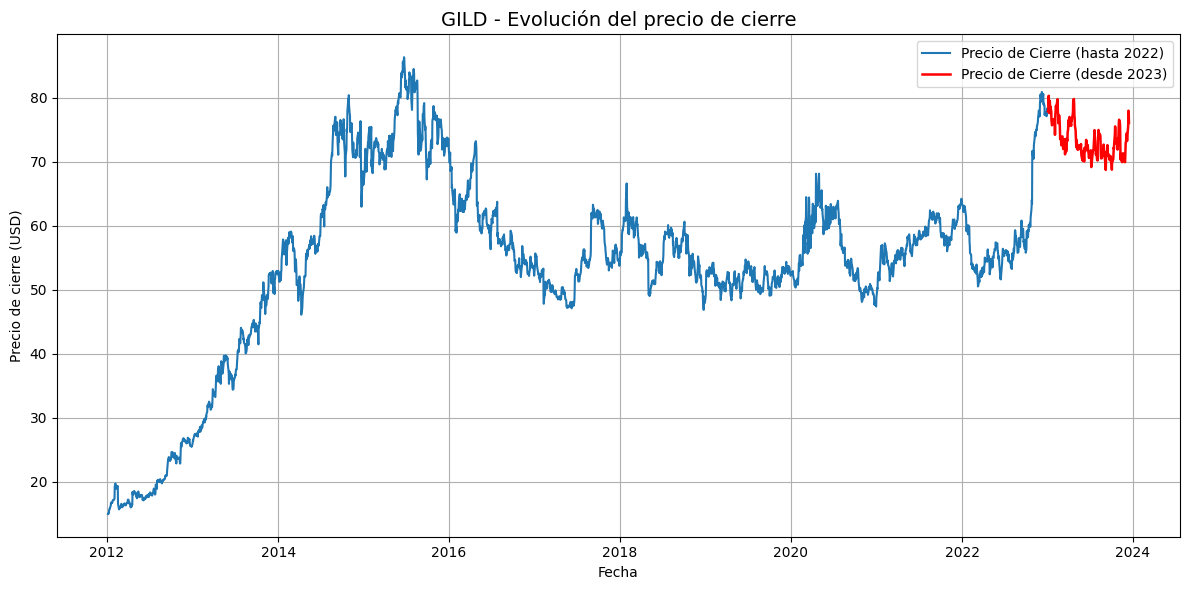

In [ ]:
import matplotlib.pyplot as plt

# Asegurar que la fecha esté en el eje X correctamente
df_ta = df_ta.sort_values('Date')

# Crear figura
plt.figure(figsize=(12, 6))

# Línea principal hasta 2022 (azul)
plt.plot(df_ta[df_ta['Date'] < '2023-01-01']['Date'],
         df_ta[df_ta['Date'] < '2023-01-01']['Close'],
         label='Precio de Cierre (hasta 2022)',
         linewidth=1.5)

# Línea a partir de 2023 (roja)
plt.plot(df_ta[df_ta['Date'] >= '2023-01-01']['Date'],
         df_ta[df_ta['Date'] >= '2023-01-01']['Close'],
         color='red',
         label='Precio de Cierre (desde 2023)',
         linewidth=1.8)

# Estética
plt.title("GILD - Evolución del precio de cierre", fontsize=14)
plt.xlabel("Fecha")
plt.ylabel("Precio de cierre (USD)")
plt.grid(True)
plt.legend()
plt.tight_layout()

# Mostrar gráfico
plt.show()



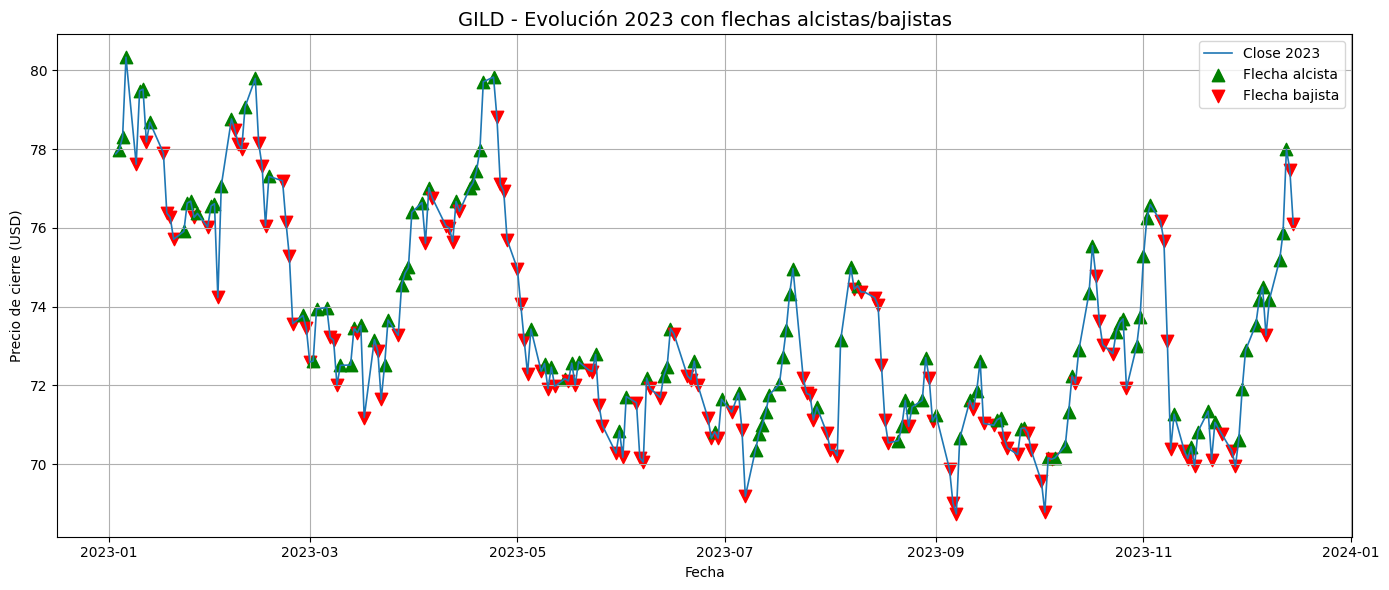

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Asegurarnos de que 'Date' sea datetime y ordenar
df_ta['Date'] = pd.to_datetime(df_ta['Date'])
df_ta = df_ta.sort_values('Date')

# Filtrar solo 2023
mask_2023 = (df_ta['Date'] >= '2023-01-01') & (df_ta['Date'] < '2024-01-01')
df_2023 = df_ta.loc[mask_2023].copy()

# Calcular variación respecto al día anterior
df_2023['delta'] = df_2023['Close'].diff()

# Gráfico base
plt.figure(figsize=(14, 6))
plt.plot(df_2023['Date'], df_2023['Close'], linewidth=1.2, label='Close 2023')
plt.title("GILD - Evolución 2023 con flechas alcistas/bajistas", fontsize=14)
plt.xlabel("Fecha")
plt.ylabel("Precio de cierre (USD)")
plt.grid(True)

# Variables para controlar si ya se añadió la leyenda
added_bull = False
added_bear = False

# Añadir flechas alcistas/bajistas
for i in range(1, len(df_2023)):
    x = df_2023['Date'].iloc[i]
    y = df_2023['Close'].iloc[i]
    d = df_2023['delta'].iloc[i]

    if d > 0:
        plt.scatter(x, y, marker='^', color='green', s=80,
                    label="Flecha alcista" if not added_bull else "")
        added_bull = True
    elif d < 0:
        plt.scatter(x, y, marker='v', color='red', s=80,
                    label="Flecha bajista" if not added_bear else "")
        added_bear = True

plt.legend()
plt.tight_layout()
plt.show()


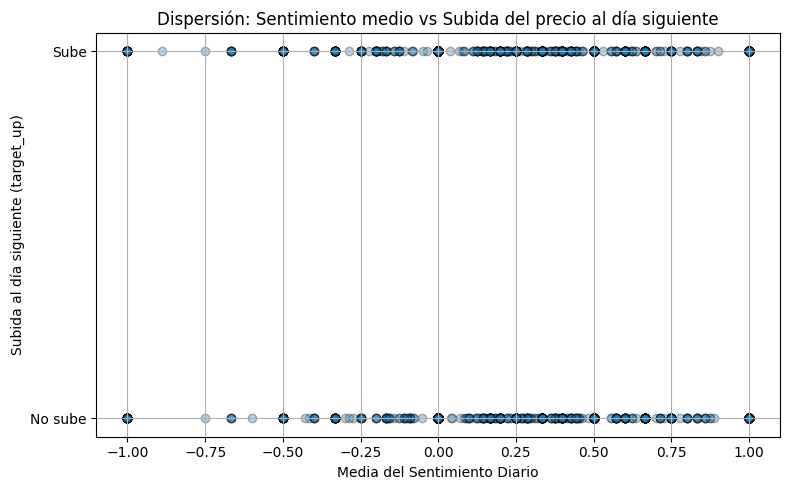

In [ ]:
# Crear copia base del dataset para EDA
df_eda = df_ta.copy()

# Crear columna con el cierre del día siguiente
df_eda['Close_next_day'] = df_eda['Close'].shift(-1)

# Crear variable binaria objetivo: 1 si sube al día siguiente, 0 si no
df_eda['target_up'] = (df_eda['Close_next_day'] > df_eda['Close']).astype(int)

# Seleccionar columnas clave para el EDA (sentimiento + target)
cols_sentimiento = [
    'mean_sentiment_value',
    'mean_sentiment_score',
    'mean_sentiment_positive_prob',
    'mean_sentiment_negative_prob',
    'mean_sentiment_neutral_prob',
    'sentiment_bias',
    'sentiment_direction'
]

# Filtrar columnas necesarias y eliminar nulos
df_eda = df_eda[cols_sentimiento + ['target_up']].dropna()

import matplotlib.pyplot as plt

# Calcular correlaciones con el target
correlations = df_eda.corr(numeric_only=True)['target_up'].drop('target_up').sort_values()

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.scatter(df_eda['mean_sentiment_value'], df_eda['target_up'], alpha=0.3, edgecolor='k')
plt.title('Dispersión: Sentimiento medio vs Subida del precio al día siguiente')
plt.xlabel('Media del Sentimiento Diario')
plt.ylabel('Subida al día siguiente (target_up)')
plt.yticks([0, 1], ['No sube', 'Sube'])
plt.grid(True)
plt.tight_layout()
plt.show()





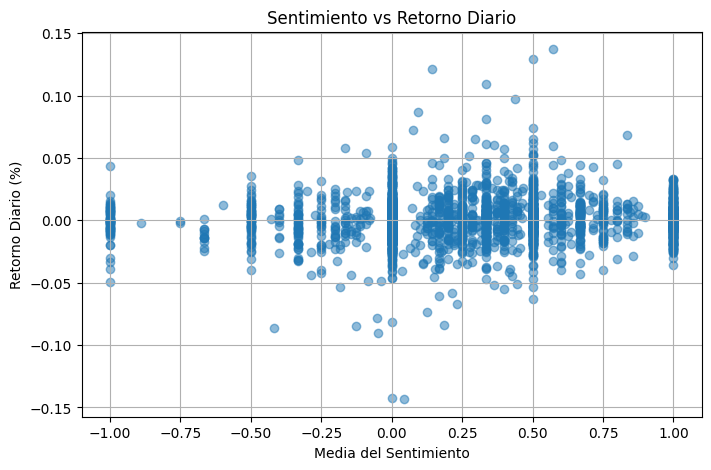

In [ ]:
df_ta['return'] = df_ta['Close'].pct_change()
df_corr = df_ta[['mean_sentiment_value', 'return']].dropna()

plt.figure(figsize=(8, 5))
plt.scatter(df_corr['mean_sentiment_value'], df_corr['return'], alpha=0.5)
plt.title('Sentimiento vs Retorno Diario')
plt.xlabel('Media del Sentimiento')
plt.ylabel('Retorno Diario (%)')
plt.grid(True)
plt.show()


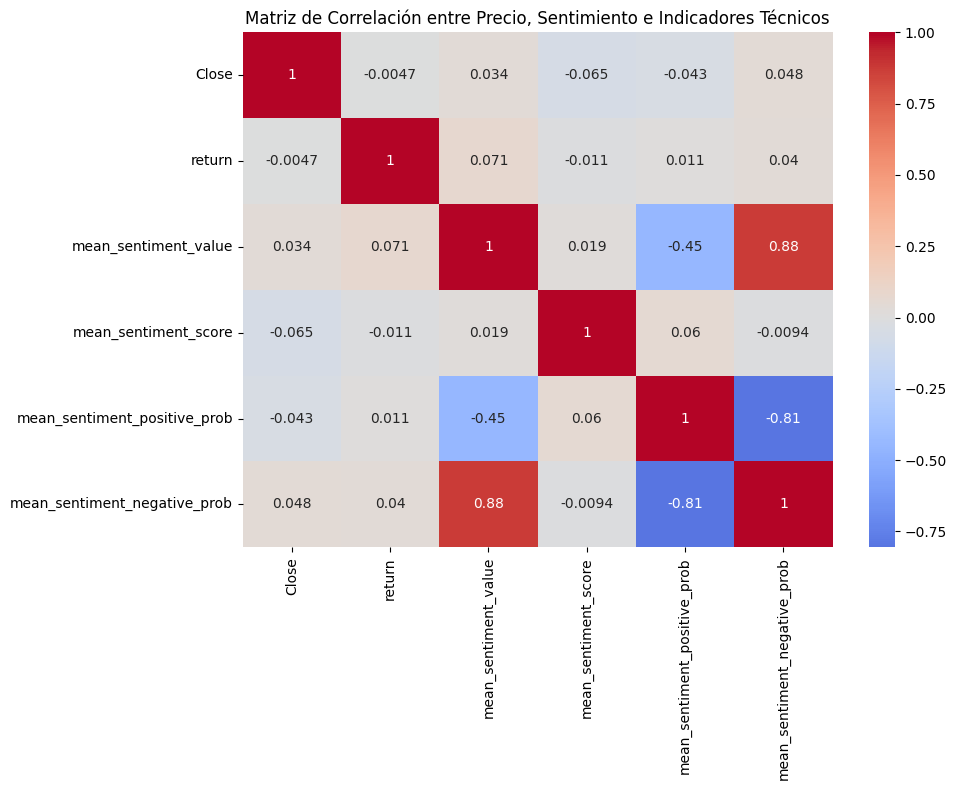

In [ ]:
import seaborn as sns

# Seleccionar variables numéricas clave
cols = [
    'Close', 'return', 'mean_sentiment_value', 'mean_sentiment_score',
    'mean_sentiment_positive_prob', 'mean_sentiment_negative_prob', ]
corr_matrix = df_ta[cols].dropna().corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Matriz de Correlación entre Precio, Sentimiento e Indicadores Técnicos')
plt.tight_layout()
plt.show()


/tmp/ipython-input-1304320646.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df_plot, x="Clase", y="Porcentaje", palette=palette, edgecolor="black")


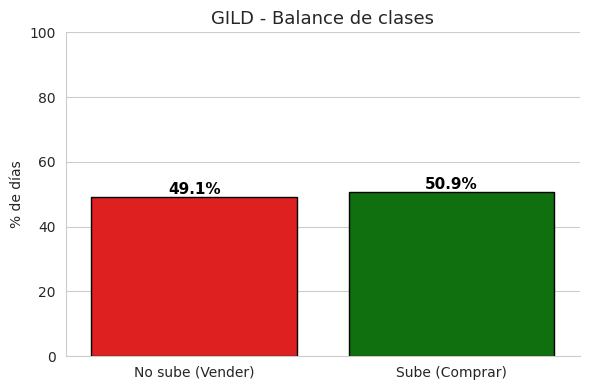

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Calcular proporciones de cada clase
target_counts = df_eda['target_up'].value_counts(normalize=True).sort_index() * 100

# Crear DataFrame auxiliar para seaborn
df_plot = pd.DataFrame({
    "Clase": ['No sube (Vender)', 'Sube (Comprar)'],
    "Porcentaje": target_counts.values
})

# Colores personalizados
palette = {'No sube (Vender)': 'red', 'Sube (Comprar)': 'green'}

# Estilo seaborn
sns.set_style("whitegrid")

# Gráfico
plt.figure(figsize=(6, 4))
ax = sns.barplot(data=df_plot, x="Clase", y="Porcentaje", palette=palette, edgecolor="black")

# Añadir etiquetas con % encima de las barras
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}%',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom',
                fontsize=11, color='black', weight='bold')

# Estética
plt.title("GILD - Balance de clases", fontsize=13)
plt.ylabel('% de días')
plt.xlabel('')
plt.ylim(0, 100)
sns.despine()
plt.tight_layout()
plt.show()



# MODELOS BUY/SELL

- Creamos la target, que será comprar o vender en función de si el día siguiente sube/baja el precio

In [ ]:
# Ordenar por fecha para asegurar el cálculo correcto
df_ta = df_ta.sort_values(by='Date').reset_index(drop=True)

# Crear la variable Target: 1 si el precio sube al día siguiente, 0 si no sube o se mantiene
df_ta['Target'] = (df_ta['Close'].shift(-1) > df_ta['Close']).astype(int)

# Ver distribución
print("📊 Distribución de la variable Target (1 = Comprar, 0 = No comprar):")
print(df_ta['Target'].value_counts())

# Ver ejemplo
print("\n🔍 Ejemplo:")
print(df_ta[['Date', 'Close', 'Target']].tail(10))
df_ta = df_ta.dropna(subset=['Target'])


📊 Distribución de la variable Target (1 = Comprar, 0 = No comprar):
Target
1    1551
0    1456
Name: count, dtype: int64

🔍 Ejemplo:
           Date      Close  Target
2997 2023-12-04  73.542931       1
2998 2023-12-05  74.181290       1
2999 2023-12-06  74.500473       0
3000 2023-12-07  73.270691       1
3001 2023-12-08  74.181290       1
3002 2023-12-11  75.185776       1
3003 2023-12-12  75.871071       1
3004 2023-12-13  78.002075       0
3005 2023-12-14  77.471565       0
3006 2023-12-15  76.097961       0


##  Análisis de sentimientos

#### Reglas

📈 Resultados del modelo de regla simple (baseline):
              precision    recall  f1-score   support

  No Comprar       0.48      0.35      0.41      1243
     Comprar       0.50      0.64      0.56      1286

    accuracy                           0.50      2529
   macro avg       0.49      0.49      0.48      2529
weighted avg       0.49      0.50      0.49      2529

✅ Accuracy: 0.50


/tmp/ipython-input-3070535342.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model['Predicted_rule'] = (df_model['mean_weighted_score_value'] > 0).astype(int)


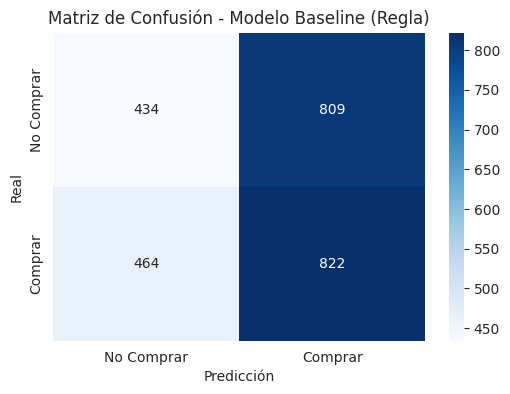

📊 Predicciones guardadas para ensemble: 187 filas


,Date,y_real,pred_sentiment_rule
2767,2023-01-04,1,0
2768,2023-01-05,1,0
2769,2023-01-06,0,1
2771,2023-01-10,1,1
2772,2023-01-11,0,1


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================
# Configuración
# ==========================
fecha_corte = '2023-01-01'

# ==========================
# Asegurarse de no tener NaNs
# ==========================
df_model = df_ta.dropna(subset=['mean_weighted_score_value', 'Target'])

# ==========================
# Regla: si la media ponderada es positiva → comprar
# ==========================
df_model['Predicted_rule'] = (df_model['mean_weighted_score_value'] > 0).astype(int)

# ==========================
# Evaluación general
# ==========================
y_true = df_model['Target']
y_pred = df_model['Predicted_rule']

print("📈 Resultados del modelo de regla simple (baseline):")
print(classification_report(y_true, y_pred, target_names=["No Comprar", "Comprar"]))
print(f"✅ Accuracy: {accuracy_score(y_true, y_pred):.2f}")

# Matriz de confusión visual
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_true, y_pred),
            annot=True, fmt='d', cmap='Blues',
            xticklabels=["No Comprar", "Comprar"],
            yticklabels=["No Comprar", "Comprar"])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión - Modelo Baseline (Regla)')
plt.show()

# ==========================
# Guardar predicciones para ensemble
# ==========================
df_pred_sentiment_rule = df_model.loc[df_model['Date'] >= fecha_corte, ['Date']].copy()
df_pred_sentiment_rule['y_real'] = df_model.loc[df_model['Date'] >= fecha_corte, 'Target'].values
df_pred_sentiment_rule['pred_sentiment_rule'] = df_model.loc[df_model['Date'] >= fecha_corte, 'Predicted_rule'].values

print(f"📊 Predicciones guardadas para ensemble: {df_pred_sentiment_rule.shape[0]} filas")
df_pred_sentiment_rule.head()



📈 Resultados usando la media simple del sentimiento:
[[494 749]
 [519 767]]
              precision    recall  f1-score   support

  No Comprar       0.49      0.40      0.44      1243
     Comprar       0.51      0.60      0.55      1286

    accuracy                           0.50      2529
   macro avg       0.50      0.50      0.49      2529
weighted avg       0.50      0.50      0.49      2529

✅ Accuracy: 0.50


/tmp/ipython-input-1304184456.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model2['Predicted_mean'] = (df_model2['mean_sentiment_value'] > 0).astype(int)


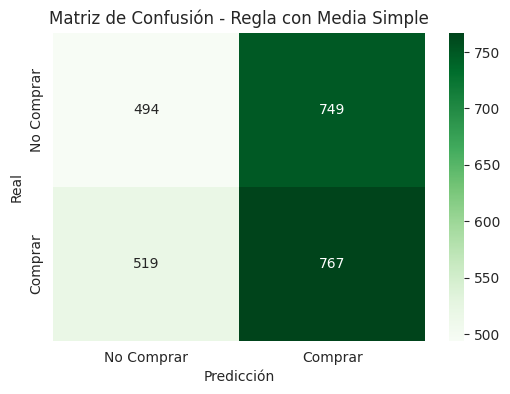

📊 Predicciones guardadas para ensemble: 187 filas


,Date,y_real,pred_sentiment_mean
2767,2023-01-04,1,0
2768,2023-01-05,1,0
2769,2023-01-06,0,1
2771,2023-01-10,1,1
2772,2023-01-11,0,1


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================
# Configuración
# ==========================
fecha_corte = '2023-01-01'

# ==========================
# Asegurarse de no tener NaNs
# ==========================
df_model2 = df_ta.dropna(subset=['mean_sentiment_value', 'Target'])

# ==========================
# Regla basada en la media simple de valores de sentimiento
# ==========================
df_model2['Predicted_mean'] = (df_model2['mean_sentiment_value'] > 0).astype(int)

# ==========================
# Evaluación general
# ==========================
y_true_mean = df_model2['Target']
y_pred_mean = df_model2['Predicted_mean']

print("📈 Resultados usando la media simple del sentimiento:")
print(confusion_matrix(y_true_mean, y_pred_mean))
print(classification_report(y_true_mean, y_pred_mean, target_names=["No Comprar", "Comprar"]))
print(f"✅ Accuracy: {accuracy_score(y_true_mean, y_pred_mean):.2f}")

# Matriz de confusión visual
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_true_mean, y_pred_mean), annot=True, fmt='d',
            cmap='Greens', xticklabels=["No Comprar", "Comprar"],
            yticklabels=["No Comprar", "Comprar"])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión - Regla con Media Simple')
plt.show()

# ==========================
# Guardar predicciones para ensemble
# ==========================
df_pred_sentiment_mean = df_model2.loc[df_model2['Date'] >= fecha_corte, ['Date']].copy()
df_pred_sentiment_mean['y_real'] = df_model2.loc[df_model2['Date'] >= fecha_corte, 'Target'].values
df_pred_sentiment_mean['pred_sentiment_mean'] = df_model2.loc[df_model2['Date'] >= fecha_corte, 'Predicted_mean'].values

print(f"📊 Predicciones guardadas para ensemble: {df_pred_sentiment_mean.shape[0]} filas")
df_pred_sentiment_mean.head()


#### Regresión Logística

📊 Resultados RandomForest con sentimientos (threshold=0.53):
[[27 32]
 [25 40]]
              precision    recall  f1-score   support

  No Comprar       0.52      0.46      0.49        59
     Comprar       0.56      0.62      0.58        65

    accuracy                           0.54       124
   macro avg       0.54      0.54      0.54       124
weighted avg       0.54      0.54      0.54       124

✅ Accuracy: 0.54


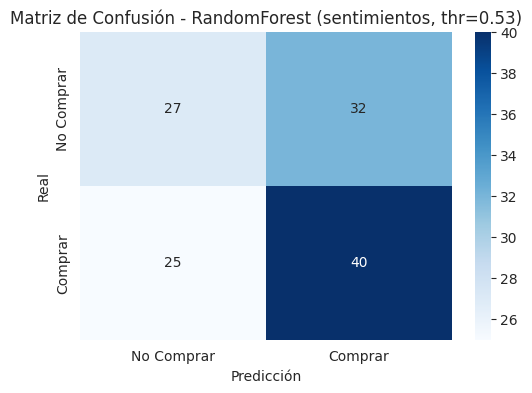

📂 Predicciones guardadas para ensemble: 124 filas


,Date,y_real,pred_prob_sentiment_rf,pred_bin_sentiment_rf
2767,2023-01-04,1,0.685,1
2772,2023-01-11,0,0.595,1
2775,2023-01-17,0,0.750,1
2776,2023-01-18,0,0.410,0
2779,2023-01-23,1,0.535,1


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================
# Configuración
# ==========================
fecha_corte = '2023-01-01'
threshold = 0.53  # ← aquí puedes cambiar el umbral
sentiment_features = [
    'mean_sentiment_score',
    'mean_sentiment_value',
    'mean_sentiment_positive_prob',
    'mean_sentiment_negative_prob',
    'mean_sentiment_neutral_prob',
    'mean_weighted_score_value',
    'dominant_sentiment_strength',
    'sentiment_direction',
    'sentiment_bias',
    'std_sentiment_value'
]

# ==========================
# Preparar datos
# ==========================
df_ta['Date'] = pd.to_datetime(df_ta['Date'])
df_ml = df_ta.dropna(subset=sentiment_features + ['Target'])

df_train = df_ml[df_ml['Date'] <= fecha_corte]
df_test  = df_ml[df_ml['Date'] > fecha_corte]

X_train = df_train[sentiment_features]
y_train = df_train['Target']
X_test  = df_test[sentiment_features]
y_test  = df_test['Target']

# ==========================
# Entrenar modelo RandomForest
# ==========================
model = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    class_weight='balanced',
    random_state=42
)
model.fit(X_train, y_train)

# ==========================
# Predicciones con threshold
# ==========================
y_pred_prob = model.predict_proba(X_test)[:, 1]  # probabilidad de clase 1 (Comprar)
y_pred = (y_pred_prob >= threshold).astype(int)

# ==========================
# Evaluación
# ==========================
print(f"📊 Resultados RandomForest con sentimientos (threshold={threshold}):")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=["No Comprar", "Comprar"]))
print(f"✅ Accuracy: {accuracy_score(y_test, y_pred):.2f}")

# Matriz de confusión visual
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d',
            cmap='Blues', xticklabels=["No Comprar", "Comprar"],
            yticklabels=["No Comprar", "Comprar"])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title(f'Matriz de Confusión - RandomForest (sentimientos, thr={threshold})')
plt.show()

# ==========================
# Guardar predicciones para ensemble
# ==========================
df_pred_sentiment_rf = df_test[['Date']].copy()
df_pred_sentiment_rf['y_real'] = y_test.values
df_pred_sentiment_rf['pred_prob_sentiment_rf'] = y_pred_prob
df_pred_sentiment_rf['pred_bin_sentiment_rf'] = y_pred

print(f"📂 Predicciones guardadas para ensemble: {df_pred_sentiment_rf.shape[0]} filas")
df_pred_sentiment_rf.head()



Matriz de confusión (threshold = 0.5):
[[25 34]
 [24 41]]

Reporte de clasificación:
              precision    recall  f1-score   support

  No Comprar       0.51      0.42      0.46        59
     Comprar       0.55      0.63      0.59        65

    accuracy                           0.53       124
   macro avg       0.53      0.53      0.52       124
weighted avg       0.53      0.53      0.53       124



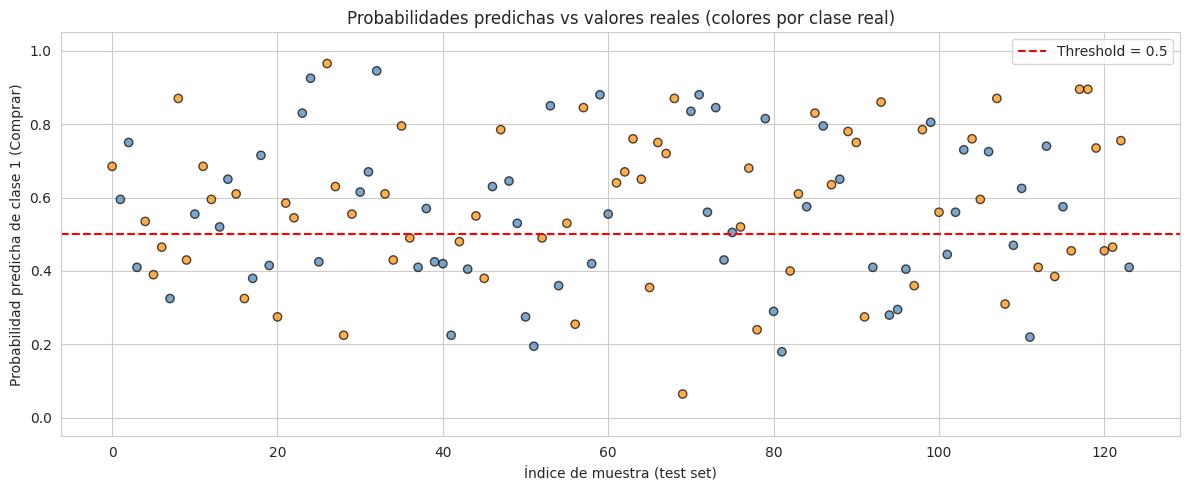

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Obtener probabilidades para la clase 1
y_proba = model.predict_proba(X_test)[:, 1]

# Threshold personalizado
threshold = 0.5
y_pred = (y_proba >= threshold).astype(int)

# Valores reales
y_true = y_test.values

# ===== Matriz de confusión y métricas =====
print(f"\nMatriz de confusión (threshold = {threshold}):")
print(confusion_matrix(y_true, y_pred))
print("\nReporte de clasificación:")
print(classification_report(y_true, y_pred, target_names=["No Comprar", "Comprar"]))

# ===== Visualización de probabilidades =====
colors = np.where(y_true == 1, 'darkorange', 'steelblue')

plt.figure(figsize=(12, 5))
plt.scatter(range(len(y_proba)), y_proba, c=colors, edgecolor='k', alpha=0.7)
plt.axhline(threshold, color='red', linestyle='--', label=f'Threshold = {threshold}')
plt.title('Probabilidades predichas vs valores reales (colores por clase real)')
plt.xlabel('Índice de muestra (test set)')
plt.ylabel('Probabilidad predicha de clase 1 (Comprar)')
plt.ylim(-0.05, 1.05)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



#### RandomForest

- RandomSearch

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np

# ==========================
# Configuración
# ==========================
threshold = 0.5  # ← aquí cambias el umbral
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 5, 10, 15, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

# ==========================
# Búsqueda aleatoria de hiperparámetros
# ==========================
rf_base = RandomForestClassifier(random_state=42, class_weight='balanced')
random_search = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=param_dist,
    n_iter=30,
    cv=3,       # validación cruzada interna (no temporal)
    verbose=1,
    n_jobs=-1,
    scoring='f1',
    random_state=42
)

random_search.fit(X_train, y_train)
best_rf = random_search.best_estimator_

print("\nMejores hiperparámetros encontrados:")
print(random_search.best_params_)

# ==========================
# Predicciones con threshold
# ==========================
y_pred_prob = best_rf.predict_proba(X_test)[:, 1]
y_pred_rf = (y_pred_prob >= threshold).astype(int)

# ==========================
# Evaluación
# ==========================
print(f"\n📊 Matriz de confusión - RandomForest optimizado (threshold={threshold}):")
print(confusion_matrix(y_test, y_pred_rf))

print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred_rf, target_names=["No Comprar", "Comprar"]))

print(f"✅ Accuracy: {accuracy_score(y_test, y_pred_rf):.2f}")

# ==========================
# Guardar predicciones para ensemble
# ==========================
df_pred_sentiment_rf_opt = df_test[['Date']].copy()
df_pred_sentiment_rf_opt['y_real'] = y_test.values
df_pred_sentiment_rf_opt['pred_prob_sentiment_rf_opt'] = y_pred_prob
df_pred_sentiment_rf_opt['pred_bin_sentiment_rf_opt'] = y_pred_rf

print(f"📂 Predicciones guardadas para ensemble: {df_pred_sentiment_rf_opt.shape[0]} filas")
df_pred_sentiment_rf_opt.head()


Fitting 3 folds for each of 30 candidates, totalling 90 fits

Mejores hiperparámetros encontrados:
{'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': True}

📊 Matriz de confusión - RandomForest optimizado (threshold=0.5):
[[26 33]
 [22 43]]

Reporte de clasificación:
              precision    recall  f1-score   support

  No Comprar       0.54      0.44      0.49        59
     Comprar       0.57      0.66      0.61        65

    accuracy                           0.56       124
   macro avg       0.55      0.55      0.55       124
weighted avg       0.55      0.56      0.55       124

✅ Accuracy: 0.56
📂 Predicciones guardadas para ensemble: 124 filas


,Date,y_real,pred_prob_sentiment_rf_opt,pred_bin_sentiment_rf_opt
2767,2023-01-04,1,0.718401,1
2772,2023-01-11,0,0.551260,1
2775,2023-01-17,0,0.737785,1
2776,2023-01-18,0,0.392106,0
2779,2023-01-23,1,0.528384,1



Matriz de confusión - Random Forest (threshold = 0.47):
[[25 34]
 [20 45]]

Reporte de clasificación:
              precision    recall  f1-score   support

  No Comprar       0.56      0.42      0.48        59
     Comprar       0.57      0.69      0.62        65

    accuracy                           0.56       124
   macro avg       0.56      0.56      0.55       124
weighted avg       0.56      0.56      0.56       124



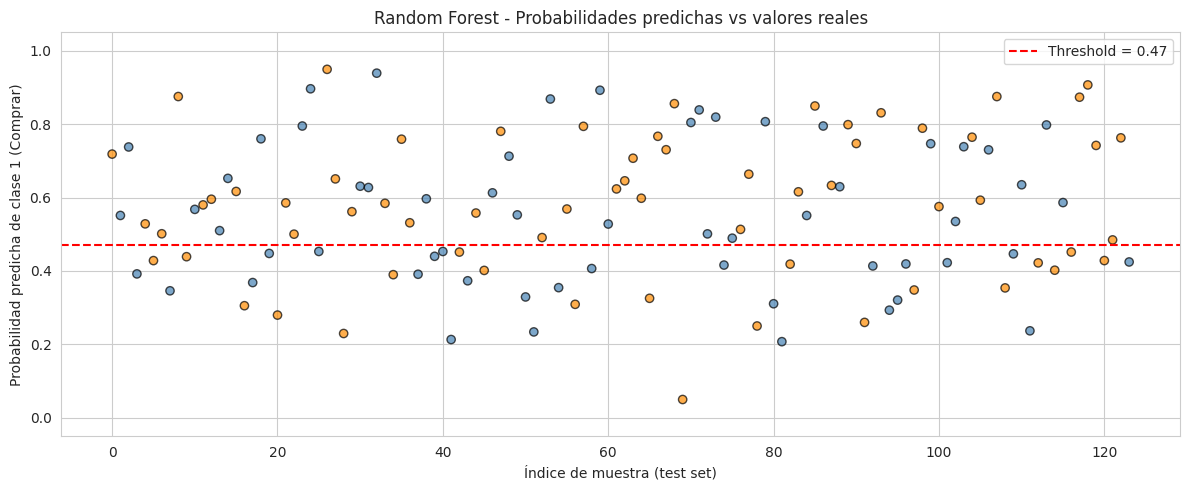

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Obtener probabilidades para clase 1
y_proba_rf = best_rf.predict_proba(X_test)[:, 1]

# Threshold personalizado
threshold = 0.47
y_pred_rf_thresh = (y_proba_rf >= threshold).astype(int)

# Valores reales
y_true = y_test.values

# ===== Evaluación =====
print(f"\nMatriz de confusión - Random Forest (threshold = {threshold}):")
print(confusion_matrix(y_true, y_pred_rf_thresh))

print("\nReporte de clasificación:")
print(classification_report(y_true, y_pred_rf_thresh, target_names=["No Comprar", "Comprar"]))

# ===== Visualización =====
colors = np.where(y_true == 1, 'darkorange', 'steelblue')

plt.figure(figsize=(12, 5))
plt.scatter(range(len(y_proba_rf)), y_proba_rf, c=colors, edgecolor='k', alpha=0.7)
plt.axhline(threshold, color='red', linestyle='--', label=f'Threshold = {threshold}')
plt.title('Random Forest - Probabilidades predichas vs valores reales')
plt.xlabel('Índice de muestra (test set)')
plt.ylabel('Probabilidad predicha de clase 1 (Comprar)')
plt.ylim(-0.05, 1.05)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


- Gridsearch

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# ==========================
# Configuración
# ==========================
threshold = 0.5  # ← Cambia aquí el umbral que quieras usar

# ==========================
# Definir espacio de búsqueda
# ==========================
param_grid = {
    'n_estimators': [250, 300, 350],
    'max_depth': [25, 30, 35],
    'min_samples_split': [2, 3],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt'],
    'bootstrap': [True]
}

# ==========================
# GridSearch
# ==========================
rf_base = RandomForestClassifier(random_state=42, class_weight='balanced')

grid_search = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    scoring='f1',
    cv=3,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)
best_rf_grid = grid_search.best_estimator_

print("\nMejores hiperparámetros encontrados:")
print(grid_search.best_params_)

# ==========================
# Predicciones con threshold
# ==========================
y_pred_prob_grid = best_rf_grid.predict_proba(X_test)[:, 1]
y_pred_bin_grid = (y_pred_prob_grid >= threshold).astype(int)

# ==========================
# Evaluación
# ==========================
print(f"\n📊 Matriz de confusión - RandomForest (GridSearch, threshold={threshold}):")
print(confusion_matrix(y_test, y_pred_bin_grid))

print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred_bin_grid, target_names=["No Comprar", "Comprar"]))

print(f"✅ Accuracy: {accuracy_score(y_test, y_pred_bin_grid):.2f}")

# ==========================
# Guardar predicciones para ensemble
# ==========================
df_pred_sentiment_rf_grid = df_test[['Date']].copy()
df_pred_sentiment_rf_grid['y_real'] = y_test.values
df_pred_sentiment_rf_grid['pred_prob_sentiment_rf_grid'] = y_pred_prob_grid
df_pred_sentiment_rf_grid['pred_bin_sentiment_rf_grid'] = y_pred_bin_grid

print(f"📂 Predicciones guardadas para ensemble: {df_pred_sentiment_rf_grid.shape[0]} filas")
df_pred_sentiment_rf_grid.head()


Fitting 3 folds for each of 36 candidates, totalling 108 fits

Mejores hiperparámetros encontrados:
{'bootstrap': True, 'max_depth': 25, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 250}

📊 Matriz de confusión - RandomForest (GridSearch, threshold=0.5):
[[26 33]
 [25 40]]

Reporte de clasificación:
              precision    recall  f1-score   support

  No Comprar       0.51      0.44      0.47        59
     Comprar       0.55      0.62      0.58        65

    accuracy                           0.53       124
   macro avg       0.53      0.53      0.53       124
weighted avg       0.53      0.53      0.53       124

✅ Accuracy: 0.53
📂 Predicciones guardadas para ensemble: 124 filas


,Date,y_real,pred_prob_sentiment_rf_grid,pred_bin_sentiment_rf_grid
2767,2023-01-04,1,0.697498,1
2772,2023-01-11,0,0.562881,1
2775,2023-01-17,0,0.756975,1
2776,2023-01-18,0,0.438098,0
2779,2023-01-23,1,0.520728,1



Matriz de confusión - Random Forest (threshold = 0.4):
[[17 42]
 [13 52]]

Reporte de clasificación:
              precision    recall  f1-score   support

  No Comprar       0.57      0.29      0.38        59
     Comprar       0.55      0.80      0.65        65

    accuracy                           0.56       124
   macro avg       0.56      0.54      0.52       124
weighted avg       0.56      0.56      0.52       124



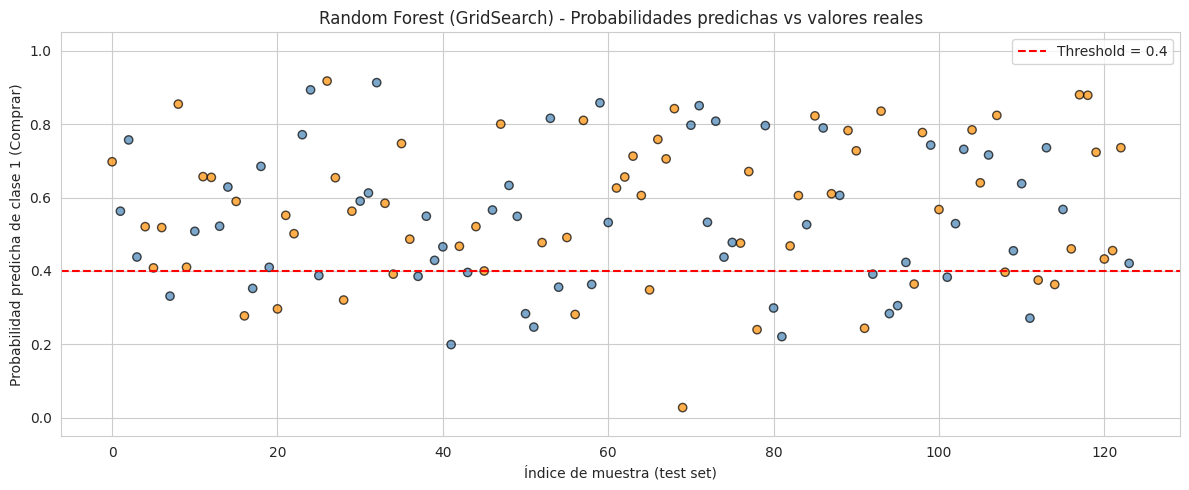

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Obtener probabilidades de clase 1
y_proba_grid = best_rf_grid.predict_proba(X_test)[:, 1]

# Threshold personalizado
threshold = 0.4
y_pred_grid_thresh = (y_proba_grid >= threshold).astype(int)

# Valores reales
y_true = y_test.values

# ===== Evaluación =====
print(f"\nMatriz de confusión - Random Forest (threshold = {threshold}):")
print(confusion_matrix(y_true, y_pred_grid_thresh))

print("\nReporte de clasificación:")
print(classification_report(y_true, y_pred_grid_thresh, target_names=["No Comprar", "Comprar"]))

# ===== Visualización =====
colors = np.where(y_true == 1, 'darkorange', 'steelblue')

plt.figure(figsize=(12, 5))
plt.scatter(range(len(y_proba_grid)), y_proba_grid, c=colors, edgecolor='k', alpha=0.7)
plt.axhline(threshold, color='red', linestyle='--', label=f'Threshold = {threshold}')
plt.title('Random Forest (GridSearch) - Probabilidades predichas vs valores reales')
plt.xlabel('Índice de muestra (test set)')
plt.ylabel('Probabilidad predicha de clase 1 (Comprar)')
plt.ylim(-0.05, 1.05)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


#### GRU

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - accuracy: 0.5178 - loss: 0.6978 - val_accuracy: 0.5038 - val_loss: 0.6983
Epoch 2/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.5227 - loss: 0.6950 - val_accuracy: 0.4809 - val_loss: 0.7039
Epoch 3/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5166 - loss: 0.6928 - val_accuracy: 0.4656 - val_loss: 0.7017
Epoch 4/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5288 - loss: 0.6900 - val_accuracy: 0.4504 - val_loss: 0.7050
Epoch 5/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5407 - loss: 0.6873 - val_accuracy: 0.4809 - val_loss: 0.6999
Epoch 6/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5492 - loss: 0.6888 - val_accuracy: 0.4656 - val_loss: 0.7047
Epoch 7/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5371 - loss: 0.6878 - val_accuracy: 0.4580 - val_loss: 0.7091
Epoch 8/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5500 - loss: 0.6818 - val_accuracy: 0.4427 - v

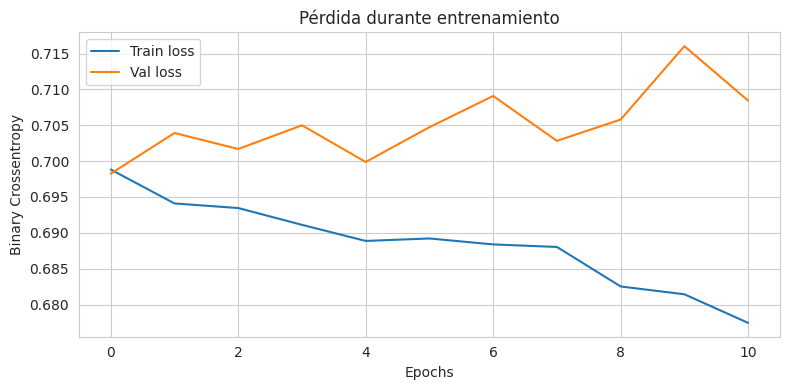

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# ==========================
# Configuración
# ==========================
threshold = 0.5  # ← Cambia aquí el umbral que quieras usar
window_size = 60
fecha_corte_test = pd.Timestamp('2023-01-01')
fecha_corte_val = pd.Timestamp('2022-01-01')

sentiment_features = [
    'mean_sentiment_score',
    'mean_sentiment_value',
    'mean_sentiment_positive_prob',
    'mean_sentiment_negative_prob',
    'mean_sentiment_neutral_prob',
    'mean_weighted_score_value',
    'dominant_sentiment_strength',
    'sentiment_direction',
    'sentiment_bias',
    'std_sentiment_value'
]
target_col = 'Target'

# ==========================
# Preparar DataFrame
# ==========================
df_seq = df_ta.sort_values("Date").reset_index(drop=True)
df_seq = df_seq.dropna(subset=sentiment_features + [target_col])
df_seq['Date'] = pd.to_datetime(df_seq['Date'])

# Escalar solo features
scaler = StandardScaler()
df_seq_scaled = df_seq.copy()
df_seq_scaled[sentiment_features] = scaler.fit_transform(df_seq[sentiment_features])

# Crear secuencias
X_seq, y_seq, dates_seq = [], [], []
for i in range(window_size, len(df_seq_scaled)):
    X_seq.append(df_seq_scaled.iloc[i - window_size:i][sentiment_features].values)
    y_seq.append(df_seq_scaled.iloc[i][target_col])
    dates_seq.append(df_seq_scaled.iloc[i]['Date'])

X_seq = np.array(X_seq)
y_seq = np.array(y_seq)
dates_seq = np.array(dates_seq)

# Separar train / val / test
X_train = X_seq[dates_seq < fecha_corte_val]
y_train = y_seq[dates_seq < fecha_corte_val]

X_val = X_seq[(dates_seq >= fecha_corte_val) & (dates_seq < fecha_corte_test)]
y_val = y_seq[(dates_seq >= fecha_corte_val) & (dates_seq < fecha_corte_test)]

X_test = X_seq[dates_seq >= fecha_corte_test]
y_test = y_seq[dates_seq >= fecha_corte_test]
dates_test = dates_seq[dates_seq >= fecha_corte_test]

# ==========================
# Modelo GRU
# ==========================
model = Sequential([
    GRU(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    GRU(64),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Entrenamiento
early_stop = EarlyStopping(patience=10, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    epochs=15,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stop],
    verbose=1
)

# ==========================
# Predicciones
# ==========================
y_pred_prob = model.predict(X_test).flatten()
y_pred_bin = (y_pred_prob >= threshold).astype(int)

# Evaluación
print(f"📊 Resultados GRU (threshold={threshold}):")
print(confusion_matrix(y_test, y_pred_bin))
print(classification_report(y_test, y_pred_bin, target_names=["No Comprar", "Comprar"]))
print(f"✅ Accuracy: {accuracy_score(y_test, y_pred_bin):.2f}")

# Guardar para ensemble
df_pred_sentiment_gru = pd.DataFrame({
    'Date': dates_test,
    'y_real': y_test,
    'pred_prob_sentiment_gru': y_pred_prob,
    'pred_bin_sentiment_gru': y_pred_bin
})
print(f"📂 Predicciones guardadas para ensemble: {df_pred_sentiment_gru.shape[0]} filas")
df_pred_sentiment_gru.head()

# ==========================
# Gráfico de pérdida
# ==========================
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.title("Pérdida durante entrenamiento")
plt.xlabel("Epochs")
plt.ylabel("Binary Crossentropy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



Matriz de confusión:
[[ 0 59]
 [ 0 65]]

Reporte de clasificación:
              precision    recall  f1-score   support

  No Comprar       0.00      0.00      0.00        59
     Comprar       0.52      1.00      0.69        65

    accuracy                           0.52       124
   macro avg       0.26      0.50      0.34       124
weighted avg       0.27      0.52      0.36       124



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


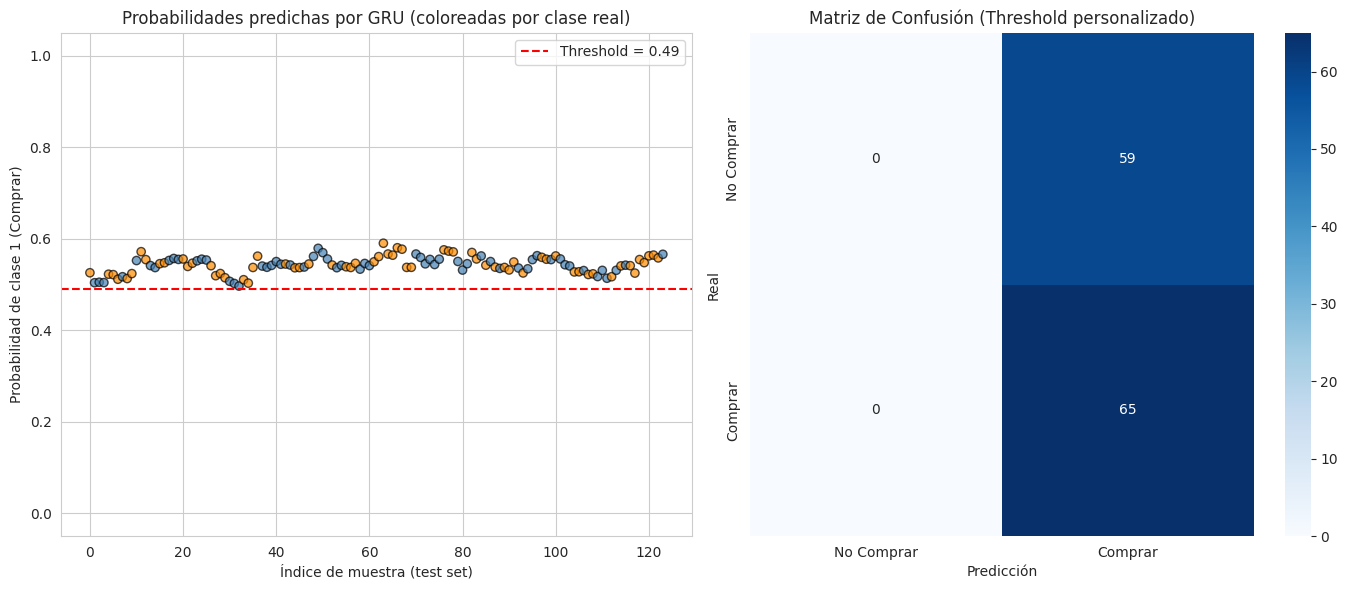

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Threshold personalizado
threshold = 0.49  # puedes ajustarlo a 0.55 o el que desees

# Predicciones binarias según threshold
y_pred_thresh = (y_pred_prob >= threshold).astype(int)

# Confusion matrix y metrics
cm = confusion_matrix(y_test, y_pred_thresh)
print("Matriz de confusión:")
print(cm)

print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred_thresh, target_names=["No Comprar", "Comprar"]))

# Gráfico de probabilidades con colores por clase real
colors = np.where(y_test == 1, 'darkorange', 'steelblue')

plt.figure(figsize=(14, 6))

# 1️⃣ Scatter plot de probabilidades
plt.subplot(1, 2, 1)
plt.scatter(range(len(y_pred_prob)), y_pred_prob, c=colors, edgecolor='k', alpha=0.7)
plt.axhline(threshold, color='red', linestyle='--', label=f'Threshold = {threshold}')
plt.title('Probabilidades predichas por GRU (coloreadas por clase real)')
plt.xlabel('Índice de muestra (test set)')
plt.ylabel('Probabilidad de clase 1 (Comprar)')
plt.ylim(-0.05, 1.05)
plt.grid(True)
plt.legend()

# 2️⃣ Matriz de confusión visual
plt.subplot(1, 2, 2)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["No Comprar", "Comprar"],
            yticklabels=["No Comprar", "Comprar"])
plt.title('Matriz de Confusión (Threshold personalizado)')
plt.xlabel('Predicción')
plt.ylabel('Real')

plt.tight_layout()
plt.show()



#### LSTM

Epoch 1/15


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.5169 - loss: 0.6922 - val_accuracy: 0.4885 - val_loss: 0.6945
Epoch 2/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5524 - loss: 0.6873 - val_accuracy: 0.5191 - val_loss: 0.6938
Epoch 3/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5297 - loss: 0.6881 - val_accuracy: 0.4656 - val_loss: 0.7041
Epoch 4/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5377 - loss: 0.6838 - val_accuracy: 0.4885 - val_loss: 0.6968
Epoch 5/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5828 - loss: 0.6794 - val_accuracy: 0.4809 - val_loss: 0.7052
Epoch 6/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.5598 - loss: 0.6822 - val_accuracy: 0.5038 - val_loss: 0.7018
Epoch 7/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5604 - loss: 0.6770 - val_accuracy: 0.4733 - val_loss: 0.7113
Epoch 8/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5858 - loss: 0.6718 - val_accuracy: 0.5496 - val_loss: 0.

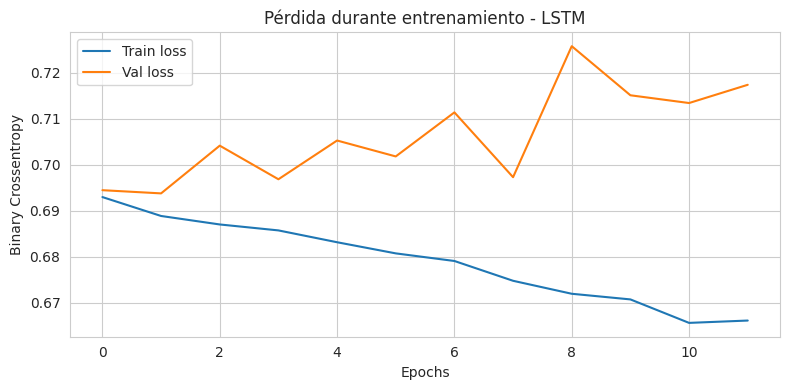

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np

# ==========================
# Configuración
# ==========================
threshold = 0.5  # ← Cambia aquí el umbral de compra
window_size = 60
fecha_corte_test = pd.Timestamp('2023-01-01')
fecha_corte_val = pd.Timestamp('2022-01-01')

sentiment_features = [
    'mean_sentiment_score',
    'mean_sentiment_value',
    'mean_sentiment_positive_prob',
    'mean_sentiment_negative_prob',
    'mean_sentiment_neutral_prob',
    'mean_weighted_score_value',
    'dominant_sentiment_strength',
    'sentiment_direction',
    'sentiment_bias',
    'std_sentiment_value'
]
target_col = 'Target'

# ==========================
# 1️⃣ Preparar el dataframe base
# ==========================
df_seq = df_ta.sort_values("Date").reset_index(drop=True)
df_seq = df_seq.dropna(subset=sentiment_features + [target_col])
df_seq['Date'] = pd.to_datetime(df_seq['Date'])

# Escalar solo los features
scaler = StandardScaler()
df_seq_scaled = df_seq.copy()
df_seq_scaled[sentiment_features] = scaler.fit_transform(df_seq[sentiment_features])

# ==========================
# 2️⃣ Crear ventanas
# ==========================
X_seq, y_seq, dates_seq = [], [], []
for i in range(window_size, len(df_seq_scaled)):
    X_seq.append(df_seq_scaled.iloc[i - window_size:i][sentiment_features].values)
    y_seq.append(df_seq_scaled.iloc[i][target_col])
    dates_seq.append(df_seq_scaled.iloc[i]['Date'])

X_seq = np.array(X_seq)
y_seq = np.array(y_seq)
dates_seq = np.array(dates_seq)

# ==========================
# 3️⃣ Split temporal: train, val, test
# ==========================
X_train = X_seq[dates_seq < fecha_corte_val]
y_train = y_seq[dates_seq < fecha_corte_val]

X_val = X_seq[(dates_seq >= fecha_corte_val) & (dates_seq < fecha_corte_test)]
y_val = y_seq[(dates_seq >= fecha_corte_val) & (dates_seq < fecha_corte_test)]

X_test = X_seq[dates_seq >= fecha_corte_test]
y_test = y_seq[dates_seq >= fecha_corte_test]
dates_test = dates_seq[dates_seq >= fecha_corte_test]

# ==========================
# 4️⃣ Modelo LSTM simple
# ==========================
model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# ==========================
# 5️⃣ Entrenamiento
# ==========================
early_stop = EarlyStopping(patience=10, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    epochs=15,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stop],
    verbose=1
)

# ==========================
# 6️⃣ Predicciones con threshold
# ==========================
y_pred_prob = model.predict(X_test).flatten()
y_pred_bin = (y_pred_prob >= threshold).astype(int)

# Evaluación
print(f"📊 Resultados LSTM (threshold={threshold}):")
print(confusion_matrix(y_test, y_pred_bin))
print(classification_report(y_test, y_pred_bin, target_names=["No Comprar", "Comprar"]))
print(f"✅ Accuracy: {accuracy_score(y_test, y_pred_bin):.2f}")

# ==========================
# 7️⃣ Guardar predicciones para ensemble
# ==========================
df_pred_sentiment_lstm = pd.DataFrame({
    'Date': dates_test,
    'y_real': y_test,
    'pred_prob_sentiment_lstm': y_pred_prob,
    'pred_bin_sentiment_lstm': y_pred_bin
})
print(f"📂 Predicciones guardadas para ensemble: {df_pred_sentiment_lstm.shape[0]} filas")
df_pred_sentiment_lstm.head()

# ==========================
# 8️⃣ Gráfico de pérdida
# ==========================
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.title("Pérdida durante entrenamiento - LSTM")
plt.xlabel("Epochs")
plt.ylabel("Binary Crossentropy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Matriz de confusión:
[[ 3 56]
 [ 4 61]]

Reporte de clasificación:
              precision    recall  f1-score   support

  No Comprar       0.43      0.05      0.09        59
     Comprar       0.52      0.94      0.67        65

    accuracy                           0.52       124
   macro avg       0.47      0.49      0.38       124
weighted avg       0.48      0.52      0.39       124



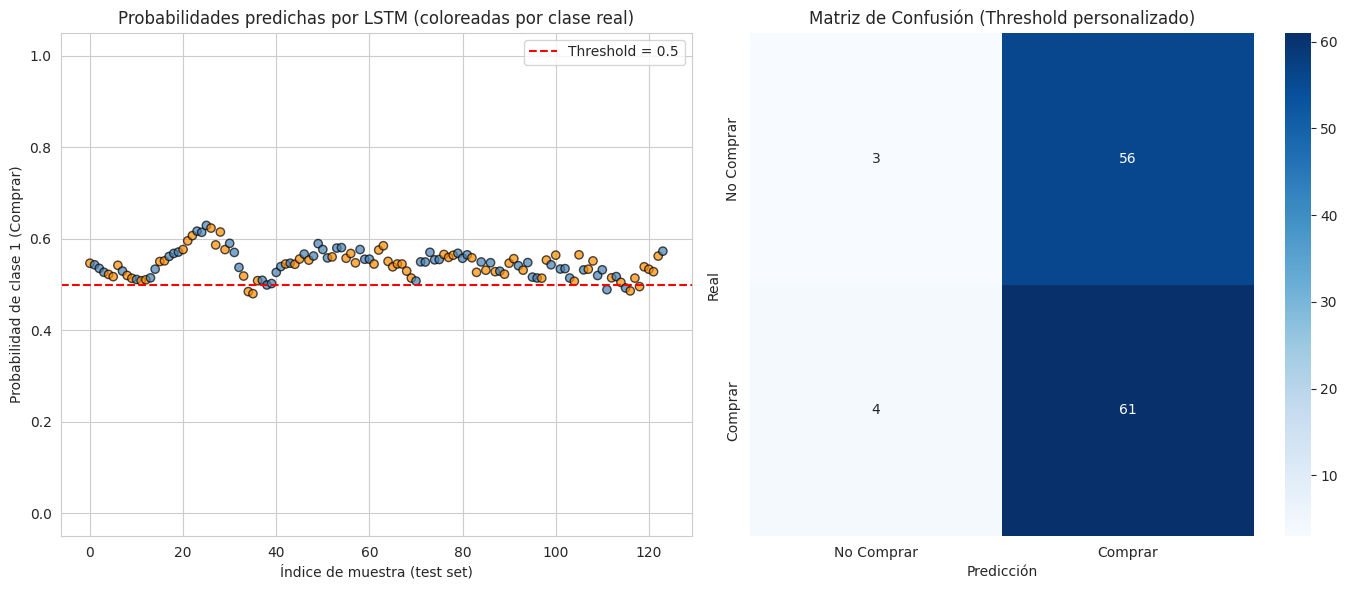

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Threshold personalizado
threshold = 0.5 # cámbialo a 0.55, 0.6, etc., si lo deseas

# Predicciones binarias
y_pred_thresh = (y_pred_prob >= threshold).astype(int)

# Calcular matriz de confusión
cm = confusion_matrix(y_test, y_pred_thresh)

# Reporte
print("Matriz de confusión:")
print(cm)
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred_thresh, target_names=["No Comprar", "Comprar"]))

# Colores por clase real
colors = np.where(y_test == 1, 'darkorange', 'steelblue')

# Plot: Probabilidades vs índice + matriz de confusión
plt.figure(figsize=(14, 6))

# 1️⃣ Gráfico de dispersión de probabilidades
plt.subplot(1, 2, 1)
plt.scatter(range(len(y_pred_prob)), y_pred_prob, c=colors, edgecolor='k', alpha=0.7)
plt.axhline(threshold, color='red', linestyle='--', label=f'Threshold = {threshold}')
plt.title('Probabilidades predichas por LSTM (coloreadas por clase real)')
plt.xlabel('Índice de muestra (test set)')
plt.ylabel('Probabilidad de clase 1 (Comprar)')
plt.ylim(-0.05, 1.05)
plt.grid(True)
plt.legend()

# 2️⃣ Matriz de confusión
plt.subplot(1, 2, 2)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["No Comprar", "Comprar"],
            yticklabels=["No Comprar", "Comprar"])
plt.title('Matriz de Confusión (Threshold personalizado)')
plt.xlabel('Predicción')
plt.ylabel('Real')

plt.tight_layout()
plt.show()


## Variables técnicas

In [ ]:
# Definir las columnas técnicas (excluimos todas las de 'sentiment')
technical_cols = [
    'Open', 'High', 'Low', 'Close', 'Volume',
    # Volume
    'volume_adi', 'volume_obv', 'volume_cmf', 'volume_fi', 'volume_em',
    'volume_sma_em', 'volume_vpt', 'volume_vwap', 'volume_mfi', 'volume_nvi',
    # Volatility
    'volatility_bbm', 'volatility_bbh', 'volatility_bbl', 'volatility_bbw',
    'volatility_bbp', 'volatility_bbhi', 'volatility_bbli', 'volatility_kcc',
    'volatility_kch', 'volatility_kcl', 'volatility_kcw', 'volatility_kcp',
    'volatility_kchi', 'volatility_kcli', 'volatility_dcl', 'volatility_dch',
    'volatility_dcm', 'volatility_dcw', 'volatility_dcp', 'volatility_atr',
    'volatility_ui',
    # Trend
    'trend_macd', 'trend_macd_signal', 'trend_macd_diff', 'trend_sma_fast',
    'trend_sma_slow', 'trend_ema_fast', 'trend_ema_slow', 'trend_vortex_ind_pos',
    'trend_vortex_ind_neg', 'trend_vortex_ind_diff', 'trend_trix',
    'trend_mass_index', 'trend_dpo', 'trend_kst', 'trend_kst_sig',
    'trend_kst_diff', 'trend_ichimoku_conv', 'trend_ichimoku_base',
    'trend_ichimoku_a', 'trend_ichimoku_b', 'trend_stc', 'trend_adx',
    'trend_adx_pos', 'trend_adx_neg', 'trend_cci', 'trend_visual_ichimoku_a',
    'trend_visual_ichimoku_b', 'trend_aroon_up', 'trend_aroon_down',
    'trend_aroon_ind', 'trend_psar_up', 'trend_psar_down',
    'trend_psar_up_indicator', 'trend_psar_down_indicator',
    # Momentum
    'momentum_rsi', 'momentum_stoch_rsi', 'momentum_stoch_rsi_k',
    'momentum_stoch_rsi_d', 'momentum_tsi', 'momentum_uo', 'momentum_stoch',
    'momentum_stoch_signal', 'momentum_wr', 'momentum_ao', 'momentum_roc',
    'momentum_ppo', 'momentum_ppo_signal', 'momentum_ppo_hist', 'momentum_pvo',
    'momentum_pvo_signal', 'momentum_pvo_hist', 'momentum_kama',
    # Others
    'others_dr', 'others_dlr', 'others_cr',
    # Return
    'return',
    # Target
    'Target',
    "Date"
]

# Filtrar solo las columnas técnicas
df_ta_tech = df_ta[technical_cols].copy()

print(f"📊 DataFrame filtrado: {df_ta_tech.shape[0]} filas y {df_ta_tech.shape[1]} columnas técnicas")
df_ta_tech.head()


📊 DataFrame filtrado: 3007 filas y 94 columnas técnicas


,Open,High,Low,Close,Volume,volume_adi,volume_obv,volume_cmf,volume_fi,volume_em,...,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr,return,Target,Date
0,14.802211,15.129663,14.788127,14.971218,18431800,1.330122e+06,18431800,0.072165,0.000000e+00,0.000000,...,0.000000,0.000000,0.000000,14.971218,0.000000,0.000000,0.000000,NaN,1,2012-01-05
1,14.921926,15.175436,14.858548,15.062764,15542000,5.820016e+06,33973800,0.171309,1.422809e+06,0.118455,...,-1.265389,-0.253078,-1.012312,15.009423,0.611480,0.609618,0.611480,0.006115,0,2012-01-06
2,14.960659,15.136709,14.911364,15.045162,16801200,8.970197e+06,17172600,0.176666,1.177303e+06,0.009449,...,-1.700787,-0.542620,-1.158167,15.024484,-0.116857,-0.116926,0.493908,-0.001169,1,2012-01-09
3,15.175436,15.858508,15.119101,15.580350,30110000,1.642601e+07,47282600,0.203079,3.311188e+06,1.141324,...,3.664840,0.298872,3.365967,15.242932,3.557208,3.495401,4.068686,0.035572,1,2012-01-10
4,15.513447,15.703579,15.414859,15.633161,15471000,2.435029e+07,62753600,0.252712,2.954881e+06,0.131408,...,1.641438,0.567385,1.074052,15.400164,0.338957,0.338384,4.421434,0.003390,1,2012-01-11


In [ ]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np

# Separar variables y target, quitando Date y quedándonos solo con numéricas
X = df_ta_tech.drop(columns=['Target', 'Date']).select_dtypes(include=[np.number])
y = df_ta_tech['Target']

# Entrenar RandomForest
rf = RandomForestClassifier(
    n_estimators=500,
    random_state=42,
    n_jobs=-1
)
rf.fit(X, y)

# Obtener importancias
importances = pd.Series(rf.feature_importances_, index=X.columns)
importances = importances.sort_values(ascending=False)

print(importances.to_string())


volume_em                    0.017748
trend_dpo                    0.017516
volume_obv                   0.016761
Volume                       0.016485
return                       0.016147
others_dlr                   0.015994
momentum_pvo_hist            0.015953
others_dr                    0.015907
momentum_uo                  0.015890
trend_mass_index             0.015507
volume_cmf                   0.015281
momentum_pvo                 0.015001
volume_mfi                   0.014871
momentum_pvo_signal          0.014701
volatility_kcw               0.014325
volatility_dcw               0.014307
volume_sma_em                0.014208
momentum_stoch_rsi_d         0.014150
trend_kst_diff               0.014146
momentum_roc                 0.014056
trend_vortex_ind_neg         0.014016
trend_vortex_ind_pos         0.013975
volatility_kcp               0.013897
trend_adx_pos                0.013731
trend_adx                    0.013728
trend_adx_neg                0.013681
volatility_d

In [ ]:
TOP_N = 20
top_features = importances.index[:TOP_N].tolist()

# DataFrame solo con Top-20 + Target
df_ta_tech_top = df_ta_tech[top_features + ['Target', 'Date']].copy()

print(top_features)
print(df_ta_tech_top.shape)


['volume_em', 'trend_dpo', 'volume_obv', 'Volume', 'return', 'others_dlr', 'momentum_pvo_hist', 'others_dr', 'momentum_uo', 'trend_mass_index', 'volume_cmf', 'momentum_pvo', 'volume_mfi', 'momentum_pvo_signal', 'volatility_kcw', 'volatility_dcw', 'volume_sma_em', 'momentum_stoch_rsi_d', 'trend_kst_diff', 'momentum_roc']
(3007, 22)


#### Regresión Logística

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd

# ==========================
# Configuración
# ==========================
threshold = 0.5  # ← Cambia aquí el umbral de probabilidad para comprar
fecha_corte = '2023-01-01'

# ==========================
# Preparar datos
# ==========================
df_ta_tech_top = df_ta_tech_top.dropna()  # eliminar único NaN
df_ta_tech_top['Date'] = pd.to_datetime(df_ta_tech_top['Date'])
df_ta['Date'] = pd.to_datetime(df_ta['Date'])

# Máscaras temporales
train_mask = df_ta['Date'] < fecha_corte
test_mask = df_ta['Date'] >= fecha_corte

# Dividir en train/test
X_train = df_ta_tech_top.loc[train_mask].drop(columns=['Target', 'Date'])
y_train = df_ta_tech_top.loc[train_mask, 'Target']

X_test = df_ta_tech_top.loc[test_mask].drop(columns=['Target', 'Date'])
y_test = df_ta_tech_top.loc[test_mask, 'Target']
dates_test = df_ta_tech_top.loc[test_mask, 'Date']

# Escalado
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ==========================
# Modelo de regresión logística
# ==========================
logreg = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
logreg.fit(X_train_scaled, y_train)

# ==========================
# Predicciones con threshold
# ==========================
y_pred_prob = logreg.predict_proba(X_test_scaled)[:, 1]
y_pred_bin = (y_pred_prob >= threshold).astype(int)

# Evaluación
print(f"📊 Resultados Regresión Logística (threshold={threshold}):")
print(confusion_matrix(y_test, y_pred_bin))
print(classification_report(y_test, y_pred_bin, digits=4))
print(f"✅ Accuracy: {accuracy_score(y_test, y_pred_bin):.4f}")

# ==========================
# Guardar predicciones para ensemble
# ==========================
df_pred_tech_logreg = pd.DataFrame({
    'Date': dates_test.values,
    'y_real': y_test.values,
    'pred_prob_tech_logreg': y_pred_prob,
    'pred_bin_tech_logreg': y_pred_bin
})
print(f"📂 Predicciones guardadas para ensemble: {df_pred_tech_logreg.shape[0]} filas")
df_pred_tech_logreg.head()



📊 Resultados Regresión Logística (threshold=0.5):
[[110  13]
 [106  12]]
              precision    recall  f1-score   support

           0     0.5093    0.8943    0.6490       123
           1     0.4800    0.1017    0.1678       118

    accuracy                         0.5062       241
   macro avg     0.4946    0.4980    0.4084       241
weighted avg     0.4949    0.5062    0.4134       241

✅ Accuracy: 0.5062
📂 Predicciones guardadas para ensemble: 241 filas


,Date,y_real,pred_prob_tech_logreg,pred_bin_tech_logreg
0,2023-01-03,1,0.457676,0
1,2023-01-04,1,0.473530,0
2,2023-01-05,1,0.470372,0
3,2023-01-06,0,0.425260,0
4,2023-01-09,1,0.494643,0


Matriz de confusión:
[[110  13]
 [106  12]]

Reporte de clasificación:
              precision    recall  f1-score   support

  No Comprar       0.51      0.89      0.65       123
     Comprar       0.48      0.10      0.17       118

    accuracy                           0.51       241
   macro avg       0.49      0.50      0.41       241
weighted avg       0.49      0.51      0.41       241



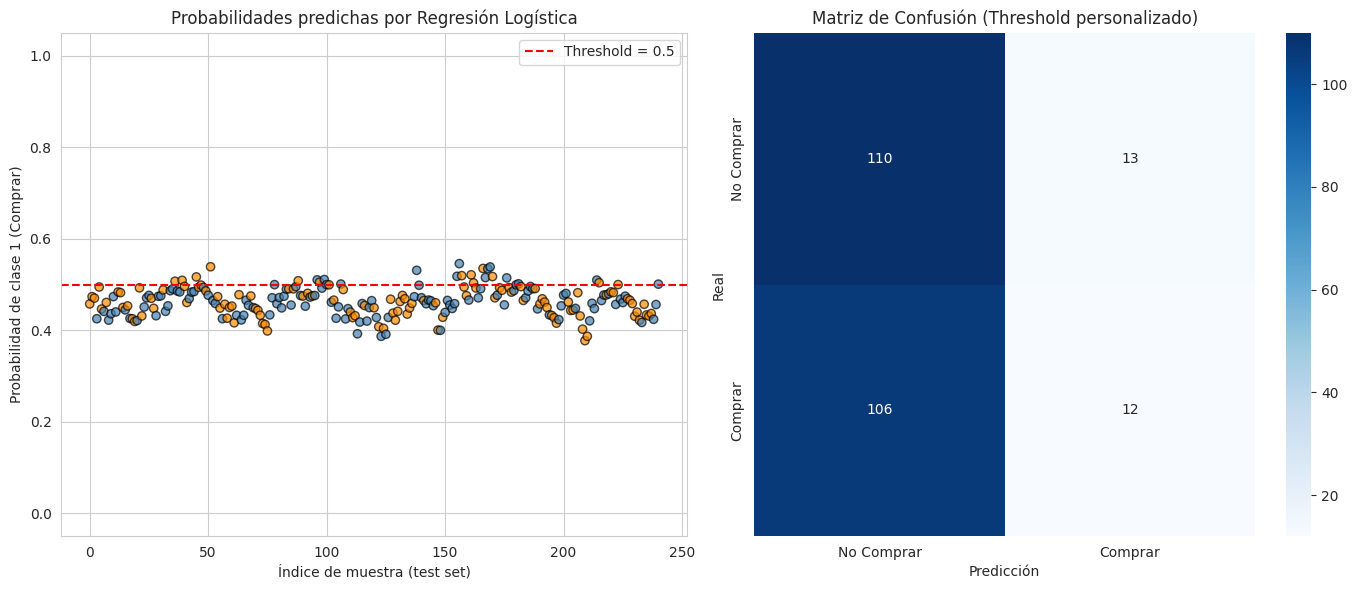

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Probabilidades de clase 1 (Comprar)
y_pred_prob = logreg.predict_proba(X_test_scaled)[:, 1]

# Threshold personalizado
threshold = 0.5  # puedes probar 0.55, 0.6, etc.

# Predicciones binarias según threshold
y_pred_thresh = (y_pred_prob >= threshold).astype(int)

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred_thresh)

# Reporte de clasificación
print("Matriz de confusión:")
print(cm)
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred_thresh, target_names=["No Comprar", "Comprar"]))

# Colores según clase real
colors = np.where(y_test.values == 1, 'darkorange', 'steelblue')

# Plot: Probabilidades vs índice + matriz de confusión
plt.figure(figsize=(14, 6))

# 1️⃣ Dispersión de probabilidades
plt.subplot(1, 2, 1)
plt.scatter(range(len(y_pred_prob)), y_pred_prob, c=colors, edgecolor='k', alpha=0.7)
plt.axhline(threshold, color='red', linestyle='--', label=f'Threshold = {threshold}')
plt.title('Probabilidades predichas por Regresión Logística')
plt.xlabel('Índice de muestra (test set)')
plt.ylabel('Probabilidad de clase 1 (Comprar)')
plt.ylim(-0.05, 1.05)
plt.grid(True)
plt.legend()

# 2️⃣ Matriz de confusión
plt.subplot(1, 2, 2)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["No Comprar", "Comprar"],
            yticklabels=["No Comprar", "Comprar"])
plt.title('Matriz de Confusión (Threshold personalizado)')
plt.xlabel('Predicción')
plt.ylabel('Real')

plt.tight_layout()
plt.show()


#### RandomForest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import pandas as pd

# ===========================
# Configuración
# ===========================
fecha_corte = '2023-01-01'
threshold = 0.5  # ← Cambia el umbral aquí

# ===========================
# Split usando la fecha de corte
# ===========================
df_ta['Date'] = pd.to_datetime(df_ta['Date'])
train_mask = df_ta['Date'] < fecha_corte
test_mask = df_ta['Date'] >= fecha_corte

features = [c for c in df_ta_tech_top.columns if c not in ['Target', 'Date']]

X_train = df_ta_tech_top.loc[train_mask, features]
y_train = df_ta_tech_top.loc[train_mask, 'Target']

X_test = df_ta_tech_top.loc[test_mask, features]
y_test = df_ta_tech_top.loc[test_mask, 'Target']
dates_test = df_ta_tech_top.loc[test_mask, 'Date']

# ===========================
# Definir el espacio de búsqueda
# ===========================
param_dist = {
    'n_estimators': np.arange(100, 1001, 100),
    'max_depth': [None] + list(np.arange(5, 31, 5)),
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

# ===========================
# Random Search con validación cruzada
# ===========================
rf = RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1)

rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=50,
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

rf_random.fit(X_train, y_train)

# ===========================
# Mejor modelo y evaluación
# ===========================
print("Mejores hiperparámetros encontrados:")
print(rf_random.best_params_)

best_rf = rf_random.best_estimator_

# Probabilidades y predicciones con threshold
y_pred_prob = best_rf.predict_proba(X_test)[:, 1]
y_pred_bin = (y_pred_prob >= threshold).astype(int)

# Evaluación
print(f"\n📊 Resultados RandomForest (threshold={threshold}):")
print(confusion_matrix(y_test, y_pred_bin))
print(classification_report(y_test, y_pred_bin, digits=4))
print(f"✅ Accuracy: {accuracy_score(y_test, y_pred_bin):.4f}")

# ===========================
# Guardar predicciones para ensemble
# ===========================
df_pred_tech_rf = pd.DataFrame({
    'Date': dates_test.values,
    'y_real': y_test.values,
    'pred_prob_tech_rf': y_pred_prob,
    'pred_bin_tech_rf': y_pred_bin
})
print(f"📂 Predicciones guardadas para ensemble: {df_pred_tech_rf.shape[0]} filas")
df_pred_tech_rf.head()


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Mejores hiperparámetros encontrados:
{'n_estimators': np.int64(700), 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': None, 'max_depth': np.int64(10), 'bootstrap': False}

📊 Resultados RandomForest (threshold=0.5):
[[87 36]
 [94 24]]
              precision    recall  f1-score   support

           0     0.4807    0.7073    0.5724       123
           1     0.4000    0.2034    0.2697       118

    accuracy                         0.4606       241
   macro avg     0.4403    0.4554    0.4210       241
weighted avg     0.4412    0.4606    0.4242       241

✅ Accuracy: 0.4606
📂 Predicciones guardadas para ensemble: 241 filas


,Date,y_real,pred_prob_tech_rf,pred_bin_tech_rf
0,2023-01-03,1,0.000000,0
1,2023-01-04,1,0.382936,0
2,2023-01-05,1,0.156953,0
3,2023-01-06,0,0.000000,0
4,2023-01-09,1,0.994727,1


#### GRU

In [ ]:
# ============
# GRU (ventana=60) con Top-20 técnicas + threshold configurable
# ============

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# -----------------------------
# Config
# -----------------------------
WINDOW = 60
fecha_corte = '2023-01-01'
threshold = 0.5  # ← cambia el umbral aquí
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# -----------------------------
# Datos: split por fecha y escalado (solo train)
# -----------------------------
df_ta_tech_top = df_ta_tech_top.dropna()
df_ta['Date'] = pd.to_datetime(df_ta['Date'])

mask_train = df_ta['Date'] < fecha_corte
mask_test  = df_ta['Date'] >= fecha_corte

features = [c for c in df_ta_tech_top.columns if c not in ['Target', 'Date']]

X_train_df = df_ta_tech_top.loc[mask_train, features].copy()
y_train_sr = df_ta_tech_top.loc[mask_train, 'Target'].astype(int).copy()

X_test_df = df_ta_tech_top.loc[mask_test, features].copy()
y_test_sr = df_ta_tech_top.loc[mask_test, 'Target'].astype(int).copy()
dates_test = df_ta_tech_top.loc[mask_test, 'Date']

# Escalado
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_df.values)
X_test_scaled  = scaler.transform(X_test_df.values)

# -----------------------------
# Función para crear secuencias
# -----------------------------
def make_sequences(X_2d, y_1d, window=60):
    X_seq, y_seq = [], []
    for i in range(window, len(X_2d)):
        X_seq.append(X_2d[i-window:i, :])
        y_seq.append(y_1d[i])
    return np.asarray(X_seq, dtype=np.float32), np.asarray(y_seq, dtype=np.int32)

X_train_seq, y_train = make_sequences(X_train_scaled, y_train_sr.values, WINDOW)
X_test_seq,  y_test  = make_sequences(X_test_scaled,  y_test_sr.values,  WINDOW)

# -----------------------------
# Holdout validación
# -----------------------------
val_fraction = 0.1
n_train = len(X_train_seq)
n_val = int(np.floor(n_train * val_fraction))
n_tr  = n_train - n_val

X_tr, y_tr = X_train_seq[:n_tr], y_train[:n_tr]
X_val, y_val = X_train_seq[n_tr:], y_train[n_tr:]

# -----------------------------
# Modelo GRU
# -----------------------------
model = keras.Sequential([
    layers.GRU(50, return_sequences=True, input_shape=(WINDOW, X_train_seq.shape[-1])),
    layers.Dropout(0.2),
    layers.GRU(50),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy', keras.metrics.AUC(name='auc')]
)

history = model.fit(
    X_tr, y_tr,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=64,
    shuffle=False,
    verbose=1
)

# -----------------------------
# Predicciones con threshold
# -----------------------------
y_prob = model.predict(X_test_seq).ravel()
y_pred = (y_prob >= threshold).astype(int)

print(f"Accuracy (thr={threshold}): {accuracy_score(y_test, y_pred):.4f}")
print(f"AUC: {roc_auc_score(y_test, y_prob):.4f}")
print("Matriz de confusión:")
print(confusion_matrix(y_test, y_pred))
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred, digits=4))

# -----------------------------
# Guardar predicciones para ensemble
# -----------------------------
df_pred_tech_gru = pd.DataFrame({
    'Date': dates_test.values[WINDOW:],  # ajustar por la ventana
    'y_real': y_test,
    'pred_prob_tech_gru': y_prob,
    'pred_bin_tech_gru': y_pred
})
print(f"📂 Predicciones guardadas para ensemble: {df_pred_tech_gru.shape[0]} filas")
df_pred_tech_gru.head()


Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.4942 - auc: 0.4972 - loss: 0.7052 - val_accuracy: 0.4481 - val_auc: 0.4349 - val_loss: 0.7060
Epoch 2/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5343 - auc: 0.5227 - loss: 0.6973 - val_accuracy: 0.4593 - val_auc: 0.4335 - val_loss: 0.7095
Epoch 3/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5399 - auc: 0.5277 - loss: 0.6931 - val_accuracy: 0.4667 - val_auc: 0.4203 - val_loss: 0.7144
Epoch 4/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5379 - auc: 0.5459 - loss: 0.6902 - val_accuracy: 0.4519 - val_auc: 0.4169 - val_loss: 0.7146
Epoch 5/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5323 - auc: 0.5520 - loss: 0.6885 - val_accuracy: 0.4296 - val_auc: 0.3974 - val_loss: 0.7134
Epoch 6/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5451 - auc: 0.5290 - loss: 0.6942 - val_accuracy: 0.4296 - val_auc: 0.3926 - val_loss: 0.7124
Epoch 7/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accu

1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Accuracy (thr=0.5): 0.5912
AUC: 0.6099
Matriz de confusión:
[[71 23]
 [51 36]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0     0.5820    0.7553    0.6574        94
           1     0.6102    0.4138    0.4932        87

    accuracy                         0.5912       181
   macro avg     0.5961    0.5846    0.5753       181
weighted avg     0.5955    0.5912    0.5785       181

📂 Predicciones guardadas para ensemble: 181 filas


,Date,y_real,pred_prob_tech_gru,pred_bin_tech_gru
0,2023-03-30,1,0.430064,0
1,2023-03-31,1,0.447532,0
2,2023-04-03,0,0.438008,0
3,2023-04-04,1,0.436134,0
4,2023-04-05,0,0.487675,0


Matriz de confusión:
[[71 23]
 [51 36]]

Reporte de clasificación:
              precision    recall  f1-score   support

  No Comprar       0.58      0.76      0.66        94
     Comprar       0.61      0.41      0.49        87

    accuracy                           0.59       181
   macro avg       0.60      0.58      0.58       181
weighted avg       0.60      0.59      0.58       181



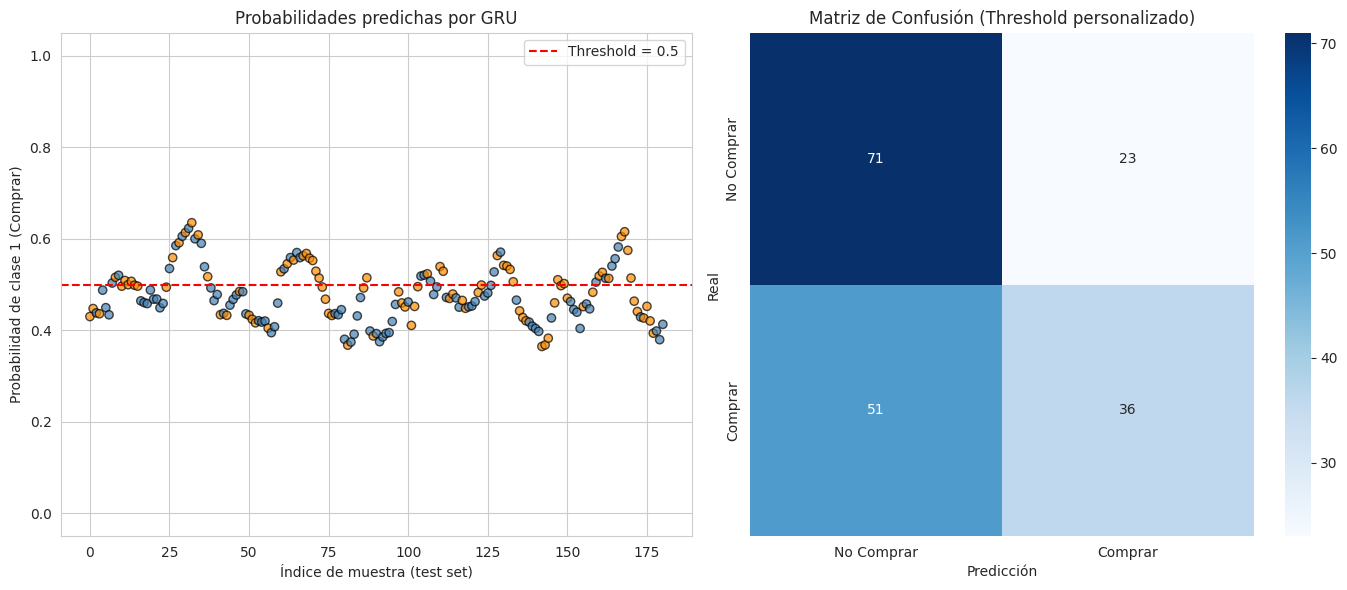

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Probabilidades de clase 1 (Comprar) ya calculadas con el GRU
# y_prob = model.predict(X_test_seq).ravel()

# Threshold personalizado
threshold = 0.5  # puedes cambiarlo a 0.55, 0.6, etc.

# Predicciones binarias según threshold
y_pred_thresh = (y_prob >= threshold).astype(int)

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred_thresh)

# Reporte de clasificación
print("Matriz de confusión:")
print(cm)
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred_thresh, target_names=["No Comprar", "Comprar"]))

# Colores según clase real
colors = np.where(y_test == 1, 'darkorange', 'steelblue')

# Plot: Probabilidades vs índice + matriz de confusión
plt.figure(figsize=(14, 6))

# 1️⃣ Dispersión de probabilidades
plt.subplot(1, 2, 1)
plt.scatter(range(len(y_prob)), y_prob, c=colors, edgecolor='k', alpha=0.7)
plt.axhline(threshold, color='red', linestyle='--', label=f'Threshold = {threshold}')
plt.title('Probabilidades predichas por GRU')
plt.xlabel('Índice de muestra (test set)')
plt.ylabel('Probabilidad de clase 1 (Comprar)')
plt.ylim(-0.05, 1.05)
plt.grid(True)
plt.legend()

# 2️⃣ Matriz de confusión
plt.subplot(1, 2, 2)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["No Comprar", "Comprar"],
            yticklabels=["No Comprar", "Comprar"])
plt.title('Matriz de Confusión (Threshold personalizado)')
plt.xlabel('Predicción')
plt.ylabel('Real')

plt.tight_layout()
plt.show()


#### LSTM

In [ ]:
# ============
# LSTM (ventana=60) con Top-20 técnicas + threshold configurable
# ============

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# -----------------------------
# Configuración
# -----------------------------
WINDOW = 60
fecha_corte = '2023-01-01'
threshold = 0.5  # ← cambia el umbral aquí
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# -----------------------------
# Datos: split por fecha y escalado
# -----------------------------
df_ta_tech_top = df_ta_tech_top.dropna()
df_ta['Date'] = pd.to_datetime(df_ta['Date'])

mask_train = df_ta['Date'] < fecha_corte
mask_test  = df_ta['Date'] >= fecha_corte

features = [c for c in df_ta_tech_top.columns if c not in ['Target', 'Date']]

X_train_df = df_ta_tech_top.loc[mask_train, features].copy()
y_train_sr = df_ta_tech_top.loc[mask_train, 'Target'].astype(int).copy()

X_test_df = df_ta_tech_top.loc[mask_test, features].copy()
y_test_sr = df_ta_tech_top.loc[mask_test, 'Target'].astype(int).copy()
dates_test = df_ta_tech_top.loc[mask_test, 'Date']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_df.values)
X_test_scaled  = scaler.transform(X_test_df.values)

# -----------------------------
# Función para crear ventanas
# -----------------------------
def make_sequences(X_2d, y_1d, window=60):
    X_seq, y_seq = [], []
    for i in range(window, len(X_2d)):
        X_seq.append(X_2d[i-window:i, :])
        y_seq.append(y_1d[i])
    return np.asarray(X_seq, dtype=np.float32), np.asarray(y_seq, dtype=np.int32)

X_train_seq, y_train = make_sequences(X_train_scaled, y_train_sr.values, WINDOW)
X_test_seq,  y_test  = make_sequences(X_test_scaled,  y_test_sr.values,  WINDOW)

# -----------------------------
# Holdout de validación
# -----------------------------
val_fraction = 0.1
n_train = len(X_train_seq)
n_val = int(np.floor(n_train * val_fraction))
n_tr  = n_train - n_val

X_tr, y_tr = X_train_seq[:n_tr], y_train[:n_tr]
X_val, y_val = X_train_seq[n_tr:], y_train[n_tr:]

# -----------------------------
# Modelo LSTM
# -----------------------------
model = keras.Sequential([
    layers.LSTM(50, return_sequences=True, input_shape=(WINDOW, X_train_seq.shape[-1])),
    layers.Dropout(0.2),
    layers.LSTM(50),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy', keras.metrics.AUC(name='auc')]
)

# Early stopping opcional
es = keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=3, restore_best_weights=True
)

history = model.fit(
    X_tr, y_tr,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=64,
    shuffle=False,
    #callbacks=[es],
    verbose=1
)

# -----------------------------
# Predicciones con threshold
# -----------------------------
y_prob = model.predict(X_test_seq).ravel()
y_pred = (y_prob >= threshold).astype(int)

print(f"Accuracy (thr={threshold}): {accuracy_score(y_test, y_pred):.4f}")
print(f"AUC: {roc_auc_score(y_test, y_prob):.4f}")
print("Matriz de confusión:")
print(confusion_matrix(y_test, y_pred))
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred, digits=4))

# -----------------------------
# Guardar predicciones para ensemble
# -----------------------------
df_pred_tech_lstm = pd.DataFrame({
    'Date': dates_test.values[WINDOW:],  # ajustar por la ventana
    'y_real': y_test,
    'pred_prob_tech_lstm': y_prob,
    'pred_bin_tech_lstm': y_pred
})
print(f"📂 Predicciones guardadas para ensemble: {df_pred_tech_lstm.shape[0]} filas")
df_pred_tech_lstm.head()


Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.5042 - auc: 0.4969 - loss: 0.6962 - val_accuracy: 0.5111 - val_auc: 0.5072 - val_loss: 0.6940
Epoch 2/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5483 - auc: 0.5505 - loss: 0.6889 - val_accuracy: 0.4704 - val_auc: 0.4510 - val_loss: 0.7000
Epoch 3/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5551 - auc: 0.5543 - loss: 0.6872 - val_accuracy: 0.4444 - val_auc: 0.4377 - val_loss: 0.7038
Epoch 4/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5585 - auc: 0.5682 - loss: 0.6849 - val_accuracy: 0.4444 - val_auc: 0.4190 - val_loss: 0.7074
Epoch 5/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5585 - auc: 0.5814 - loss: 0.6819 - val_accuracy: 0.4259 - val_auc: 0.4100 - val_loss: 0.7138
Epoch 6/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5726 - auc: 0.5888 - loss: 0.6794 - val_accuracy: 0.4333 - val_auc: 0.4128 - val_loss: 0.7186
Epoch 7/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accu

,Date,y_real,pred_prob_tech_lstm,pred_bin_tech_lstm
0,2023-03-30,1,0.333118,0
1,2023-03-31,1,0.338678,0
2,2023-04-03,0,0.339426,0
3,2023-04-04,1,0.342841,0
4,2023-04-05,0,0.362422,0


Matriz de confusión:
[[57 37]
 [46 41]]

Reporte de clasificación:
              precision    recall  f1-score   support

  No Comprar       0.55      0.61      0.58        94
     Comprar       0.53      0.47      0.50        87

    accuracy                           0.54       181
   macro avg       0.54      0.54      0.54       181
weighted avg       0.54      0.54      0.54       181



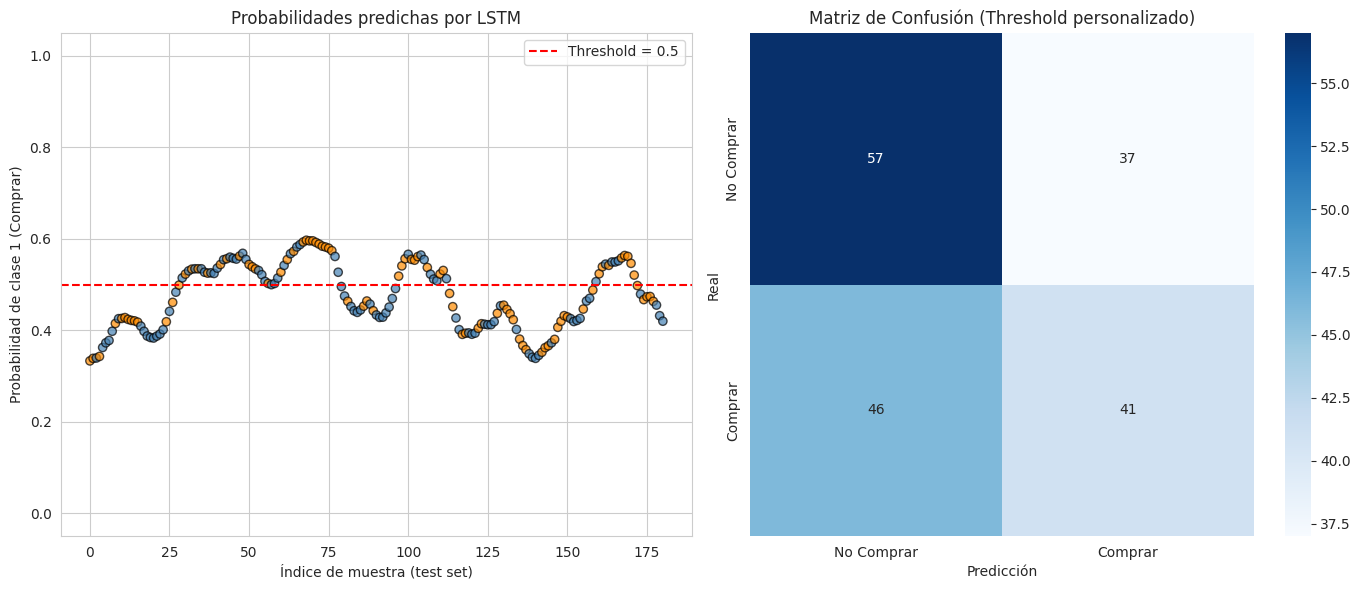

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Probabilidades de clase 1 (Comprar) ya calculadas con el LSTM
# y_prob = model.predict(X_test_seq).ravel()

# Threshold personalizado
threshold = 0.5  # cambia a 0.55, 0.6, etc.

# Predicciones binarias según threshold
y_pred_thresh = (y_prob >= threshold).astype(int)

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred_thresh)

# Reporte de clasificación
print("Matriz de confusión:")
print(cm)
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred_thresh, target_names=["No Comprar", "Comprar"]))

# Colores según clase real
colors = np.where(y_test == 1, 'darkorange', 'steelblue')

# Plot: Probabilidades vs índice + matriz de confusión
plt.figure(figsize=(14, 6))

# 1️⃣ Dispersión de probabilidades
plt.subplot(1, 2, 1)
plt.scatter(range(len(y_prob)), y_prob, c=colors, edgecolor='k', alpha=0.7)
plt.axhline(threshold, color='red', linestyle='--', label=f'Threshold = {threshold}')
plt.title('Probabilidades predichas por LSTM')
plt.xlabel('Índice de muestra (test set)')
plt.ylabel('Probabilidad de clase 1 (Comprar)')
plt.ylim(-0.05, 1.05)
plt.grid(True)
plt.legend()

# 2️⃣ Matriz de confusión
plt.subplot(1, 2, 2)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["No Comprar", "Comprar"],
            yticklabels=["No Comprar", "Comprar"])
plt.title('Matriz de Confusión (Threshold personalizado)')
plt.xlabel('Predicción')
plt.ylabel('Real')

plt.tight_layout()
plt.show()


## Modelo Completo

In [ ]:
# ==========================
# Dataset combinado: top-20 técnicas + sentiment
# ==========================

# Variables de sentimiento
sentiment_features = [
    'mean_sentiment_score',
    'mean_sentiment_value',
    'mean_sentiment_positive_prob',
    'mean_sentiment_negative_prob',
    'mean_sentiment_neutral_prob',
    'mean_weighted_score_value',
    'dominant_sentiment_strength',
    'sentiment_direction',
    'sentiment_bias',
    'std_sentiment_value'
]

# Dataset combinado
df_combined = df_ta[top_features + sentiment_features + ['Target', 'Date']].copy()

# Eliminar posibles NaN
df_combined = df_combined.dropna()

print(f"📊 Dataset combinado: {df_combined.shape[0]} filas y {df_combined.shape[1]} columnas")
df_combined.head()


📊 Dataset combinado: 1958 filas y 32 columnas


,volume_em,trend_dpo,volume_obv,Volume,return,others_dlr,momentum_pvo_hist,others_dr,momentum_uo,trend_mass_index,...,mean_sentiment_positive_prob,mean_sentiment_negative_prob,mean_sentiment_neutral_prob,mean_weighted_score_value,dominant_sentiment_strength,sentiment_direction,sentiment_bias,std_sentiment_value,Target,Date
2,0.009449,40.465587,17172600,16801200,-0.001169,-0.116926,-1.158167,-0.116857,38.246945,2.925920,...,0.666620,0.333379,5.615664e-07,0.333333,1.0,1.0,0.5,0.57735,1,2012-01-09
3,1.141324,40.327095,47282600,30110000,0.035572,3.495401,3.365967,3.557208,51.452183,4.073119,...,0.999891,0.000106,2.820156e-06,0.000000,0.0,0.0,0.0,0.00000,1,2012-01-10
7,0.993064,39.967515,83828200,24215200,0.030519,3.006275,1.623739,3.051920,72.698650,8.308314,...,0.999585,0.000119,2.960285e-04,0.000000,0.0,0.0,0.0,0.00000,1,2012-01-17
8,0.779410,39.833767,110120600,26292400,0.027021,2.666231,3.382215,2.702093,77.046156,9.433575,...,0.999805,0.000061,1.340255e-04,0.000000,0.0,0.0,0.0,0.00000,0,2012-01-18
9,0.110231,39.737330,86062600,24058000,-0.006314,-0.633411,3.517617,-0.631409,76.517440,10.455551,...,0.659014,0.017039,3.239464e-01,-0.323901,1.0,-1.0,-0.5,0.57735,1,2012-01-19


#### Regresión Logística

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# ==========================
# Configuración
# ==========================
fecha_corte = '2023-01-01'
threshold = 0.5  # ← puedes cambiar el umbral aquí

# ==========================
# Máscaras por fecha
# ==========================
df_combined['Date'] = pd.to_datetime(df_combined['Date'])
train_mask = df_combined['Date'] < fecha_corte
test_mask = df_combined['Date'] >= fecha_corte

# ==========================
# Features
# ==========================
features = [c for c in df_combined.columns if c not in ['Target', 'Date']]

X_train = df_combined.loc[train_mask, features]
y_train = df_combined.loc[train_mask, 'Target']

X_test = df_combined.loc[test_mask, features]
y_test = df_combined.loc[test_mask, 'Target']
dates_test = df_combined.loc[test_mask, 'Date']

# ==========================
# Escalado
# ==========================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ==========================
# Modelo
# ==========================
logreg = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
logreg.fit(X_train_scaled, y_train)

# ==========================
# Predicciones con threshold
# ==========================
y_pred_prob = logreg.predict_proba(X_test_scaled)[:, 1]
y_pred = (y_pred_prob >= threshold).astype(int)

# ==========================
# Evaluación
# ==========================
print(f"Accuracy (thr={threshold}): {accuracy_score(y_test, y_pred):.4f}")
print("Matriz de confusión:")
print(confusion_matrix(y_test, y_pred))
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred, digits=4))

# ==========================
# Guardar predicciones para ensemble
# ==========================
df_pred_combined_logreg = pd.DataFrame({
    'Date': dates_test.values,
    'y_real': y_test.values,
    'pred_prob_combined_logreg': y_pred_prob,
    'pred_bin_combined_logreg': y_pred
})
print(f"📂 Predicciones guardadas para ensemble: {df_pred_combined_logreg.shape[0]} filas")
df_pred_combined_logreg.head()


Accuracy (thr=0.5): 0.5242
Matriz de confusión:
[[55  4]
 [55 10]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0     0.5000    0.9322    0.6509        59
           1     0.7143    0.1538    0.2532        65

    accuracy                         0.5242       124
   macro avg     0.6071    0.5430    0.4520       124
weighted avg     0.6123    0.5242    0.4424       124

📂 Predicciones guardadas para ensemble: 124 filas


,Date,y_real,pred_prob_combined_logreg,pred_bin_combined_logreg
0,2023-01-04,1,0.510231,1
1,2023-01-11,0,0.393537,0
2,2023-01-17,0,0.394758,0
3,2023-01-18,0,0.425860,0
4,2023-01-23,1,0.426735,0


#### RandomForest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import pandas as pd

# ==========================
# Configuración
# ==========================
fecha_corte = '2023-01-01'
threshold = 0.5  # ← cambia aquí el umbral

# ==========================
# Máscaras por fecha
# ==========================
df_combined['Date'] = pd.to_datetime(df_combined['Date'])
train_mask = df_combined['Date'] < fecha_corte
test_mask = df_combined['Date'] >= fecha_corte

# ==========================
# Features y split
# ==========================
features = [c for c in df_combined.columns if c not in ['Target', 'Date']]

X_train = df_combined.loc[train_mask, features]
y_train = df_combined.loc[train_mask, 'Target']

X_test = df_combined.loc[test_mask, features]
y_test = df_combined.loc[test_mask, 'Target']
dates_test = df_combined.loc[test_mask, 'Date']

# ==========================
# Espacio de búsqueda de hiperparámetros
# ==========================
param_dist = {
    'n_estimators': np.arange(100, 1001, 100),
    'max_depth': [None] + list(np.arange(5, 31, 5)),
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

# ==========================
# RandomizedSearchCV
# ==========================
rf = RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1)

rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=50,
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

rf_random.fit(X_train, y_train)

# ==========================
# Mejor modelo y evaluación
# ==========================
print("Mejores hiperparámetros encontrados:")
print(rf_random.best_params_)

best_rf = rf_random.best_estimator_

y_pred_prob = best_rf.predict_proba(X_test)[:, 1]
y_pred = (y_pred_prob >= threshold).astype(int)

print(f"\nAccuracy en test (thr={threshold}): {accuracy_score(y_test, y_pred):.4f}")
print("Matriz de confusión:")
print(confusion_matrix(y_test, y_pred))
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred, digits=4))

# ==========================
# Guardar predicciones para ensemble
# ==========================
df_pred_combined_rf = pd.DataFrame({
    'Date': dates_test.values,
    'y_real': y_test.values,
    'pred_prob_combined_rf': y_pred_prob,
    'pred_bin_combined_rf': y_pred
})
print(f"📂 Predicciones guardadas para ensemble: {df_pred_combined_rf.shape[0]} filas")
df_pred_combined_rf.head()


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Mejores hiperparámetros encontrados:
{'n_estimators': np.int64(900), 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': None, 'max_depth': None, 'bootstrap': False}

Accuracy en test (thr=0.5): 0.4597
Matriz de confusión:
[[36 23]
 [44 21]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0     0.4500    0.6102    0.5180        59
           1     0.4773    0.3231    0.3853        65

    accuracy                         0.4597       124
   macro avg     0.4636    0.4666    0.4517       124
weighted avg     0.4643    0.4597    0.4484       124

📂 Predicciones guardadas para ensemble: 124 filas


,Date,y_real,pred_prob_combined_rf,pred_bin_combined_rf
0,2023-01-04,1,0.476009,0
1,2023-01-11,0,0.377187,0
2,2023-01-17,0,0.597723,1
3,2023-01-18,0,0.903661,1
4,2023-01-23,1,1.000000,1


#### GRU

In [ ]:
# ============
# GRU (ventana=60) con dataset combinado y guardado de predicciones
# ============

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# -----------------------------
# Configuración
# -----------------------------
WINDOW = 30
fecha_corte = '2023-01-01'
SEED = 42
threshold = 0.5  # ← cambia aquí el umbral para comprar/no comprar

np.random.seed(SEED)
tf.random.set_seed(SEED)

# -----------------------------
# Preparar datos
# -----------------------------
df_combined = df_combined.dropna()
df_combined['Date'] = pd.to_datetime(df_combined['Date'])

mask_train = df_combined['Date'] < fecha_corte
mask_test  = df_combined['Date'] >= fecha_corte

features = [c for c in df_combined.columns if c not in ['Target', 'Date']]

X_train_df = df_combined.loc[mask_train, features]
y_train_sr = df_combined.loc[mask_train, 'Target'].astype(int)

X_test_df = df_combined.loc[mask_test, features]
y_test_sr = df_combined.loc[mask_test, 'Target'].astype(int)
dates_test = df_combined.loc[mask_test, 'Date'].values

# Escalar (solo con train)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_df)
X_test_scaled  = scaler.transform(X_test_df)

# -----------------------------
# Crear secuencias
# -----------------------------
def make_sequences(X_2d, y_1d, window=60):
    X_seq, y_seq = [], []
    for i in range(window, len(X_2d)):
        X_seq.append(X_2d[i-window:i, :])
        y_seq.append(y_1d[i])
    return np.asarray(X_seq, dtype=np.float32), np.asarray(y_seq, dtype=np.int32)

X_train_seq, y_train = make_sequences(X_train_scaled, y_train_sr.values, WINDOW)
X_test_seq,  y_test  = make_sequences(X_test_scaled,  y_test_sr.values,  WINDOW)

# Ajustar también las fechas a la secuencia
dates_test_seq = dates_test[WINDOW:]

# -----------------------------
# Validación (último 10% del train)
# -----------------------------
val_fraction = 0.1
n_train = len(X_train_seq)
n_val = int(np.floor(n_train * val_fraction))
n_tr  = n_train - n_val

X_tr, y_tr = X_train_seq[:n_tr], y_train[:n_tr]
X_val, y_val = X_train_seq[n_tr:], y_train[n_tr:]

# -----------------------------
# Modelo GRU
# -----------------------------
model = keras.Sequential([
    layers.GRU(50, return_sequences=True, input_shape=(WINDOW, X_train_seq.shape[-1])),
    layers.Dropout(0.2),
    layers.GRU(50),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy', keras.metrics.AUC(name='auc')]
)

# Early stopping
es = keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=3, restore_best_weights=True
)

history = model.fit(
    X_tr, y_tr,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=64,
    shuffle=False,
    verbose=1
)

# -----------------------------
# Evaluación
# -----------------------------
y_prob = model.predict(X_test_seq).ravel()
y_pred = (y_prob >= threshold).astype(int)

print(f"Accuracy (thr={threshold}): {accuracy_score(y_test, y_pred):.4f}")
print(f"AUC: {roc_auc_score(y_test, y_prob):.4f}")
print("Matriz de confusión:")
print(confusion_matrix(y_test, y_pred))
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred, digits=4))

# -----------------------------
# Guardar predicciones para ensemble
# -----------------------------
df_pred_combined_gru = pd.DataFrame({
    'Date': dates_test_seq,
    'y_real': y_test,
    'pred_prob_combined_gru': y_prob,
    'pred_bin_combined_gru': y_pred
})
print(f"📂 Predicciones guardadas para ensemble: {df_pred_combined_gru.shape[0]} filas")
df_pred_combined_gru.head()


Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.5285 - auc: 0.5332 - loss: 0.6969 - val_accuracy: 0.5500 - val_auc: 0.5516 - val_loss: 0.6959
Epoch 2/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5450 - auc: 0.5324 - loss: 0.6975 - val_accuracy: 0.5611 - val_auc: 0.5458 - val_loss: 0.6926
Epoch 3/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5720 - auc: 0.5724 - loss: 0.6834 - val_accuracy: 0.5611 - val_auc: 0.5485 - val_loss: 0.6946
Epoch 4/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5341 - auc: 0.5422 - loss: 0.6891 - val_accuracy: 0.5667 - val_auc: 0.5520 - val_loss: 0.6954
Epoch 5/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5769 - auc: 0.5933 - loss: 0.6756 - val_accuracy: 0.5444 - val_auc: 0.5467 - val_loss: 0.6968
Epoch 6/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5628 - auc: 0.5918 - loss: 0.6767 - val_accuracy: 0.5444 - val_auc: 0.5510 - val_loss: 0.6958
Epoch 7/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accu

,Date,y_real,pred_prob_combined_gru,pred_bin_combined_gru
0,2023-04-03,0,0.411195,0
1,2023-04-05,0,0.391491,0
2,2023-04-06,0,0.325198,0
3,2023-04-12,1,0.356315,0
4,2023-04-18,1,0.410379,0


Matriz de confusión:
[[35 11]
 [26 22]]

Reporte de clasificación:
              precision    recall  f1-score   support

  No Comprar       0.57      0.76      0.65        46
     Comprar       0.67      0.46      0.54        48

    accuracy                           0.61        94
   macro avg       0.62      0.61      0.60        94
weighted avg       0.62      0.61      0.60        94



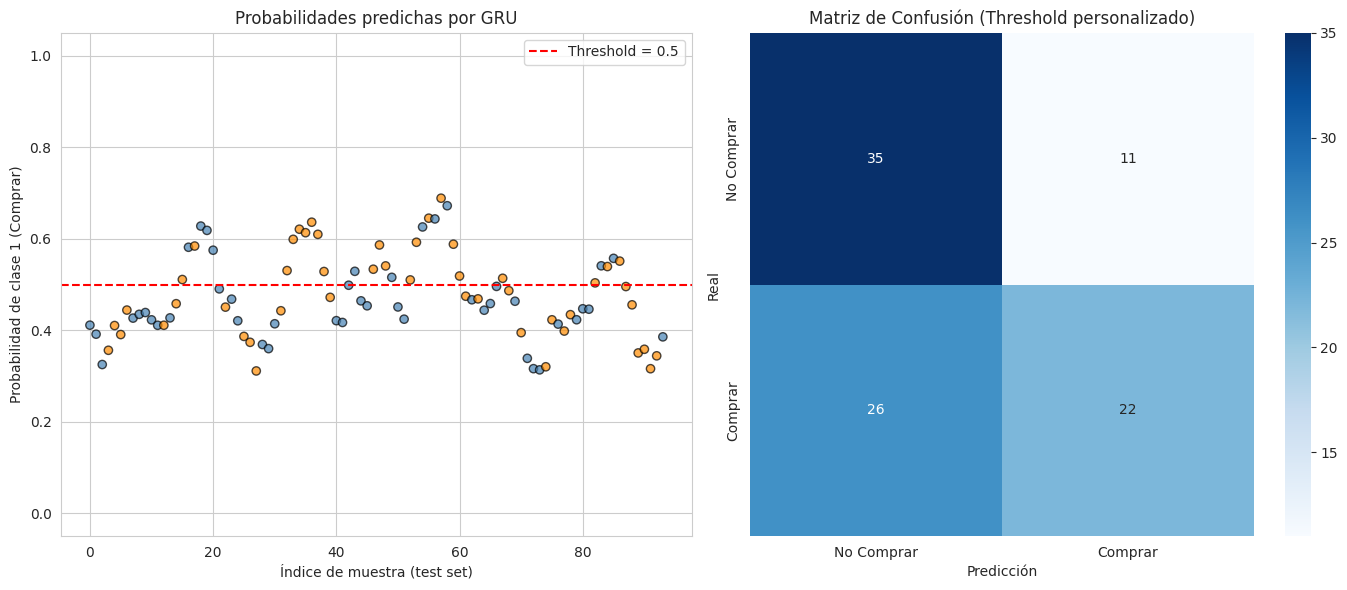

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Probabilidades de clase 1 (Comprar) ya calculadas con el GRU
# y_prob = model.predict(X_test_seq).ravel()

# Threshold personalizado
threshold = 0.5  # puedes cambiarlo a 0.55, 0.6, etc.

# Predicciones binarias según threshold
y_pred_thresh = (y_prob >= threshold).astype(int)

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred_thresh)

# Reporte de clasificación
print("Matriz de confusión:")
print(cm)
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred_thresh, target_names=["No Comprar", "Comprar"]))

# Colores según clase real
colors = np.where(y_test == 1, 'darkorange', 'steelblue')

# Plot: Probabilidades vs índice + matriz de confusión
plt.figure(figsize=(14, 6))

# 1️⃣ Dispersión de probabilidades
plt.subplot(1, 2, 1)
plt.scatter(range(len(y_prob)), y_prob, c=colors, edgecolor='k', alpha=0.7)
plt.axhline(threshold, color='red', linestyle='--', label=f'Threshold = {threshold}')
plt.title('Probabilidades predichas por GRU')
plt.xlabel('Índice de muestra (test set)')
plt.ylabel('Probabilidad de clase 1 (Comprar)')
plt.ylim(-0.05, 1.05)
plt.grid(True)
plt.legend()

# 2️⃣ Matriz de confusión
plt.subplot(1, 2, 2)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["No Comprar", "Comprar"],
            yticklabels=["No Comprar", "Comprar"])
plt.title('Matriz de Confusión (Threshold personalizado)')
plt.xlabel('Predicción')
plt.ylabel('Real')

plt.tight_layout()
plt.show()


#### LSTM

In [ ]:
# ============
# LSTM (ventana=60) con dataset combinado y guardado de predicciones
# ============

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# -----------------------------
# Configuración
# -----------------------------
WINDOW = 60
fecha_corte = '2023-01-01'
SEED = 42
threshold = 0.5  # ← cambia aquí el umbral para comprar/no comprar

np.random.seed(SEED)
tf.random.set_seed(SEED)

# -----------------------------
# Preparar datos
# -----------------------------
df_combined = df_combined.dropna()
df_combined['Date'] = pd.to_datetime(df_combined['Date'])

mask_train = df_combined['Date'] < fecha_corte
mask_test  = df_combined['Date'] >= fecha_corte

features = [c for c in df_combined.columns if c not in ['Target', 'Date']]

X_train_df = df_combined.loc[mask_train, features]
y_train_sr = df_combined.loc[mask_train, 'Target'].astype(int)

X_test_df = df_combined.loc[mask_test, features]
y_test_sr = df_combined.loc[mask_test, 'Target'].astype(int)
dates_test = df_combined.loc[mask_test, 'Date'].values

# Escalar
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_df)
X_test_scaled  = scaler.transform(X_test_df)

# -----------------------------
# Crear secuencias
# -----------------------------
def make_sequences(X_2d, y_1d, window=60):
    X_seq, y_seq = [], []
    for i in range(window, len(X_2d)):
        X_seq.append(X_2d[i-window:i, :])
        y_seq.append(y_1d[i])
    return np.asarray(X_seq, dtype=np.float32), np.asarray(y_seq, dtype=np.int32)

X_train_seq, y_train = make_sequences(X_train_scaled, y_train_sr.values, WINDOW)
X_test_seq,  y_test  = make_sequences(X_test_scaled,  y_test_sr.values,  WINDOW)

# Ajustar también las fechas a la secuencia
dates_test_seq = dates_test[WINDOW:]

# -----------------------------
# Validación (último 10% del train)
# -----------------------------
val_fraction = 0.1
n_train = len(X_train_seq)
n_val = int(np.floor(n_train * val_fraction))
n_tr  = n_train - n_val

X_tr, y_tr = X_train_seq[:n_tr], y_train[:n_tr]
X_val, y_val = X_train_seq[n_tr:], y_train[n_tr:]

# -----------------------------
# Modelo LSTM
# -----------------------------
model = keras.Sequential([
    layers.LSTM(50, return_sequences=True, input_shape=(WINDOW, X_train_seq.shape[-1])),
    layers.Dropout(0.2),
    layers.LSTM(50),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy', keras.metrics.AUC(name='auc')]
)

# Early stopping
es = keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=3, restore_best_weights=True
)

history = model.fit(
    X_tr, y_tr,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=64,
    shuffle=False,
    verbose=1
)

# -----------------------------
# Evaluación
# -----------------------------
y_prob = model.predict(X_test_seq).ravel()
y_pred = (y_prob >= threshold).astype(int)

print(f"Accuracy (thr={threshold}): {accuracy_score(y_test, y_pred):.4f}")
print(f"AUC: {roc_auc_score(y_test, y_prob):.4f}")
print("Matriz de confusión:")
print(confusion_matrix(y_test, y_pred))
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred, digits=4))

# -----------------------------
# Guardar predicciones para ensemble
# -----------------------------
df_pred_combined_lstm = pd.DataFrame({
    'Date': dates_test_seq,
    'y_real': y_test,
    'pred_prob_combined_lstm': y_prob,
    'pred_bin_combined_lstm': y_pred
})
print(f"📂 Predicciones guardadas para ensemble: {df_pred_combined_lstm.shape[0]} filas")
df_pred_combined_lstm.head()


Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.5107 - auc: 0.5116 - loss: 0.6932 - val_accuracy: 0.5085 - val_auc: 0.4830 - val_loss: 0.6966
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5701 - auc: 0.5891 - loss: 0.6799 - val_accuracy: 0.5028 - val_auc: 0.4588 - val_loss: 0.7015
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5986 - auc: 0.6313 - loss: 0.6709 - val_accuracy: 0.5028 - val_auc: 0.4501 - val_loss: 0.7077
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5896 - auc: 0.6220 - loss: 0.6690 - val_accuracy: 0.4859 - val_auc: 0.4577 - val_loss: 0.7100
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6163 - auc: 0.6492 - loss: 0.6585 - val_accuracy: 0.4859 - val_auc: 0.4653 - val_loss: 0.7156
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6174 - auc: 0.6529 - loss: 0.6577 - val_accuracy: 0.4802 - val_auc: 0.4794 - val_loss: 0.7169
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accu

,Date,y_real,pred_prob_combined_lstm,pred_bin_combined_lstm
0,2023-06-30,0,0.521845,1
1,2023-07-03,1,0.548124,1
2,2023-07-10,1,0.605296,1
3,2023-07-11,1,0.647965,1
4,2023-07-12,1,0.663595,1


Matriz de confusión:
[[19  9]
 [16 20]]

Reporte de clasificación:
              precision    recall  f1-score   support

  No Comprar       0.54      0.68      0.60        28
     Comprar       0.69      0.56      0.62        36

    accuracy                           0.61        64
   macro avg       0.62      0.62      0.61        64
weighted avg       0.63      0.61      0.61        64



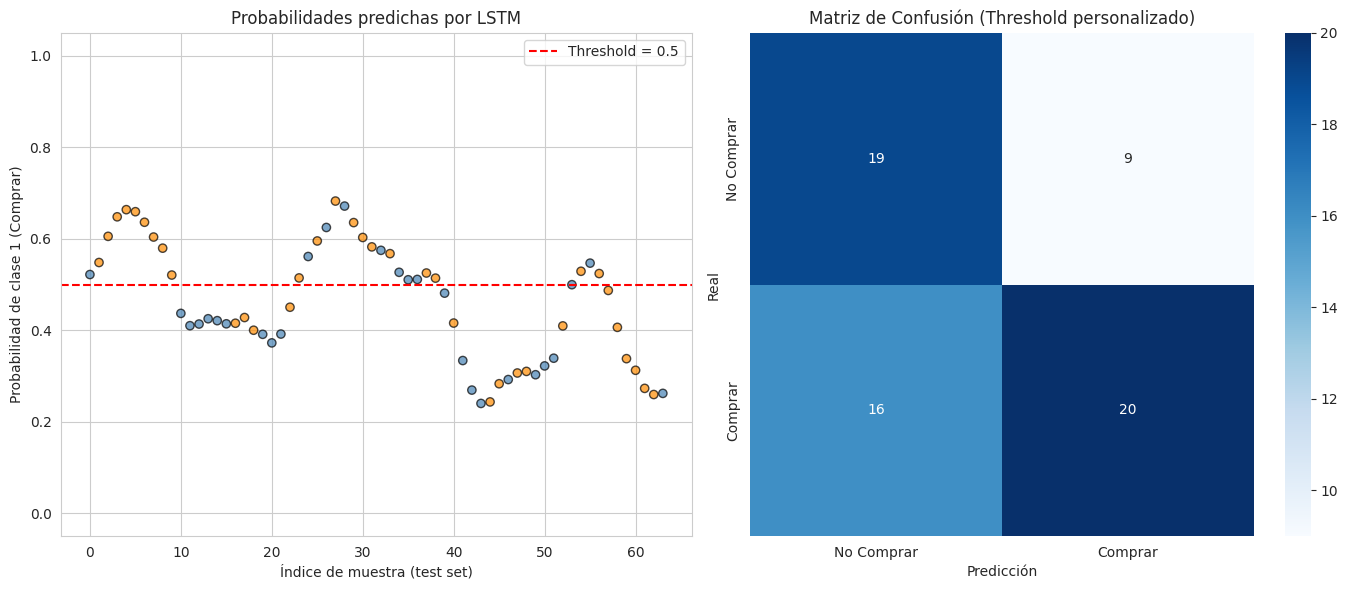

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# y_prob debe venir del modelo LSTM, por ejemplo:
# y_prob = model.predict(X_test_seq).ravel()

# Threshold personalizado
threshold = 0.5  # prueba con 0.55, 0.6, etc.

# Predicciones binarias
y_pred_thresh = (y_prob >= threshold).astype(int)

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred_thresh)

# Reporte de clasificación
print("Matriz de confusión:")
print(cm)
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred_thresh, target_names=["No Comprar", "Comprar"]))

# Colores según clase real
colors = np.where(y_test == 1, 'darkorange', 'steelblue')

# Plot: Probabilidades vs índice + matriz de confusión
plt.figure(figsize=(14, 6))

# 1️⃣ Gráfico de dispersión de probabilidades
plt.subplot(1, 2, 1)
plt.scatter(range(len(y_prob)), y_prob, c=colors, edgecolor='k', alpha=0.7)
plt.axhline(threshold, color='red', linestyle='--', label=f'Threshold = {threshold}')
plt.title('Probabilidades predichas por LSTM')
plt.xlabel('Índice de muestra (test set)')
plt.ylabel('Probabilidad de clase 1 (Comprar)')
plt.ylim(-0.05, 1.05)
plt.grid(True)
plt.legend()

# 2️⃣ Matriz de confusión
plt.subplot(1, 2, 2)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["No Comprar", "Comprar"],
            yticklabels=["No Comprar", "Comprar"])
plt.title('Matriz de Confusión (Threshold personalizado)')
plt.xlabel('Predicción')
plt.ylabel('Real')

plt.tight_layout()
plt.show()


## Modelo Ensemble

## Comparación de modelos y Conclusiones

# MODELOS DE REGRESIÓN
Cuando definimos la variable objetivo (**Target**) como el **retorno logarítmico**:

$$
r_t = \ln\left(\frac{P_{t+1}}{P_t}\right)
$$

la señal es fácil de interpretar:

- **r_t > 0** → el precio esperado para el día siguiente \( P_{t+1} \) es **mayor** que el actual \( P_t \) ⇒ señal de **compra**.  
- **r_t < 0** → el precio esperado para el día siguiente es **menor** ⇒ señal de **venta** o **no compra**.  
- **r_t = 0** → se espera que el precio se mantenga igual.  

Esto mismo se aplica a las predicciones del modelo (`y_pred`):

- Si `y_pred > 0` ⇒ comprar.  
- Si `y_pred <= 0` ⇒ no comprar / vender.  

### Ajuste del umbral

Podemos usar un **threshold** para filtrar cambios pequeños y reducir ruido:

- Comprar si `y_pred > 0.001` (subida > 0.1 %).  
- Vender si `y_pred < -0.001` (bajada > 0.1 %).  

Esto ayuda a evitar operar ante fluctuaciones insignificantes.



In [ ]:
# ==========================
# Crear target de regresión como rendimiento logarítmico
# ==========================

# Copia del DataFrame original
df_reg = df_ta.copy()

# Eliminar la Target anterior si existe
if 'Target' in df_reg.columns:
    df_reg = df_reg.drop(columns=['Target'])

# Nueva target: rendimiento logarítmico del cierre
df_reg['Target'] = np.log(df_reg['Close'].shift(-1) / df_reg['Close'])

# Eliminar la última fila (porque la target será NaN al no haber día siguiente)
df_reg = df_reg.dropna(subset=['Target']).reset_index(drop=True)

print(f"📊 Dataset para regresión: {df_reg.shape[0]} filas y {df_reg.shape[1]} columnas")
df_reg.head()



📊 Dataset para regresión: 3006 filas y 109 columnas


,Date,Open,High,Low,Close,Volume,mean_sentiment_score,mean_sentiment_value,min_sentiment_value,max_sentiment_value,...,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr,return,Target
0,2012-01-05,14.802211,15.129663,14.788127,14.971218,18431800,0.579639,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,14.971218,0.000000,0.000000,0.000000,NaN,0.006096
1,2012-01-06,14.921926,15.175436,14.858548,15.062764,15542000,NaN,NaN,NaN,NaN,...,0.039006,-1.265389,-0.253078,-1.012312,15.009423,0.611480,0.609618,0.611480,0.006115,-0.001169
2,2012-01-09,14.960659,15.136709,14.911364,15.045162,16801200,0.999954,0.333333,0.0,1.0,...,0.053800,-1.700787,-0.542620,-1.158167,15.024484,-0.116857,-0.116926,0.493908,-0.001169,0.034954
3,2012-01-10,15.175436,15.858508,15.119101,15.580350,30110000,0.999891,0.000000,0.0,0.0,...,0.287103,3.664840,0.298872,3.365967,15.242932,3.557208,3.495401,4.068686,0.035572,0.003384
4,2012-01-11,15.513447,15.703579,15.414859,15.633161,15471000,NaN,NaN,NaN,NaN,...,0.438450,1.641438,0.567385,1.074052,15.400164,0.338957,0.338384,4.421434,0.003390,0.011199


## Análisis de sentimientos

In [ ]:
# ==========================
# Filtrar solo análisis de sentimientos + Target + Date
# ==========================

sentiment_features = [
    'mean_sentiment_score',
    'mean_sentiment_value',
    'mean_sentiment_positive_prob',
    'mean_sentiment_negative_prob',
    'mean_sentiment_neutral_prob',
    'mean_weighted_score_value',
    'dominant_sentiment_strength',
    'sentiment_direction',
    'sentiment_bias',
    'std_sentiment_value'
]


# Añadimos Close
features = sentiment_features + ['Close']

df_reg_sentiment = df_reg[features + ['Target', 'Date']].copy()

print(f"📊 Dataset solo sentimiento: {df_reg_sentiment.shape[0]} filas y {df_reg_sentiment.shape[1]} columnas")
df_reg_sentiment.head()


📊 Dataset solo sentimiento: 3006 filas y 13 columnas


,mean_sentiment_score,mean_sentiment_value,mean_sentiment_positive_prob,mean_sentiment_negative_prob,mean_sentiment_neutral_prob,mean_weighted_score_value,dominant_sentiment_strength,sentiment_direction,sentiment_bias,std_sentiment_value,Close,Target,Date
0,0.579639,0.000000,0.579638,0.420133,2.295656e-04,0.000000,0.0,0.0,0.0,NaN,14.971218,0.006096,2012-01-05
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.062764,-0.001169,2012-01-06
2,0.999954,0.333333,0.666620,0.333379,5.615664e-07,0.333333,1.0,1.0,0.5,0.57735,15.045162,0.034954,2012-01-09
3,0.999891,0.000000,0.999891,0.000106,2.820156e-06,0.000000,0.0,0.0,0.0,0.00000,15.580350,0.003384,2012-01-10
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.633161,0.011199,2012-01-11


#### RandomForest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report, confusion_matrix
import numpy as np
import pandas as pd

# ==========================
# Configuración
# ==========================
fecha_corte = '2023-01-01'
threshold_log = 0  # cualquier subida → compra

# ==========================
# Máscaras por fecha
# ==========================
train_mask = df_reg_sentiment['Date'] < fecha_corte
test_mask  = df_reg_sentiment['Date'] >= fecha_corte

# ==========================
# Features: excluir Target y Date
# ==========================
features = [c for c in df_reg_sentiment.columns if c not in ['Target', 'Date']]

# ==========================
# Train/Test split
# ==========================
X_train = df_reg_sentiment.loc[train_mask, features]
y_train = df_reg_sentiment.loc[train_mask, 'Target']

X_test = df_reg_sentiment.loc[test_mask, features]
y_test = df_reg_sentiment.loc[test_mask, 'Target']
dates_test = df_reg_sentiment.loc[test_mask, 'Date'].values

# ==========================
# Espacio de búsqueda de hiperparámetros
# ==========================
param_dist = {
    'n_estimators': np.arange(100, 1001, 100),
    'max_depth': [None] + list(np.arange(5, 31, 5)),
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

# ==========================
# RandomizedSearchCV
# ==========================
rf_reg = RandomForestRegressor(random_state=42, n_jobs=-1)

rf_random = RandomizedSearchCV(
    estimator=rf_reg,
    param_distributions=param_dist,
    n_iter=50,
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

rf_random.fit(X_train, y_train)

# ==========================
# Mejor modelo
# ==========================
print("Mejores hiperparámetros encontrados:")
print(rf_random.best_params_)

best_rf = rf_random.best_estimator_

# ==========================
# Predicciones y métricas de regresión
# ==========================
y_pred = best_rf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.6f}")
print(f"R²: {r2:.6f}")

# ==========================
# Conversión a clasificación usando variación logarítmica
# ==========================
y_test_shift = np.roll(y_test, 1)
y_pred_shift = np.roll(y_pred, 1)

# Evitar primer valor sin referencia
y_test_logret = np.log(y_test / y_test_shift)[1:]
y_pred_logret = np.log(y_pred / y_pred_shift)[1:]

y_test_bin = (y_test_logret > threshold_log).astype(int)
y_pred_bin = (y_pred_logret > threshold_log).astype(int)

dates_test_bin = dates_test[1:]

# ==========================
# Métricas de clasificación
# ==========================
print(f"\nClasificación Buy/Sell con threshold log={threshold_log}")
print(f"Accuracy: {accuracy_score(y_test_bin, y_pred_bin):.4f}")
print("Matriz de confusión:")
print(confusion_matrix(y_test_bin, y_pred_bin))
print("\nReporte de clasificación:")
print(classification_report(y_test_bin, y_pred_bin, digits=4))

# ==========================
# Guardar predicciones para ensemble
# ==========================
df_pred_reg_sentiment_rf = pd.DataFrame({
    'Date': dates_test_bin,
    'y_real_price': y_test[1:],
    'y_real_logret': y_test_logret,
    'y_real_bin': y_test_bin,
    'y_pred_price': y_pred[1:],
    'y_pred_logret': y_pred_logret,
    'y_pred_bin': y_pred_bin
})
print(f"📂 Predicciones guardadas para ensemble: {df_pred_reg_sentiment_rf.shape[0]} filas")
df_pred_reg_sentiment_rf.head()



Fitting 3 folds for each of 50 candidates, totalling 150 fits
Mejores hiperparámetros encontrados:
{'n_estimators': np.int64(300), 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': np.int64(5), 'bootstrap': True}
RMSE: 0.013016
R²: -0.016884

Clasificación Buy/Sell con threshold log=0
Accuracy: 0.6276
Matriz de confusión:
[[134  46]
 [ 43  16]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0     0.7571    0.7444    0.7507       180
           1     0.2581    0.2712    0.2645        59

    accuracy                         0.6276       239
   macro avg     0.5076    0.5078    0.5076       239
weighted avg     0.6339    0.6276    0.6307       239

📂 Predicciones guardadas para ensemble: 239 filas


/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipython-input-3184393104.py:90: RuntimeWarning: invalid value encountered in log
  y_pred_logret = np.log(y_pred / y_pred_shift)[1:]


,Date,y_real_price,y_real_logret,y_real_bin,y_pred_price,y_pred_logret,y_pred_bin
2767,2023-01-04,0.004085,1.154740,1,-0.000471,NaN,0
2768,2023-01-05,0.025644,1.836915,1,-0.001709,1.289440,1
2769,2023-01-06,-0.034419,NaN,0,0.000012,NaN,0
2770,2023-01-09,0.023689,NaN,0,0.002198,5.244361,1
2771,2023-01-10,0.000574,-3.720351,0,-0.002112,NaN,0


#### GRU

Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0383 - mae: 0.1486 - rmse: 0.1935 - val_loss: 0.0057 - val_mae: 0.0600 - val_rmse: 0.0755
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0173 - mae: 0.1022 - rmse: 0.1297 - val_loss: 0.0085 - val_mae: 0.0731 - val_rmse: 0.0923
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0146 - mae: 0.0931 - rmse: 0.1192 - val_loss: 0.0047 - val_mae: 0.0523 - val_rmse: 0.0684
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0102 - mae: 0.0783 - rmse: 0.1005 - val_loss: 0.0057 - val_mae: 0.0572 - val_rmse: 0.0758
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0121 - mae: 0.0833 - rmse: 0.1078 - val_loss: 0.0052 - val_mae: 0.0532 - val_rmse: 0.0723
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0117 - mae: 0.0859 - rmse: 0.1069 - val_loss: 0.0075 - val_mae: 0.0610 - val_rmse: 0.0868
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0101 - mae: 0.0804 - rmse: 0.0993 - val_loss

/tmp/ipython-input-2699938548.py:123: RuntimeWarning: invalid value encountered in log
  y_test_logret = np.log(y_test_real / y_test_shift)[1:]
/tmp/ipython-input-2699938548.py:124: RuntimeWarning: invalid value encountered in log
  y_pred_logret = np.log(y_pred / y_pred_shift)[1:]


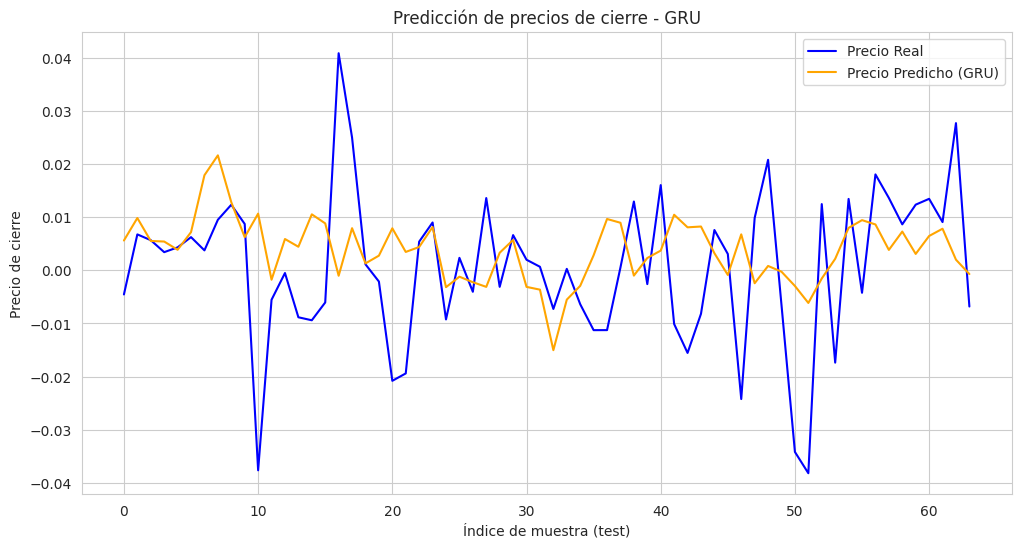

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

# ==========================
# Configuración
# ==========================
WINDOW = 60
fecha_corte = '2023-01-01'
threshold_log = 0  # cualquier subida es compra
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# ==========================
# Preparar datos
# ==========================
df_reg_sentiment = df_reg_sentiment.dropna()

mask_train = df_reg_sentiment['Date'] < fecha_corte
mask_test  = df_reg_sentiment['Date'] >= fecha_corte

features = [c for c in df_reg_sentiment.columns if c not in ['Target', 'Date']]

X_train_df = df_reg_sentiment.loc[mask_train, features]
y_train_sr = df_reg_sentiment.loc[mask_train, 'Target']

X_test_df = df_reg_sentiment.loc[mask_test, features]
y_test_sr = df_reg_sentiment.loc[mask_test, 'Target']
dates_test = df_reg_sentiment.loc[mask_test, 'Date'].values

# Escalar solo X
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train_df)
X_test_scaled  = scaler_X.transform(X_test_df)

# NO escalar y
y_train_array = y_train_sr.values
y_test_array  = y_test_sr.values

# Crear secuencias
def make_sequences(X_2d, y_1d, window=60):
    X_seq, y_seq = [], []
    for i in range(window, len(X_2d)):
        X_seq.append(X_2d[i-window:i, :])
        y_seq.append(y_1d[i])
    return np.asarray(X_seq, dtype=np.float32), np.asarray(y_seq, dtype=np.float32)

X_train_seq, y_train_seq = make_sequences(X_train_scaled, y_train_array, WINDOW)
X_test_seq,  y_test_seq  = make_sequences(X_test_scaled,  y_test_array,  WINDOW)

# ==========================
# Separar validación del train
# ==========================
val_fraction = 0.1
n_train = len(X_train_seq)
n_val = int(np.floor(n_train * val_fraction))
n_tr  = n_train - n_val

X_tr, y_tr = X_train_seq[:n_tr], y_train_seq[:n_tr]
X_val, y_val = X_train_seq[n_tr:], y_train_seq[n_tr:]

# ==========================
# Modelo GRU
# ==========================
model = keras.Sequential([
    layers.GRU(50, return_sequences=True, input_shape=(WINDOW, X_train_seq.shape[-1])),
    layers.Dropout(0.2),
    layers.GRU(50),
    layers.Dropout(0.2),
    layers.Dense(1)  # salida lineal
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='mse',
    metrics=['mae', keras.metrics.RootMeanSquaredError(name='rmse')]
)

# Early stopping
es = keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=3, restore_best_weights=True
)

# Entrenamiento
history = model.fit(
    X_tr, y_tr,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=64,
    shuffle=False,
    #callbacks=[es],
    verbose=1
)

# ==========================
# Predicciones
# ==========================
y_pred = model.predict(X_test_seq).ravel()
y_test_real = y_test_seq

# ==========================
# Métricas de regresión
# ==========================
mse = mean_squared_error(y_test_real, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_real, y_pred)

print(f"RMSE: {rmse:.6f}")
print(f"R²: {r2:.6f}")

# ==========================
# Conversión a clasificación Buy/Sell
# ==========================
y_test_shift = np.roll(y_test_real, 1)
y_pred_shift = np.roll(y_pred, 1)

y_test_logret = np.log(y_test_real / y_test_shift)[1:]
y_pred_logret = np.log(y_pred / y_pred_shift)[1:]

y_test_bin = (y_test_logret > threshold_log).astype(int)
y_pred_bin = (y_pred_logret > threshold_log).astype(int)

dates_test_bin = dates_test[WINDOW:][1:]  # alineamos fechas con secuencias y shift

# ==========================
# Métricas de clasificación
# ==========================
print(f"\nClasificación Buy/Sell con threshold log={threshold_log}")
print(f"Accuracy: {accuracy_score(y_test_bin, y_pred_bin):.4f}")
print("Matriz de confusión:")
print(confusion_matrix(y_test_bin, y_pred_bin))
print("\nReporte de clasificación:")
print(classification_report(y_test_bin, y_pred_bin, digits=4))

# ==========================
# Guardar resultados
# ==========================
df_pred_reg_sentiment_gru = pd.DataFrame({
    'Date': dates_test_bin,
    'y_real_price': y_test_real[1:],
    'y_real_logret': y_test_logret,
    'y_real_bin': y_test_bin,
    'y_pred_price': y_pred[1:],
    'y_pred_logret': y_pred_logret,
    'y_pred_bin': y_pred_bin
})
print(f"📂 Predicciones guardadas: {df_pred_reg_sentiment_gru.shape[0]} filas")
df_pred_reg_sentiment_gru.head()

# ==========================
# Gráfico pred vs real
# ==========================
plt.figure(figsize=(12,6))
plt.plot(y_test_real, label='Precio Real', color='blue')
plt.plot(y_pred, label='Precio Predicho (GRU)', color='orange')
plt.title('Predicción de precios de cierre - GRU')
plt.xlabel('Índice de muestra (test)')
plt.ylabel('Precio de cierre')
plt.legend()
plt.grid(True)
plt.show()




Matriz de confusión:
[[ 9 19]
 [10 26]]

Reporte de clasificación:
              precision    recall  f1-score   support

  No Comprar       0.47      0.32      0.38        28
     Comprar       0.58      0.72      0.64        36

    accuracy                           0.55        64
   macro avg       0.53      0.52      0.51        64
weighted avg       0.53      0.55      0.53        64



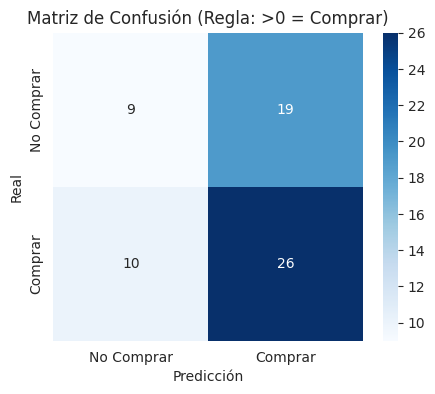

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# ==========================
# Señales reales y predichas
# ==========================
y_real_signal = (y_test_seq > 0).astype(int)   # Real
y_pred_signal = (y_pred > 0).astype(int)       # Predicha

# ==========================
# Matriz de confusión
# ==========================
cm = confusion_matrix(y_real_signal, y_pred_signal)

print("Matriz de confusión:")
print(cm)
print("\nReporte de clasificación:")
print(classification_report(y_real_signal, y_pred_signal, target_names=["No Comprar", "Comprar"]))

# ==========================
# Heatmap
# ==========================
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["No Comprar", "Comprar"],
            yticklabels=["No Comprar", "Comprar"])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión (Regla: >0 = Comprar)")
plt.show()



#### LSTM

Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0058 - mae: 0.0565 - rmse: 0.0754 - val_loss: 0.0013 - val_mae: 0.0267 - val_rmse: 0.0367
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0029 - mae: 0.0417 - rmse: 0.0536 - val_loss: 4.6126e-04 - val_mae: 0.0154 - val_rmse: 0.0215
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0024 - mae: 0.0384 - rmse: 0.0486 - val_loss: 0.0011 - val_mae: 0.0277 - val_rmse: 0.0337
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0019 - mae: 0.0333 - rmse: 0.0431 - val_loss: 0.0012 - val_mae: 0.0282 - val_rmse: 0.0352
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0014 - mae: 0.0291 - rmse: 0.0370 - val_loss: 0.0017 - val_mae: 0.0316 - val_rmse: 0.0408
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0016 - mae: 0.0313 - rmse: 0.0402 - val_loss: 0.0017 - val_mae: 0.0303 - val_rmse: 0.0414
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0026 - mae: 0.0396 - rmse: 0.0500 - val_

/tmp/ipython-input-2941583939.py:123: RuntimeWarning: invalid value encountered in log
  y_test_logret = np.log(y_test_real / y_test_shift)[1:]


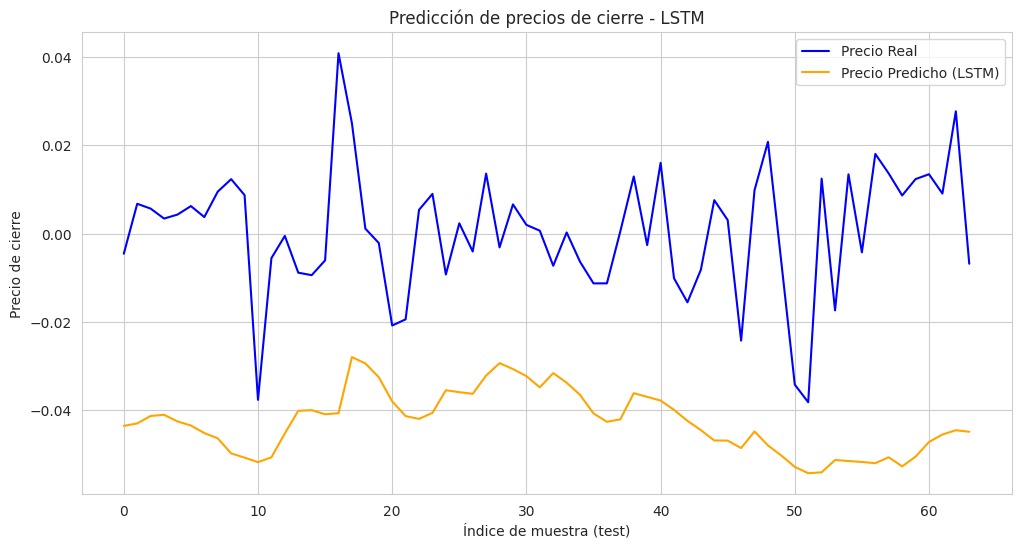

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

# ==========================
# Configuración
# ==========================
WINDOW = 60
fecha_corte = '2023-01-01'
threshold_log = 0  # cualquier subida se considera compra
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# ==========================
# Preparar datos
# ==========================
df_reg_sentiment = df_reg_sentiment.dropna()

mask_train = df_reg_sentiment['Date'] < fecha_corte
mask_test  = df_reg_sentiment['Date'] >= fecha_corte

features = [c for c in df_reg_sentiment.columns if c not in ['Target', 'Date']]

X_train_df = df_reg_sentiment.loc[mask_train, features]
y_train_sr = df_reg_sentiment.loc[mask_train, 'Target']

X_test_df = df_reg_sentiment.loc[mask_test, features]
y_test_sr = df_reg_sentiment.loc[mask_test, 'Target']
dates_test = df_reg_sentiment.loc[mask_test, 'Date'].values

# Escalar solo X
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train_df)
X_test_scaled  = scaler_X.transform(X_test_df)

# NO escalar y
y_train_array = y_train_sr.values
y_test_array  = y_test_sr.values

# Crear secuencias
def make_sequences(X_2d, y_1d, window=60):
    X_seq, y_seq = [], []
    for i in range(window, len(X_2d)):
        X_seq.append(X_2d[i-window:i, :])
        y_seq.append(y_1d[i])
    return np.asarray(X_seq, dtype=np.float32), np.asarray(y_seq, dtype=np.float32)

X_train_seq, y_train_seq = make_sequences(X_train_scaled, y_train_array, WINDOW)
X_test_seq,  y_test_seq  = make_sequences(X_test_scaled,  y_test_array,  WINDOW)

# ==========================
# Separar validación del train
# ==========================
val_fraction = 0.1
n_train = len(X_train_seq)
n_val = int(np.floor(n_train * val_fraction))
n_tr  = n_train - n_val

X_tr, y_tr = X_train_seq[:n_tr], y_train_seq[:n_tr]
X_val, y_val = X_train_seq[n_tr:], y_train_seq[n_tr:]

# ==========================
# Modelo LSTM
# ==========================
model = keras.Sequential([
    layers.LSTM(64, return_sequences=True, input_shape=(WINDOW, X_train_seq.shape[-1])),
    layers.Dropout(0.2),
    layers.LSTM(64),
    layers.Dropout(0.2),
    layers.Dense(1)  # salida lineal
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='mse',
    metrics=['mae', keras.metrics.RootMeanSquaredError(name='rmse')]
)

# Early stopping
es = keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=3, restore_best_weights=True
)

# Entrenamiento
history = model.fit(
    X_tr, y_tr,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=64,
    shuffle=False,
    #callbacks=[es],
    verbose=1
)

# ==========================
# Predicciones (escala real)
# ==========================
y_pred = model.predict(X_test_seq).ravel()
y_test_real = y_test_seq

# ==========================
# Métricas de regresión
# ==========================
mse = mean_squared_error(y_test_real, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_real, y_pred)

print(f"RMSE: {rmse:.6f}")
print(f"R²: {r2:.6f}")

# ==========================
# Conversión a clasificación Buy/Sell
# ==========================
y_test_shift = np.roll(y_test_real, 1)
y_pred_shift = np.roll(y_pred, 1)

y_test_logret = np.log(y_test_real / y_test_shift)[1:]
y_pred_logret = np.log(y_pred / y_pred_shift)[1:]

y_test_bin = (y_test_logret > threshold_log).astype(int)
y_pred_bin = (y_pred_logret > threshold_log).astype(int)

dates_test_bin = dates_test[WINDOW:][1:]

# ==========================
# Métricas de clasificación
# ==========================
print(f"\nClasificación Buy/Sell con threshold log={threshold_log}")
print(f"Accuracy: {accuracy_score(y_test_bin, y_pred_bin):.4f}")
print("Matriz de confusión:")
print(confusion_matrix(y_test_bin, y_pred_bin))
print("\nReporte de clasificación:")
print(classification_report(y_test_bin, y_pred_bin, digits=4))

# ==========================
# Guardar resultados
# ==========================
df_pred_reg_sentiment_lstm = pd.DataFrame({
    'Date': dates_test_bin,
    'y_real_price': y_test_real[1:],
    'y_real_logret': y_test_logret,
    'y_real_bin': y_test_bin,
    'y_pred_price': y_pred[1:],
    'y_pred_logret': y_pred_logret,
    'y_pred_bin': y_pred_bin
})
print(f"📂 Predicciones guardadas: {df_pred_reg_sentiment_lstm.shape[0]} filas")
df_pred_reg_sentiment_lstm.head()

# ==========================
# Gráfico pred vs real
# ==========================
plt.figure(figsize=(12,6))
plt.plot(y_test_real, label='Precio Real', color='blue')
plt.plot(y_pred, label='Precio Predicho (LSTM)', color='orange')
plt.title('Predicción de precios de cierre - LSTM')
plt.xlabel('Índice de muestra (test)')
plt.ylabel('Precio de cierre')
plt.legend()
plt.grid(True)
plt.show()


Matriz de confusión:
[[28  0]
 [36  0]]

Reporte de clasificación:
              precision    recall  f1-score   support

  No Comprar       0.44      1.00      0.61        28
     Comprar       0.00      0.00      0.00        36

    accuracy                           0.44        64
   macro avg       0.22      0.50      0.30        64
weighted avg       0.19      0.44      0.27        64



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


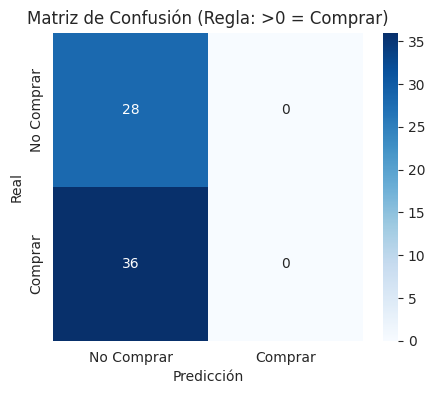

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# ==========================
# Señales reales y predichas
# ==========================
y_real_signal = (y_test_real > 0).astype(int)   # Real
y_pred_signal = (y_pred > 0).astype(int)        # Predicha

# ==========================
# Matriz de confusión
# ==========================
cm = confusion_matrix(y_real_signal, y_pred_signal)

print("Matriz de confusión:")
print(cm)
print("\nReporte de clasificación:")
print(classification_report(y_real_signal, y_pred_signal, target_names=["No Comprar", "Comprar"]))

# ==========================
# Heatmap
# ==========================
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["No Comprar", "Comprar"],
            yticklabels=["No Comprar", "Comprar"])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión (Regla: >0 = Comprar)")
plt.show()


## Variables técnicas

In [ ]:
from sklearn.ensemble import RandomForestRegressor
import pandas as pd

# ==========================
# Filtrar solo columnas técnicas
# ==========================
technical_cols = [
    'Open', 'High', 'Low', 'Close', 'Volume',
    'volume_adi', 'volume_obv', 'volume_cmf', 'volume_fi', 'volume_em',
    'volume_sma_em', 'volume_vpt', 'volume_vwap', 'volume_mfi', 'volume_nvi',
    'volatility_bbm', 'volatility_bbh', 'volatility_bbl', 'volatility_bbw',
    'volatility_bbp', 'volatility_bbhi', 'volatility_bbli', 'volatility_kcc',
    'volatility_kch', 'volatility_kcl', 'volatility_kcw', 'volatility_kcp',
    'volatility_kchi', 'volatility_kcli', 'volatility_dcl', 'volatility_dch',
    'volatility_dcm', 'volatility_dcw', 'volatility_dcp', 'volatility_atr',
    'volatility_ui',
    'trend_macd', 'trend_macd_signal', 'trend_macd_diff', 'trend_sma_fast',
    'trend_sma_slow', 'trend_ema_fast', 'trend_ema_slow', 'trend_vortex_ind_pos',
    'trend_vortex_ind_neg', 'trend_vortex_ind_diff', 'trend_trix',
    'trend_mass_index', 'trend_dpo', 'trend_kst', 'trend_kst_sig',
    'trend_kst_diff', 'trend_ichimoku_conv', 'trend_ichimoku_base',
    'trend_ichimoku_a', 'trend_ichimoku_b', 'trend_stc', 'trend_adx',
    'trend_adx_pos', 'trend_adx_neg', 'trend_cci', 'trend_visual_ichimoku_a',
    'trend_visual_ichimoku_b', 'trend_aroon_up', 'trend_aroon_down',
    'trend_aroon_ind', 'trend_psar_up', 'trend_psar_down',
    'trend_psar_up_indicator', 'trend_psar_down_indicator',
    'momentum_rsi', 'momentum_stoch_rsi', 'momentum_stoch_rsi_k',
    'momentum_stoch_rsi_d', 'momentum_tsi', 'momentum_uo', 'momentum_stoch',
    'momentum_stoch_signal', 'momentum_wr', 'momentum_ao', 'momentum_roc',
    'momentum_ppo', 'momentum_ppo_signal', 'momentum_ppo_hist', 'momentum_pvo',
    'momentum_pvo_signal', 'momentum_pvo_hist', 'momentum_kama',
    'others_dr', 'others_dlr', 'others_cr',
    'return'
]

df_ta_tech = df_reg[technical_cols + ['Target', 'Date']].dropna()

# ==========================
# Separar features y target
# ==========================
X = df_ta_tech.drop(columns=['Target', 'Date'])
y = df_ta_tech['Target']

# ==========================
# Random Forest para feature importance
# ==========================
rf = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)
rf.fit(X, y)

# ==========================
# Importancia de features
# ==========================
importances = pd.Series(rf.feature_importances_, index=X.columns)
top20_features = importances.sort_values(ascending=False).head(20)

print("📊 Top 20 variables técnicas más importantes:")
print(top20_features)

# ==========================
# Dataset solo con las top 20
# ==========================
df_ta_tech_top = df_ta_tech[top20_features.index.tolist() + ['Target', 'Date']].copy()
print(f"📏 Dataset reducido: {df_ta_tech_top.shape[0]} filas, {df_ta_tech_top.shape[1]} columnas")


📊 Top 20 variables técnicas más importantes:
trend_adx               0.038026
Volume                  0.031741
trend_mass_index        0.030202
volatility_kcw          0.029409
volume_em               0.024466
volume_cmf              0.022786
volume_fi               0.022518
trend_dpo               0.022291
volatility_atr          0.022010
volume_nvi              0.021251
momentum_pvo_hist       0.020679
volume_vpt              0.019275
volume_obv              0.019131
momentum_uo             0.019034
momentum_pvo            0.018854
momentum_pvo_signal     0.018484
trend_adx_neg           0.017583
volume_mfi              0.017077
volatility_dcw          0.016188
momentum_stoch_rsi_d    0.015645
dtype: float64
📏 Dataset reducido: 3005 filas, 22 columnas


#### RandomForest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report, confusion_matrix
import numpy as np
import pandas as pd

# ==========================
# Configuración
# ==========================
fecha_corte = '2023-01-01'
threshold_log = 0  # cualquier subida se considera compra

# ==========================
# Train / Test split
# ==========================
mask_train = df_ta_tech_top['Date'] < fecha_corte
mask_test  = df_ta_tech_top['Date'] >= fecha_corte

X_train = df_ta_tech_top.loc[mask_train].drop(columns=['Target', 'Date'])
y_train = df_ta_tech_top.loc[mask_train, 'Target']

X_test  = df_ta_tech_top.loc[mask_test].drop(columns=['Target', 'Date'])
y_test  = df_ta_tech_top.loc[mask_test, 'Target']
dates_test = df_ta_tech_top.loc[mask_test, 'Date'].values

# ==========================
# Espacio de búsqueda
# ==========================
param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 5, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 0.5]
}

# Modelo base
rf = RandomForestRegressor(random_state=42, n_jobs=-1)

# Randomized Search
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=30,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Entrenar
random_search.fit(X_train, y_train)

print("🔍 Mejores parámetros encontrados:")
print(random_search.best_params_)

# Mejor modelo
best_rf = random_search.best_estimator_

# ==========================
# Predicciones y métricas de regresión
# ==========================
y_pred = best_rf.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.6f}")
print(f"R²: {r2:.4f}")

# ==========================
# Conversión a clasificación Buy/Sell
# ==========================
y_test_shift = np.roll(y_test, 1)
y_pred_shift = np.roll(y_pred, 1)

y_test_logret = np.log(y_test / y_test_shift)[1:]
y_pred_logret = np.log(y_pred / y_pred_shift)[1:]

y_test_bin = (y_test_logret > threshold_log).astype(int)
y_pred_bin = (y_pred_logret > threshold_log).astype(int)

dates_test_bin = dates_test[1:]

# ==========================
# Métricas de clasificación
# ==========================
print(f"\nClasificación Buy/Sell con threshold log={threshold_log}")
print(f"Accuracy: {accuracy_score(y_test_bin, y_pred_bin):.4f}")
print("Matriz de confusión:")
print(confusion_matrix(y_test_bin, y_pred_bin))
print("\nReporte de clasificación:")
print(classification_report(y_test_bin, y_pred_bin, digits=4))

# ==========================
# Guardar resultados
# ==========================
df_pred_reg_tech_rf = pd.DataFrame({
    'Date': dates_test_bin,
    'y_real_price': y_test[1:],
    'y_real_logret': y_test_logret,
    'y_real_bin': y_test_bin,
    'y_pred_price': y_pred[1:],
    'y_pred_logret': y_pred_logret,
    'y_pred_bin': y_pred_bin
})
print(f"📂 Predicciones guardadas: {df_pred_reg_tech_rf.shape[0]} filas")
df_pred_reg_tech_rf.head()


Fitting 3 folds for each of 30 candidates, totalling 90 fits


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
21 fits failed out of a total of 90.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
21 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.12/dist-packages/sklearn/utils/_

🔍 Mejores parámetros encontrados:
{'n_estimators': 500, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 5}
RMSE: 0.012894
R²: 0.0021

Clasificación Buy/Sell con threshold log=0
Accuracy: 0.5941
Matriz de confusión:
[[114  66]
 [ 31  28]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0     0.7862    0.6333    0.7015       180
           1     0.2979    0.4746    0.3660        59

    accuracy                         0.5941       239
   macro avg     0.5420    0.5540    0.5338       239
weighted avg     0.6657    0.5941    0.6187       239

📂 Predicciones guardadas: 239 filas


/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipython-input-4008753695.py:80: RuntimeWarning: invalid value encountered in log
  y_pred_logret = np.log(y_pred / y_pred_shift)[1:]


,Date,y_real_price,y_real_logret,y_real_bin,y_pred_price,y_pred_logret,y_pred_bin
2767,2023-01-04,0.004085,1.154740,1,-0.000179,-0.480814,0
2768,2023-01-05,0.025644,1.836915,1,-0.000260,0.370811,1
2769,2023-01-06,-0.034419,NaN,0,-0.000981,1.328012,1
2770,2023-01-09,0.023689,NaN,0,-0.000140,-1.947669,0
2771,2023-01-10,0.000574,-3.720351,0,-0.000526,1.323637,1


#### GRU

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.1197 - mae: 0.2561 - rmse: 0.3371 - val_loss: 0.0157 - val_mae: 0.1018 - val_rmse: 0.1254
Epoch 2/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0986 - mae: 0.2385 - rmse: 0.3047 - val_loss: 0.0149 - val_mae: 0.0999 - val_rmse: 0.1222
Epoch 3/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0425 - mae: 0.1603 - rmse: 0.2047 - val_loss: 0.0092 - val_mae: 0.0815 - val_rmse: 0.0958
Epoch 4/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0321 - mae: 0.1413 - rmse: 0.1768 - val_loss: 0.0029 - val_mae: 0.0445 - val_rmse: 0.0541
Epoch 5/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0504 - mae: 0.1733 - rmse: 0.2163 - val_loss: 0.0027 - val_mae: 0.0415 - val_rmse: 0.0522
Epoch 6/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0687 - mae: 0.1918 - rmse: 0.2468 - val_loss: 0.0025 - val_mae: 0.0380 - val_rmse: 0.0495
Epoch 7/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0444 - mae: 0.1539 - rmse: 0.1989 

/tmp/ipython-input-117416452.py:112: RuntimeWarning: divide by zero encountered in divide
  y_test_logret = np.log(y_test_real[1:] / y_test_real[:-1])
/tmp/ipython-input-117416452.py:112: RuntimeWarning: divide by zero encountered in log
  y_test_logret = np.log(y_test_real[1:] / y_test_real[:-1])
/tmp/ipython-input-117416452.py:112: RuntimeWarning: invalid value encountered in log
  y_test_logret = np.log(y_test_real[1:] / y_test_real[:-1])
/tmp/ipython-input-117416452.py:113: RuntimeWarning: invalid value encountered in log
  y_pred_logret = np.log(y_pred[1:] / y_pred[:-1])


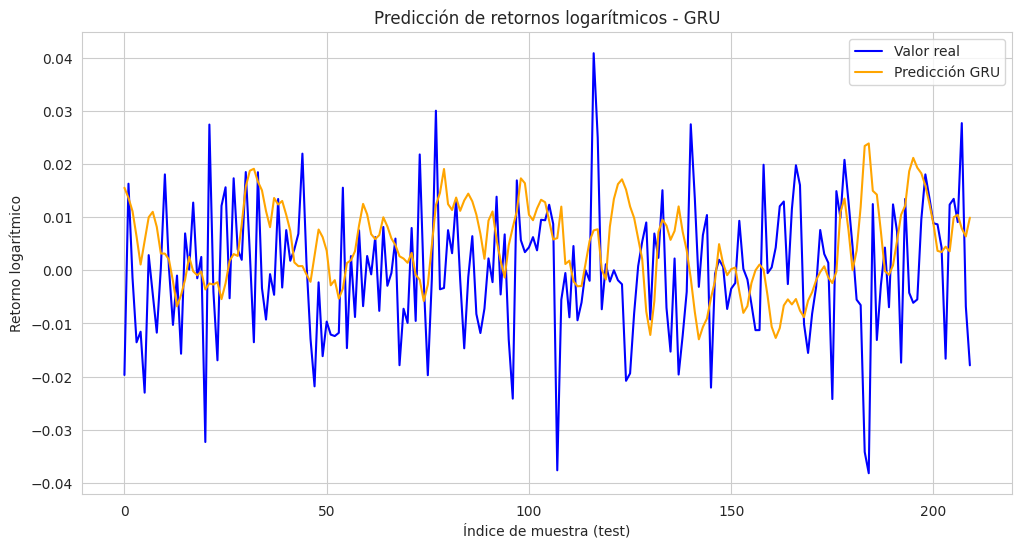

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt

# ==========================
# Configuración
# ==========================
WINDOW = 30
fecha_corte = '2023-01-01'
threshold_log = 0
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# ==========================
# Preparar datos
# ==========================
df_ta_tech_top = df_ta_tech_top.dropna()

mask_train = df_ta_tech_top['Date'] < fecha_corte
mask_test  = df_ta_tech_top['Date'] >= fecha_corte

features = [c for c in df_ta_tech_top.columns if c not in ['Target', 'Date']]

X_train_df = df_ta_tech_top.loc[mask_train, features]
y_train_sr = df_ta_tech_top.loc[mask_train, 'Target']

X_test_df = df_ta_tech_top.loc[mask_test, features]
y_test_sr = df_ta_tech_top.loc[mask_test, 'Target']
dates_test = df_ta_tech_top.loc[mask_test, 'Date'].values

# Escalar solo X
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train_df)
X_test_scaled  = scaler_X.transform(X_test_df)

# NO escalar y
y_train_array = y_train_sr.values
y_test_array  = y_test_sr.values

# Crear secuencias
def make_sequences(X_2d, y_1d, window=60):
    X_seq, y_seq = [], []
    for i in range(window, len(X_2d)):
        X_seq.append(X_2d[i-window:i, :])
        y_seq.append(y_1d[i])
    return np.asarray(X_seq, dtype=np.float32), np.asarray(y_seq, dtype=np.float32)

X_train_seq, y_train_seq = make_sequences(X_train_scaled, y_train_array, WINDOW)
X_test_seq,  y_test_seq  = make_sequences(X_test_scaled,  y_test_array,  WINDOW)

# ==========================
# Separar validación del train
# ==========================
val_fraction = 0.1
n_train = len(X_train_seq)
n_val = int(np.floor(n_train * val_fraction))
n_tr  = n_train - n_val

X_tr, y_tr = X_train_seq[:n_tr], y_train_seq[:n_tr]
X_val, y_val = X_train_seq[n_tr:], y_train_seq[n_tr:]

# ==========================
# Modelo GRU
# ==========================
model = keras.Sequential([
    layers.GRU(64, return_sequences=True, input_shape=(WINDOW, X_train_seq.shape[-1])),
    layers.Dropout(0.2),
    layers.GRU(64),
    layers.Dropout(0.2),
    layers.Dense(1)  # salida lineal
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='mse',
    metrics=['mae', keras.metrics.RootMeanSquaredError(name='rmse')]
)

# Entrenamiento
history = model.fit(
    X_tr, y_tr,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=64,
    shuffle=False,
    verbose=1
)

# ==========================
# Predicciones (ya en escala real)
# ==========================
y_pred = model.predict(X_test_seq).ravel()
y_test_real = y_test_seq  # ya en escala real

# ==========================
# Evaluación regresión
# ==========================
rmse = np.sqrt(mean_squared_error(y_test_real, y_pred))
r2 = r2_score(y_test_real, y_pred)
print(f"RMSE: {rmse:.6f}")
print(f"R²: {r2:.4f}")

# ==========================
# Conversión a clasificación Buy/Sell
# ==========================
y_test_logret = np.log(y_test_real[1:] / y_test_real[:-1])
y_pred_logret = np.log(y_pred[1:] / y_pred[:-1])

y_test_bin = (y_test_logret > threshold_log).astype(int)
y_pred_bin = (y_pred_logret > threshold_log).astype(int)

dates_test_bin = dates_test[WINDOW+1:]

print(f"\nClasificación Buy/Sell con threshold log={threshold_log}")
print(f"Accuracy: {accuracy_score(y_test_bin, y_pred_bin):.4f}")
print("Matriz de confusión:")
print(confusion_matrix(y_test_bin, y_pred_bin))
print("\nReporte de clasificación:")
print(classification_report(y_test_bin, y_pred_bin, digits=4))

# ==========================
# Guardar resultados
# ==========================
df_pred_reg_tech_gru = pd.DataFrame({
    'Date': dates_test_bin,
    'y_real_price': y_test_real[1:],
    'y_real_logret': y_test_logret,
    'y_real_bin': y_test_bin,
    'y_pred_price': y_pred[1:],
    'y_pred_logret': y_pred_logret,
    'y_pred_bin': y_pred_bin
})
print(f"📂 Predicciones guardadas: {df_pred_reg_tech_gru.shape[0]} filas")
df_pred_reg_tech_gru.head()

# ==========================
# Gráfico pred vs real
# ==========================
plt.figure(figsize=(12,6))
plt.plot(y_test_real, label='Valor real', color='blue')
plt.plot(y_pred, label='Predicción GRU', color='orange')
plt.title('Predicción de retornos logarítmicos - GRU')
plt.xlabel('Índice de muestra (test)')
plt.ylabel('Retorno logarítmico')
plt.legend()
plt.grid(True)
plt.show()


Threshold utilizado: 0.0
Matriz de confusión:
[[32 76]
 [31 71]]

Reporte de clasificación:
              precision    recall  f1-score   support

  No Comprar       0.51      0.30      0.37       108
     Comprar       0.48      0.70      0.57       102

    accuracy                           0.49       210
   macro avg       0.50      0.50      0.47       210
weighted avg       0.50      0.49      0.47       210



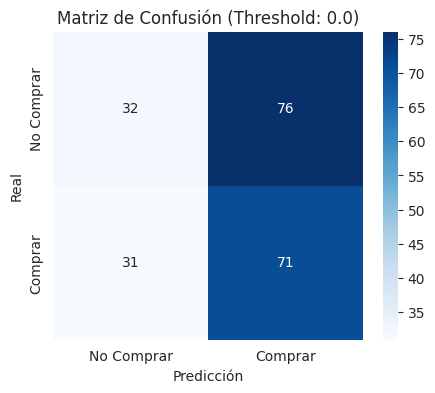

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# ==========================
# Threshold
# ==========================
threshold = 0.00  # Cambia este valor para ajustar la sensibilidad

# Señales reales y predichas
y_real_signal = (y_test_real > threshold).astype(int)   # Señal real
y_pred_signal = (y_pred > threshold).astype(int)        # Señal predicha

# ==========================
# Matriz de confusión
# ==========================
cm = confusion_matrix(y_real_signal, y_pred_signal)

print(f"Threshold utilizado: {threshold}")
print("Matriz de confusión:")
print(cm)
print("\nReporte de clasificación:")
print(classification_report(y_real_signal, y_pred_signal, target_names=["No Comprar", "Comprar"]))

# ==========================
# Heatmap visual
# ==========================
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["No Comprar", "Comprar"],
            yticklabels=["No Comprar", "Comprar"])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title(f"Matriz de Confusión (Threshold: {threshold})")
plt.show()



#### LSTM

Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0156 - mae: 0.0993 - rmse: 0.1243 - val_loss: 0.0091 - val_mae: 0.0652 - val_rmse: 0.0952
Epoch 2/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0178 - mae: 0.1007 - rmse: 0.1285 - val_loss: 0.0017 - val_mae: 0.0352 - val_rmse: 0.0415
Epoch 3/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0201 - mae: 0.1018 - rmse: 0.1327 - val_loss: 0.0023 - val_mae: 0.0376 - val_rmse: 0.0478
Epoch 4/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0052 - mae: 0.0570 - rmse: 0.0714 - val_loss: 0.0020 - val_mae: 0.0371 - val_rmse: 0.0453
Epoch 5/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0034 - mae: 0.0471 - rmse: 0.0585 - val_loss: 4.5458e-04 - val_mae: 0.0162 - val_rmse: 0.0213
Epoch 6/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0024 - mae: 0.0390 - rmse: 0.0483 - val_loss: 4.0978e-04 - val_mae: 0.0154 - val_rmse: 0.0202
Epoch 7/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0017 - mae: 0.0324 - rmse: 0.0409 - 

/tmp/ipython-input-3770274900.py:113: RuntimeWarning: divide by zero encountered in divide
  y_test_logret = np.log(y_test_real[1:] / y_test_real[:-1])
/tmp/ipython-input-3770274900.py:113: RuntimeWarning: divide by zero encountered in log
  y_test_logret = np.log(y_test_real[1:] / y_test_real[:-1])
/tmp/ipython-input-3770274900.py:113: RuntimeWarning: invalid value encountered in log
  y_test_logret = np.log(y_test_real[1:] / y_test_real[:-1])
/tmp/ipython-input-3770274900.py:114: RuntimeWarning: invalid value encountered in log
  y_pred_logret = np.log(y_pred[1:] / y_pred[:-1])


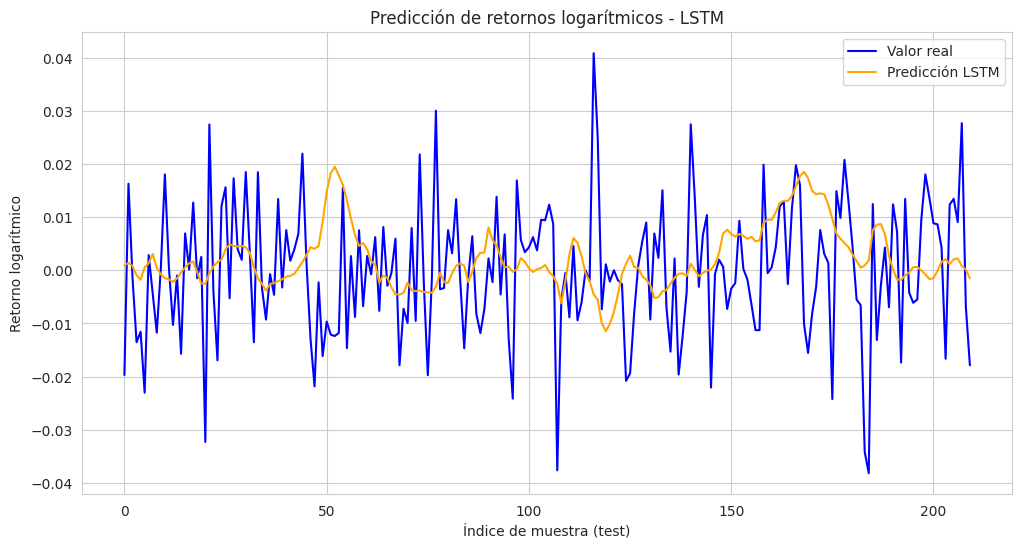

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================
# Configuración
# ==========================
WINDOW = 30
fecha_corte = '2023-01-01'
threshold_log = 0
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# ==========================
# Preparar datos
# ==========================
df_reg_tech = df_ta_tech_top.dropna()

mask_train = df_reg_tech['Date'] < fecha_corte
mask_test  = df_reg_tech['Date'] >= fecha_corte

features = [c for c in df_reg_tech.columns if c not in ['Target', 'Date']]

X_train_df = df_reg_tech.loc[mask_train, features]
y_train_sr = df_reg_tech.loc[mask_train, 'Target']

X_test_df = df_reg_tech.loc[mask_test, features]
y_test_sr = df_reg_tech.loc[mask_test, 'Target']
dates_test = df_reg_tech.loc[mask_test, 'Date'].values

# Escalar solo X
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train_df)
X_test_scaled  = scaler_X.transform(X_test_df)

# NO escalar y
y_train_array = y_train_sr.values
y_test_array  = y_test_sr.values

# Crear secuencias
def make_sequences(X_2d, y_1d, window=60):
    X_seq, y_seq = [], []
    for i in range(window, len(X_2d)):
        X_seq.append(X_2d[i-window:i, :])
        y_seq.append(y_1d[i])
    return np.asarray(X_seq, dtype=np.float32), np.asarray(y_seq, dtype=np.float32)

X_train_seq, y_train_seq = make_sequences(X_train_scaled, y_train_array, WINDOW)
X_test_seq,  y_test_seq  = make_sequences(X_test_scaled,  y_test_array,  WINDOW)

# ==========================
# Separar validación del train
# ==========================
val_fraction = 0.1
n_train = len(X_train_seq)
n_val = int(np.floor(n_train * val_fraction))
n_tr  = n_train - n_val

X_tr, y_tr = X_train_seq[:n_tr], y_train_seq[:n_tr]
X_val, y_val = X_train_seq[n_tr:], y_train_seq[n_tr:]

# ==========================
# Modelo LSTM
# ==========================
model = keras.Sequential([
    layers.LSTM(64, return_sequences=True, input_shape=(WINDOW, X_train_seq.shape[-1])),
    layers.Dropout(0.2),
    layers.LSTM(64),
    layers.Dropout(0.2),
    layers.Dense(1)  # salida lineal
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='mse',
    metrics=['mae', keras.metrics.RootMeanSquaredError(name='rmse')]
)

# Entrenamiento
history = model.fit(
    X_tr, y_tr,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=64,
    shuffle=False,
    verbose=1
)

# ==========================
# Predicciones (regresión)
# ==========================
y_pred = model.predict(X_test_seq).ravel()
y_test_real = y_test_seq

# ==========================
# Métricas de regresión
# ==========================
rmse = np.sqrt(mean_squared_error(y_test_real, y_pred))
r2 = r2_score(y_test_real, y_pred)
print(f"RMSE: {rmse:.6f}")
print(f"R²: {r2:.4f}")

# ==========================
# Conversión a clasificación Buy/Sell
# ==========================
y_test_logret = np.log(y_test_real[1:] / y_test_real[:-1])
y_pred_logret = np.log(y_pred[1:] / y_pred[:-1])

y_test_bin = (y_test_logret > threshold_log).astype(int)
y_pred_bin = (y_pred_logret > threshold_log).astype(int)

dates_test_bin = dates_test[WINDOW+1:]

print(f"\nClasificación Buy/Sell con threshold log={threshold_log}")
print(f"Accuracy: {accuracy_score(y_test_bin, y_pred_bin):.4f}")
print("\nMatriz de confusión:")
print(confusion_matrix(y_test_bin, y_pred_bin))
print("\nReporte de clasificación:")
print(classification_report(y_test_bin, y_pred_bin, digits=4))

# ==========================
# Guardar resultados
# ==========================
df_pred_reg_tech_lstm = pd.DataFrame({
    'Date': dates_test_bin,
    'y_real_price': y_test_real[1:],
    'y_real_logret': y_test_logret,
    'y_real_bin': y_test_bin,
    'y_pred_price': y_pred[1:],
    'y_pred_logret': y_pred_logret,
    'y_pred_bin': y_pred_bin
})
print(f"📂 Predicciones guardadas: {df_pred_reg_tech_lstm.shape[0]} filas")
df_pred_reg_tech_lstm.head()

# ==========================
# Gráfico pred vs real
# ==========================
plt.figure(figsize=(12,6))
plt.plot(y_test_real, label='Valor real', color='blue')
plt.plot(y_pred, label='Predicción LSTM', color='orange')
plt.title('Predicción de retornos logarítmicos - LSTM')
plt.xlabel('Índice de muestra (test)')
plt.ylabel('Retorno logarítmico')
plt.legend()
plt.grid(True)
plt.show()


Threshold utilizado: 0.0
Matriz de confusión:
[[46 62]
 [39 63]]

Reporte de clasificación:
              precision    recall  f1-score   support

  No Comprar       0.54      0.43      0.48       108
     Comprar       0.50      0.62      0.56       102

    accuracy                           0.52       210
   macro avg       0.52      0.52      0.52       210
weighted avg       0.52      0.52      0.51       210



Text(33.222222222222214, 0.5, 'Real')

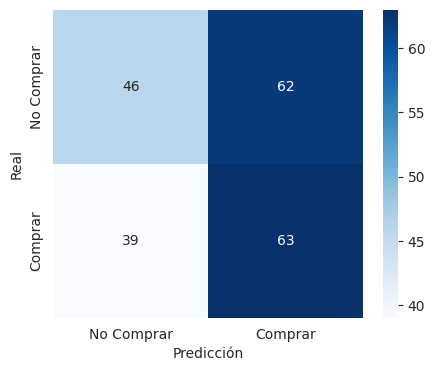

In [ ]:
# ==========================
# Matriz de confusión con threshold configurable
# ==========================
threshold = 0.00  # Cambia aquí el umbral para decidir compra/venta

y_real_signal = (y_test_real > threshold).astype(int)   # Señal real
y_pred_signal = (y_pred > threshold).astype(int)        # Señal predicha

cm = confusion_matrix(y_real_signal, y_pred_signal)

print(f"Threshold utilizado: {threshold}")
print("Matriz de confusión:")
print(cm)
print("\nReporte de clasificación:")
print(classification_report(y_real_signal, y_pred_signal, target_names=["No Comprar", "Comprar"]))

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["No Comprar", "Comprar"],
            yticklabels=["No Comprar", "Comprar"])
plt.xlabel("Predicción")
plt.ylabel("Real")

## Modelo Completo

In [ ]:
# ==========================
# 1️⃣ Definir variables de sentimiento
# ==========================
sentiment_features = [
    'mean_sentiment_score',
    'mean_sentiment_value',
    'mean_sentiment_positive_prob',
    'mean_sentiment_negative_prob',
    'mean_sentiment_neutral_prob',
    'mean_weighted_score_value',
    'dominant_sentiment_strength',
    'sentiment_direction',
    'sentiment_bias',
    'std_sentiment_value'
]

# ==========================
# 2️⃣ Asegurarnos de que top20_features es lista de strings
# ==========================
# Si top20_features viene como Series con nombres de columnas en el índice
top20_features_list = list(top20_features.index) if not isinstance(top20_features, list) else top20_features

# ==========================
# 3️⃣ Unir top 20 técnicas + sentimiento
# ==========================
combined_features = top20_features_list + sentiment_features + ['Date', 'Target']

# ==========================
# 4️⃣ Crear dataset combinado
# ==========================
df_reg_combined = df_reg[combined_features].copy()

print(f"📊 Dataset combinado: {df_reg_combined.shape[0]} filas y {df_reg_combined.shape[1]} columnas")
df_reg_combined.head()


📊 Dataset combinado: 3006 filas y 32 columnas


,trend_adx,Volume,trend_mass_index,volatility_kcw,volume_em,volume_cmf,volume_fi,trend_dpo,volatility_atr,volume_nvi,...,mean_sentiment_positive_prob,mean_sentiment_negative_prob,mean_sentiment_neutral_prob,mean_weighted_score_value,dominant_sentiment_strength,sentiment_direction,sentiment_bias,std_sentiment_value,Date,Target
0,0.0,18431800,1.000000,4.565070,0.000000,0.072165,0.000000e+00,40.520751,0.0,1000.000000,...,0.579638,0.420133,2.295656e-04,0.000000,0.0,0.0,0.0,NaN,2012-01-05,0.006096
1,0.0,15542000,1.988420,4.390184,0.118455,0.171309,1.422809e+06,40.474978,0.0,1006.114804,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2012-01-06,-0.001169
2,0.0,16801200,2.925920,3.925558,0.009449,0.176666,1.177303e+06,40.465587,0.0,1006.114804,...,0.666620,0.333379,5.615664e-07,0.333333,1.0,1.0,0.5,0.57735,2012-01-09,0.034954
3,0.0,30110000,4.073119,5.361821,1.141324,0.203079,3.311188e+06,40.327095,0.0,1006.114804,...,0.999891,0.000106,2.820156e-06,0.000000,0.0,0.0,0.0,0.00000,2012-01-10,0.003384
4,0.0,15471000,5.138924,5.022743,0.131408,0.252712,2.954881e+06,40.233438,0.0,1009.525099,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2012-01-11,0.011199


#### RandomForest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report, confusion_matrix
import numpy as np
import pandas as pd

# ==========================
# Configuración
# ==========================
fecha_corte = '2023-01-01'
threshold_log = 0
SEED = 42

# ==========================
# Dividir train / test
# ==========================
mask_train = df_reg_combined['Date'] < fecha_corte
mask_test  = df_reg_combined['Date'] >= fecha_corte

features = [c for c in df_reg_combined.columns if c not in ['Target', 'Date']]

X_train = df_reg_combined.loc[mask_train, features]
y_train = df_reg_combined.loc[mask_train, 'Target']

X_test = df_reg_combined.loc[mask_test, features]
y_test = df_reg_combined.loc[mask_test, 'Target']
dates_test = df_reg_combined.loc[mask_test, 'Date'].values

# ==========================
# RandomForest con búsqueda aleatoria
# ==========================
rf = RandomForestRegressor(random_state=SEED, n_jobs=-1)

param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 5, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

random_search = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=30,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1,
    random_state=SEED
)

random_search.fit(X_train, y_train)

# ==========================
# Mejor modelo y métricas de regresión
# ==========================
best_rf = random_search.best_estimator_
print("🔍 Mejor configuración encontrada:", random_search.best_params_)

y_pred = best_rf.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"📏 MSE:  {mse:.6f}")
print(f"📏 RMSE: {rmse:.6f}")
print(f"📏 R²:   {r2:.6f}")

# ==========================
# Conversión a clasificación Buy/Sell
# ==========================
y_test_logret = np.log(y_test.values[1:] / y_test.values[:-1])
y_pred_logret = np.log(y_pred[1:] / y_pred[:-1])

y_test_bin = (y_test_logret > threshold_log).astype(int)
y_pred_bin = (y_pred_logret > threshold_log).astype(int)

dates_test_bin = dates_test[1:]

print(f"\nClasificación Buy/Sell con threshold log={threshold_log}")
print(f"Accuracy: {accuracy_score(y_test_bin, y_pred_bin):.4f}")
print("\nMatriz de confusión:")
print(confusion_matrix(y_test_bin, y_pred_bin))
print("\nReporte de clasificación:")
print(classification_report(y_test_bin, y_pred_bin, digits=4))

# ==========================
# Guardar resultados
# ==========================
df_pred_reg_combined_rf = pd.DataFrame({
    'Date': dates_test_bin,
    'y_real_price': y_test.values[1:],
    'y_real_logret': y_test_logret,
    'y_real_bin': y_test_bin,
    'y_pred_price': y_pred[1:],
    'y_pred_logret': y_pred_logret,
    'y_pred_bin': y_pred_bin
})
print(f"📂 Predicciones guardadas: {df_pred_reg_combined_rf.shape[0]} filas")
df_pred_reg_combined_rf.head()


Fitting 3 folds for each of 30 candidates, totalling 90 fits


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
30 fits failed out of a total of 90.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.12/dist-packages/sklearn/utils/_

🔍 Mejor configuración encontrada: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 5}
📏 MSE:  0.000166
📏 RMSE: 0.012891
📏 R²:   0.002582

Clasificación Buy/Sell con threshold log=0
Accuracy: 0.5858

Matriz de confusión:
[[120  60]
 [ 39  20]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0     0.7547    0.6667    0.7080       180
           1     0.2500    0.3390    0.2878        59

    accuracy                         0.5858       239
   macro avg     0.5024    0.5028    0.4979       239
weighted avg     0.6301    0.5858    0.6042       239

📂 Predicciones guardadas: 239 filas


/tmp/ipython-input-4040130538.py:74: RuntimeWarning: divide by zero encountered in divide
  y_test_logret = np.log(y_test.values[1:] / y_test.values[:-1])
/tmp/ipython-input-4040130538.py:74: RuntimeWarning: divide by zero encountered in log
  y_test_logret = np.log(y_test.values[1:] / y_test.values[:-1])
/tmp/ipython-input-4040130538.py:74: RuntimeWarning: invalid value encountered in log
  y_test_logret = np.log(y_test.values[1:] / y_test.values[:-1])
/tmp/ipython-input-4040130538.py:75: RuntimeWarning: invalid value encountered in log
  y_pred_logret = np.log(y_pred[1:] / y_pred[:-1])


,Date,y_real_price,y_real_logret,y_real_bin,y_pred_price,y_pred_logret,y_pred_bin
0,2023-01-04,0.004085,1.154740,1,-0.000052,-0.101948,0
1,2023-01-05,0.025644,1.836915,1,0.000189,NaN,0
2,2023-01-06,-0.034419,NaN,0,-0.000783,NaN,0
3,2023-01-09,0.023689,NaN,0,0.000243,NaN,0
4,2023-01-10,0.000574,-3.720351,0,-0.000440,NaN,0


#### GRU

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0833 - mae: 0.2284 - rmse: 0.2878 - val_loss: 0.0130 - val_mae: 0.0891 - val_rmse: 0.1141
Epoch 2/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0450 - mae: 0.1690 - rmse: 0.2117 - val_loss: 0.0125 - val_mae: 0.0993 - val_rmse: 0.1118
Epoch 3/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0529 - mae: 0.1852 - rmse: 0.2286 - val_loss: 0.0128 - val_mae: 0.0940 - val_rmse: 0.1132
Epoch 4/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1296 - mae: 0.2782 - rmse: 0.3427 - val_loss: 0.0078 - val_mae: 0.0741 - val_rmse: 0.0883
Epoch 5/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0964 - mae: 0.2431 - rmse: 0.2973 - val_loss: 0.0034 - val_mae: 0.0496 - val_rmse: 0.0580
Epoch 6/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0198 - mae: 0.1117 - rmse: 0.1398 - val_loss: 0.0019 - val_mae: 0.0333 - val_rmse: 0.0435
Epoch 7/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0114 - mae: 0.0819 - rmse: 0.1065

/tmp/ipython-input-4032193286.py:116: RuntimeWarning: invalid value encountered in log
  y_test_logret = np.log(y_test_real[1:] / y_test_real[:-1])
/tmp/ipython-input-4032193286.py:117: RuntimeWarning: invalid value encountered in log
  y_pred_logret = np.log(y_pred[1:] / y_pred[:-1])


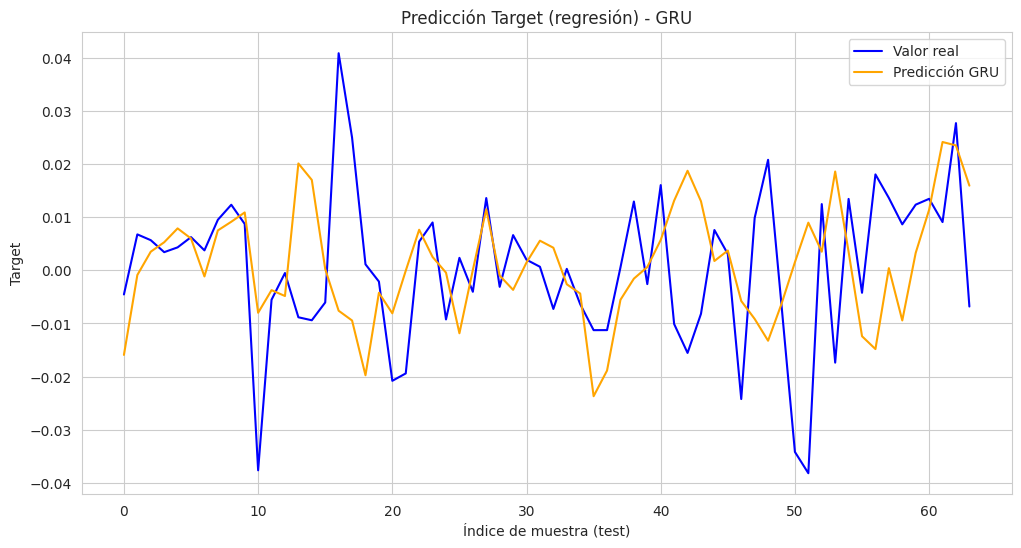

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

# ==========================
# Configuración
# ==========================
WINDOW = 60
fecha_corte = '2023-01-01'
threshold_log = 0
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# ==========================
# Preparar datos
# ==========================
df_reg_combined = df_reg_combined.dropna()

mask_train = df_reg_combined['Date'] < fecha_corte
mask_test  = df_reg_combined['Date'] >= fecha_corte

features = [c for c in df_reg_combined.columns if c not in ['Target', 'Date']]

X_train_df = df_reg_combined.loc[mask_train, features]
y_train_sr = df_reg_combined.loc[mask_train, 'Target']

X_test_df = df_reg_combined.loc[mask_test, features]
y_test_sr = df_reg_combined.loc[mask_test, 'Target']
dates_test = df_reg_combined.loc[mask_test, 'Date'].values

# Escalar solo X
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train_df)
X_test_scaled  = scaler_X.transform(X_test_df)

# Crear secuencias
def make_sequences(X_2d, y_1d, window=60):
    X_seq, y_seq = [], []
    for i in range(window, len(X_2d)):
        X_seq.append(X_2d[i-window:i, :])
        y_seq.append(y_1d[i])
    return np.asarray(X_seq, dtype=np.float32), np.asarray(y_seq, dtype=np.float32)

X_train_seq, y_train_seq = make_sequences(X_train_scaled, y_train_sr.values, WINDOW)
X_test_seq,  y_test_seq  = make_sequences(X_test_scaled,  y_test_sr.values,  WINDOW)
dates_test_seq = dates_test[WINDOW:]

# ==========================
# Validación
# ==========================
val_fraction = 0.1
n_train = len(X_train_seq)
n_val = int(np.floor(n_train * val_fraction))
n_tr  = n_train - n_val

X_tr, y_tr = X_train_seq[:n_tr], y_train_seq[:n_tr]
X_val, y_val = X_train_seq[n_tr:], y_train_seq[n_tr:]

# ==========================
# Modelo GRU
# ==========================
model = keras.Sequential([
    layers.GRU(64, return_sequences=True, input_shape=(WINDOW, X_train_seq.shape[-1])),
    layers.Dropout(0.2),
    layers.GRU(64),
    layers.Dropout(0.2),
    layers.Dense(1)  # salida lineal
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='mse',
    metrics=['mae', keras.metrics.RootMeanSquaredError(name='rmse')]
)

es = keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=3, restore_best_weights=True
)

history = model.fit(
    X_tr, y_tr,
    validation_data=(X_val, y_val),
    epochs=15,
    batch_size=64,
    shuffle=False,
    callbacks=[es],
    verbose=1
)

# ==========================
# Predicciones (escala real)
# ==========================
y_pred = model.predict(X_test_seq).ravel()
y_test_real = y_test_seq

# ==========================
# Métricas regresión
# ==========================
mse = mean_squared_error(y_test_real, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_real, y_pred)

print(f"📏 MSE:  {mse:.6f}")
print(f"📏 RMSE: {rmse:.6f}")
print(f"📏 R²:   {r2:.6f}")

# ==========================
# Clasificación Buy/Sell
# ==========================
y_test_logret = np.log(y_test_real[1:] / y_test_real[:-1])
y_pred_logret = np.log(y_pred[1:] / y_pred[:-1])

y_test_bin = (y_test_logret > threshold_log).astype(int)
y_pred_bin = (y_pred_logret > threshold_log).astype(int)
dates_bin = dates_test_seq[1:]

print(f"\nClasificación Buy/Sell con threshold log={threshold_log}")
print(f"Accuracy: {accuracy_score(y_test_bin, y_pred_bin):.4f}")
print("\nMatriz de confusión:")
print(confusion_matrix(y_test_bin, y_pred_bin))
print("\nReporte de clasificación:")
print(classification_report(y_test_bin, y_pred_bin, digits=4))

# ==========================
# Guardar resultados
# ==========================
df_pred_reg_combined_gru = pd.DataFrame({
    'Date': dates_bin,
    'y_real_price': y_test_real[1:],
    'y_real_logret': y_test_logret,
    'y_real_bin': y_test_bin,
    'y_pred_price': y_pred[1:],
    'y_pred_logret': y_pred_logret,
    'y_pred_bin': y_pred_bin
})
print(f"📂 Predicciones guardadas: {df_pred_reg_combined_gru.shape[0]} filas")

# ==========================
# Gráfico pred vs real
# ==========================
plt.figure(figsize=(12,6))
plt.plot(y_test_real, label='Valor real', color='blue')
plt.plot(y_pred, label='Predicción GRU', color='orange')
plt.title('Predicción Target (regresión) - GRU')
plt.xlabel('Índice de muestra (test)')
plt.ylabel('Target')
plt.legend()
plt.grid(True)
plt.show()


📊 Matriz de confusión:
[[15 13]
 [14 22]]

📋 Reporte de clasificación:
              precision    recall  f1-score   support

  No Comprar       0.52      0.54      0.53        28
     Comprar       0.63      0.61      0.62        36

    accuracy                           0.58        64
   macro avg       0.57      0.57      0.57        64
weighted avg       0.58      0.58      0.58        64



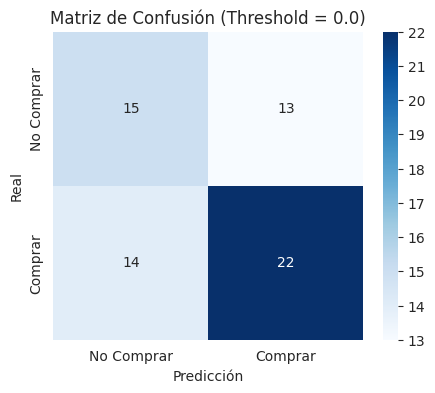

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# ==========================
# Definir threshold
# ==========================
threshold = 0.0  # cámbialo a lo que quieras

# Convertir predicciones y reales a señales binarias
# 1 = Comprar, 0 = No comprar
y_pred_signal = (y_pred > threshold).astype(int)
y_real_signal = (y_test_real > threshold).astype(int)

# ==========================
# Matriz de confusión
# ==========================
cm = confusion_matrix(y_real_signal, y_pred_signal)

print("📊 Matriz de confusión:")
print(cm)
print("\n📋 Reporte de clasificación:")
print(classification_report(y_real_signal, y_pred_signal, target_names=["No Comprar", "Comprar"]))

# ==========================
# Visualizar matriz
# ==========================
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["No Comprar", "Comprar"],
            yticklabels=["No Comprar", "Comprar"])
plt.title(f"Matriz de Confusión (Threshold = {threshold})")
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()


#### LSTM

Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0489 - mae: 0.1649 - rmse: 0.2134 - val_loss: 0.0085 - val_mae: 0.0637 - val_rmse: 0.0923
Epoch 2/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0235 - mae: 0.1190 - rmse: 0.1515 - val_loss: 0.0066 - val_mae: 0.0665 - val_rmse: 0.0812
Epoch 3/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0181 - mae: 0.1075 - rmse: 0.1341 - val_loss: 0.0015 - val_mae: 0.0321 - val_rmse: 0.0386
Epoch 4/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0106 - mae: 0.0801 - rmse: 0.1022 - val_loss: 7.6250e-04 - val_mae: 0.0220 - val_rmse: 0.0276
Epoch 5/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0071 - mae: 0.0650 - rmse: 0.0830 - val_loss: 5.7747e-04 - val_mae: 0.0184 - val_rmse: 0.0240
Epoch 6/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0057 - mae: 0.0585 - rmse: 0.0741 - val_loss: 7.1119e-04 - val_mae: 0.0220 - val_rmse: 0.0267
Epoch 7/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0040 - mae: 0.0500 - rmse: 0.063

/tmp/ipython-input-4166040105.py:116: RuntimeWarning: invalid value encountered in log
  y_test_logret = np.log(y_test_real[1:] / y_test_real[:-1])
/tmp/ipython-input-4166040105.py:117: RuntimeWarning: invalid value encountered in log
  y_pred_logret = np.log(y_pred[1:] / y_pred[:-1])


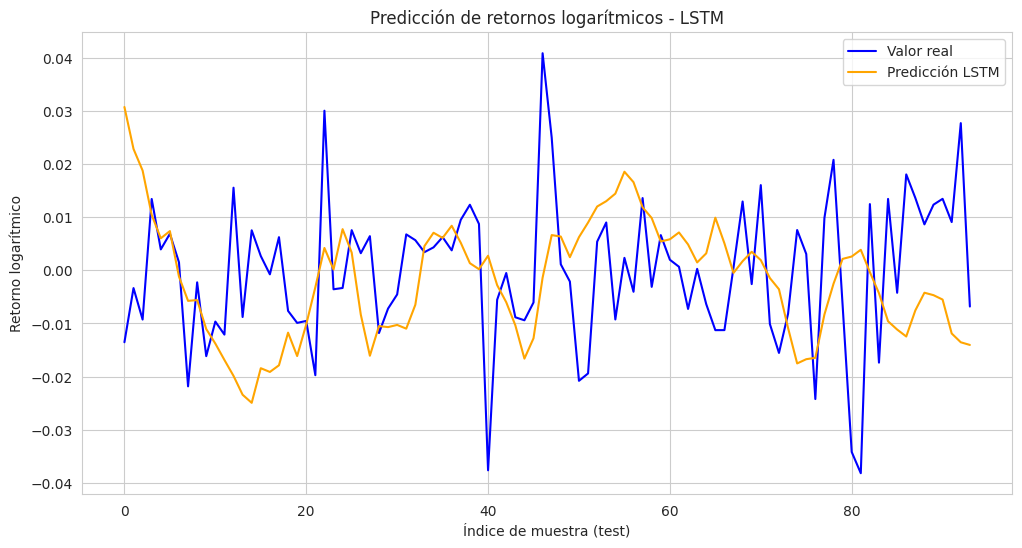

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

# ==========================
# Configuración
# ==========================
WINDOW = 30
fecha_corte = '2023-01-01'
threshold_log = 0
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# ==========================
# Preparar datos
# ==========================
df_reg_combined = df_reg_combined.dropna()

mask_train = df_reg_combined['Date'] < fecha_corte
mask_test  = df_reg_combined['Date'] >= fecha_corte

features = [c for c in df_reg_combined.columns if c not in ['Target', 'Date']]

X_train_df = df_reg_combined.loc[mask_train, features]
y_train_sr = df_reg_combined.loc[mask_train, 'Target']

X_test_df = df_reg_combined.loc[mask_test, features]
y_test_sr = df_reg_combined.loc[mask_test, 'Target']
dates_test = df_reg_combined.loc[mask_test, 'Date'].values

# Escalar solo X
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train_df)
X_test_scaled  = scaler_X.transform(X_test_df)

# Crear secuencias
def make_sequences(X_2d, y_1d, window=60):
    X_seq, y_seq = [], []
    for i in range(window, len(X_2d)):
        X_seq.append(X_2d[i-window:i, :])
        y_seq.append(y_1d[i])
    return np.asarray(X_seq, dtype=np.float32), np.asarray(y_seq, dtype=np.float32)

X_train_seq, y_train_seq = make_sequences(X_train_scaled, y_train_sr.values, WINDOW)
X_test_seq,  y_test_seq  = make_sequences(X_test_scaled,  y_test_sr.values,  WINDOW)
dates_test_seq = dates_test[WINDOW:]

# ==========================
# Validación
# ==========================
val_fraction = 0.1
n_train = len(X_train_seq)
n_val = int(np.floor(n_train * val_fraction))
n_tr  = n_train - n_val

X_tr, y_tr = X_train_seq[:n_tr], y_train_seq[:n_tr]
X_val, y_val = X_train_seq[n_tr:], y_train_seq[n_tr:]

# ==========================
# Modelo LSTM
# ==========================
model = keras.Sequential([
    layers.LSTM(64, return_sequences=True, input_shape=(WINDOW, X_train_seq.shape[-1])),
    layers.Dropout(0.2),
    layers.LSTM(64),
    layers.Dropout(0.2),
    layers.Dense(1)  # salida lineal para regresión
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='mse',
    metrics=['mae', keras.metrics.RootMeanSquaredError(name='rmse')]
)

es = keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=3, restore_best_weights=True
)

history = model.fit(
    X_tr, y_tr,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=64,
    shuffle=False,
    #callbacks=[es],
    verbose=1
)

# ==========================
# Predicciones (escala real)
# ==========================
y_pred = model.predict(X_test_seq).ravel()
y_test_real = y_test_seq

# ==========================
# Métricas regresión
# ==========================
mse = mean_squared_error(y_test_real, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_real, y_pred)

print(f"📏 MSE:  {mse:.6f}")
print(f"📏 RMSE: {rmse:.6f}")
print(f"📏 R²:   {r2:.6f}")

# ==========================
# Clasificación Buy/Sell
# ==========================
y_test_logret = np.log(y_test_real[1:] / y_test_real[:-1])
y_pred_logret = np.log(y_pred[1:] / y_pred[:-1])

y_test_bin = (y_test_logret > threshold_log).astype(int)
y_pred_bin = (y_pred_logret > threshold_log).astype(int)
dates_bin = dates_test_seq[1:]

print(f"\nClasificación Buy/Sell con threshold log={threshold_log}")
print(f"Accuracy: {accuracy_score(y_test_bin, y_pred_bin):.4f}")
print("\nMatriz de confusión:")
print(confusion_matrix(y_test_bin, y_pred_bin))
print("\nReporte de clasificación:")
print(classification_report(y_test_bin, y_pred_bin, digits=4))

# ==========================
# Guardar resultados
# ==========================
df_pred_reg_combined_lstm = pd.DataFrame({
    'Date': dates_bin,
    'y_real_price': y_test_real[1:],
    'y_real_logret': y_test_logret,
    'y_real_bin': y_test_bin,
    'y_pred_price': y_pred[1:],
    'y_pred_logret': y_pred_logret,
    'y_pred_bin': y_pred_bin
})
print(f"📂 Predicciones guardadas: {df_pred_reg_combined_lstm.shape[0]} filas")

# ==========================
# Gráfico pred vs real
# ==========================
plt.figure(figsize=(12,6))
plt.plot(y_test_real, label='Valor real', color='blue')
plt.plot(y_pred, label='Predicción LSTM', color='orange')
plt.title('Predicción de retornos logarítmicos - LSTM')
plt.xlabel('Índice de muestra (test)')
plt.ylabel('Retorno logarítmico')
plt.legend()
plt.grid(True)
plt.show()


Matriz de confusión:
[[26 20]
 [24 24]]

Reporte de clasificación:
              precision    recall  f1-score   support

  No Comprar       0.52      0.57      0.54        46
     Comprar       0.55      0.50      0.52        48

    accuracy                           0.53        94
   macro avg       0.53      0.53      0.53        94
weighted avg       0.53      0.53      0.53        94



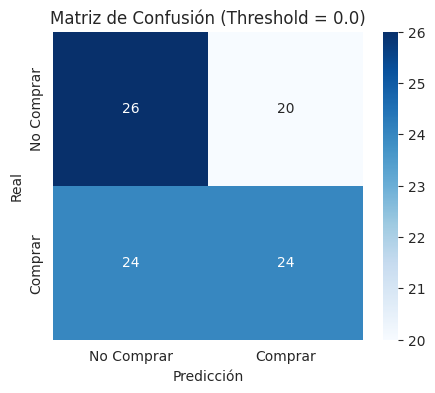

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# ==========================
# Definir threshold
# ==========================
threshold = 0.0  # por ejemplo: 0.0 significa "compro si pred > 0"

# Predicciones binarias según threshold
y_pred_class = (y_pred > threshold).astype(int)
y_test_class = (y_test_real > threshold).astype(int)

# Matriz de confusión
cm = confusion_matrix(y_test_class, y_pred_class)

# Reporte
print("Matriz de confusión:")
print(cm)
print("\nReporte de clasificación:")
print(classification_report(y_test_class, y_pred_class, target_names=["No Comprar", "Comprar"]))

# ==========================
# Visualizar matriz de confusión
# ==========================
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["No Comprar", "Comprar"],
            yticklabels=["No Comprar", "Comprar"])
plt.title(f'Matriz de Confusión (Threshold = {threshold})')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()


## Modelo Ensemble

## Comparación de modelos y Conclusiones

# MODELO ENSEMLE


In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# --- Catálogo de posibles nombres por modelo (pon aquí los que realmente has creado) ---
candidatos = [
    # Reglas (sentimiento)
    ("Rule (weighted sentiment)", ["df_pred_rule_weighted", "df_pred_sentiment_rule_weighted", "df_pred_sentiment_rules"]),
    ("Rule (mean sentiment)",     ["df_pred_rule_mean"]),

    # Clasificación – solo sentimiento
    ("Sentiment RF",              ["df_pred_sentiment_rf", "df_pred_sentiment_rf_rs", "df_pred_sentiment_rf_grid"]),
    ("Sentiment GRU",             ["df_pred_sentiment_gru"]),
    ("Sentiment LSTM",            ["df_pred_sentiment_lstm"]),

    # Clasificación – técnicas (Top-20)
    ("TA RF",                     ["df_pred_ta_rf", "df_pred_ta_rf_rs", "df_pred_ta_rf_grid"]),
    ("TA GRU",                    ["df_pred_ta_gru"]),
    ("TA LSTM",                   ["df_pred_ta_lstm"]),

    # Clasificación – combinado (Top-20 + sentimientos)
    ("Combined RF",               ["df_pred_combined_rf", "df_pred_combined_rf_rs", "df_pred_combined_rf_grid"]),
    ("Combined GRU",              ["df_pred_combined_gru"]),
    ("Combined LSTM",             ["df_pred_combined_lstm"]),

    # Regresión → binarizado por umbral (solo sentimiento)
    ("Reg Sentiment RF",          ["df_pred_reg_sentiment_rf"]),
    ("Reg Sentiment GRU",         ["df_pred_reg_sentiment_gru"]),
    ("Reg Sentiment LSTM",        ["df_pred_reg_sentiment_lstm"]),

    # Regresión → binarizado por umbral (técnicas)
    ("Reg TA RF",                 ["df_pred_reg_ta_rf"]),
    ("Reg TA GRU",                ["df_pred_reg_ta_gru"]),
    ("Reg TA LSTM",               ["df_pred_reg_ta_lstm"]),

    # Regresión → binarizado por umbral (combinado)
    ("Reg Combined RF",           ["df_pred_reg_combined_rf"]),
    ("Reg Combined GRU",          ["df_pred_reg_combined_gru"]),
    ("Reg Combined LSTM",         ["df_pred_reg_combined_lstm"]),
]

# --- Utilidades para localizar df y estandarizar columnas ---
def pick_df(name_list):
    for n in name_list:
        if n in globals():
            return globals()[n]
    return None

def estandariza_cols(df):
    cols = set(df.columns)

    # y_true
    if "y_real_bin" in cols:
        y_true = df["y_real_bin"]
    elif "y_real" in cols:
        y_true = df["y_real"]
    elif "Target" in cols:
        y_true = df["Target"]
    else:
        return None, None  # no hay verdad-terreno

    # y_pred binario
    if "y_pred_bin" in cols:
        y_pred = df["y_pred_bin"]
    else:
        # intenta encontrar una columna de pred binaria/entera
        cand_pred_bin = [c for c in df.columns if c.startswith(("y_pred", "pred")) and df[c].dropna().isin([0,1]).all()]
        if cand_pred_bin:
            y_pred = df[cand_pred_bin[0]]
        elif "y_prob" in cols:
            # si solo hay probabilidades, aplica umbral 0.5 por defecto
            y_pred = (df["y_prob"] >= 0.5).astype(int)
        else:
            # último recurso: buscar cualquier columna pred y binarizar a 0/1 si es float
            cand_pred_prob = [c for c in df.columns if c.startswith(("y_pred", "pred")) and df[c].dtype.kind in "fc"]
            if cand_pred_prob:
                y_pred = (df[cand_pred_prob[0]] >= 0.5).astype(int)
            else:
                return None, None

    # limpia y castea
    pair = pd.concat([y_true, y_pred], axis=1).dropna()
    y_true_clean = pair.iloc[:,0].astype(int)
    y_pred_clean = pair.iloc[:,1].astype(int)
    return y_true_clean, y_pred_clean

# --- Construir resumen ---
metrics_list = []
for etiqueta, posibles_nombres in candidatos:
    df = pick_df(posibles_nombres)
    if df is None:
        continue
    y_true, y_pred = estandariza_cols(df)
    if y_true is None:
        continue
    metrics_list.append({
        "Modelo": etiqueta,
        "Accuracy (%)": accuracy_score(y_true, y_pred) * 100.0,
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall": recall_score(y_true, y_pred, zero_division=0),
        "F1-Score": f1_score(y_true, y_pred, zero_division=0),
        "Test Samples": len(y_true)
    })

df_summary = pd.DataFrame(metrics_list).sort_values(by="Accuracy (%)", ascending=False).reset_index(drop=True)

pd.set_option('display.float_format', '{:.4f}'.format)
print(df_summary)


                Modelo  Accuracy (%)  Precision  Recall  F1-Score  \
0     Reg Sentiment RF       62.7615     0.2581  0.2712    0.2645   
1    Reg Combined LSTM       62.3656     0.3778  0.7083    0.4928   
2        Combined LSTM       60.9375     0.6897  0.5556    0.6154   
3         Combined GRU       60.6383     0.6667  0.4583    0.5432   
4     Reg Combined GRU       58.7302     0.3200  0.4706    0.3810   
5      Reg Combined RF       58.5774     0.2500  0.3390    0.2878   
6    Reg Sentiment GRU       57.1429     0.3077  0.4706    0.3721   
7         Sentiment RF       54.0323     0.5556  0.6154    0.5839   
8        Sentiment GRU       53.2258     0.5285  1.0000    0.6915   
9       Sentiment LSTM       51.6129     0.5214  0.9385    0.6703   
10         Combined RF       45.9677     0.4773  0.3231    0.3853   
11  Reg Sentiment LSTM       42.8571     0.2564  0.5882    0.3571   

    Test Samples  
0            239  
1             93  
2             64  
3             94  
4      

Ensemble con Accuracy

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# =====================================================
# 1) MODELOS DISPONIBLES (pon solo los que existan)
# =====================================================
model_dfs = {
    "Reg Sentiment RF":   df_pred_reg_sentiment_rf,
    "Reg Combined RF":    df_pred_reg_combined_rf,
    "Reg Combined GRU":   df_pred_reg_combined_gru,
    "Reg Sentiment LSTM": df_pred_reg_sentiment_lstm,
    "Sentiment RF":       df_pred_sentiment_rf,
    "Reg Combined LSTM":  df_pred_reg_combined_lstm,
    "Combined GRU":       df_pred_combined_gru,
    "Combined LSTM":      df_pred_combined_lstm,
    "Sentiment LSTM":     df_pred_sentiment_lstm,
    "Reg Sentiment GRU":  df_pred_reg_sentiment_gru,
    "Combined RF":        df_pred_combined_rf,
    "Sentiment GRU":      df_pred_sentiment_gru,
}

# =====================================================
# 2) Hiperparámetros del ensemble
# =====================================================
THRESH = 0.5   # umbral de cada modelo (para convertir a voto 0/1)
ALPHA  = 7.0   # temperatura del softmax de pesos

# =====================================================
# 3) Construir pesos desde df_summary (Accuracy %)
# =====================================================
present_names = [name for name in model_dfs.keys() if name in getattr(pd, 'Series')(model_dfs).index]

df_acc = df_summary[df_summary["Modelo"].isin(present_names)].set_index("Modelo").reindex(present_names)

if df_acc["Accuracy (%)"].isna().all():
    acc_values = np.ones(len(present_names), dtype=float)
else:
    acc_values = (df_acc["Accuracy (%)"].fillna(df_acc["Accuracy (%)"].mean()).values) / 100.0

# Softmax sobre accuracy
exp_scores = np.exp(ALPHA * (acc_values - np.mean(acc_values)))
weights = exp_scores / exp_scores.sum()
w_map = {name: w for name, w in zip(present_names, weights)}

print("Pesos del ensemble (softmax por accuracy):")
for n in present_names:
    print(f"  {n}: {w_map[n]:.4f}")

# =====================================================
# 4) Pasar cada modelo a formato largo: [Date, model, prob] (+ y_true si hay)
# =====================================================
long_parts = []
y_true_pool = []

def _ensure_date_index(df):
    if "Date" not in df.columns:
        if isinstance(df.index, pd.DatetimeIndex):
            df = df.reset_index().rename(columns={"index":"Date"})
        else:
            raise ValueError("El DF no tiene columna 'Date' ni índice DateTimeIndex.")
    return df

for name, df in model_dfs.items():
    if name not in present_names:
        continue
    df_ = _ensure_date_index(df.copy())
    prob_col = None
    for c in ["y_prob", "y_pred_prob"]:
        if c in df_.columns:
            prob_col = c
            break
    if prob_col is None:
        for c in ["y_pred_bin", "y_pred", "pred"]:
            if c in df_.columns:
                vals = df_[c].dropna().unique()
                if len(vals) == 0 or set(pd.Series(vals).astype(int)).issubset({0,1}):
                    prob_col = c
                    break
    if prob_col is None:
        print(f"⚠️  {name}: no encuentro columnas de probas ni binarias. Lo salto.")
        continue

    tmp = df_[["Date", prob_col]].rename(columns={prob_col: "prob"}).dropna()
    tmp["Modelo"] = name
    long_parts.append(tmp)

    for yt in ["y_real_bin", "y_real", "Target"]:
        if yt in df_.columns:
            y_true_pool.append(df_[["Date", yt]].dropna().rename(columns={yt:"y_true"}))
            break

if not long_parts:
    raise ValueError("No hay ninguna predicción válida para el ensemble.")

long_df = pd.concat(long_parts, ignore_index=True)
long_df["prob"] = long_df["prob"].clip(0,1)

if y_true_pool:
    y_true_df = pd.concat(y_true_pool, ignore_index=True).drop_duplicates(subset=["Date"])
else:
    y_true_df = pd.DataFrame(columns=["Date","y_true"])

# =====================================================
# 5) Ensemble con VOTO DURO PONDERADO
# =====================================================
# Paso 1: convertir prob en voto binario
long_df["vote"] = (long_df["prob"] >= THRESH).astype(int)

# Paso 2: añadir pesos por modelo
long_df["weight"] = long_df["Modelo"].map(w_map).astype(float)

# Paso 3: agregación por fecha (mayoría ponderada de votos)
agg = long_df.groupby("Date").apply(
    lambda g: pd.Series({
        "sum_w": g["weight"].sum(),
        "score": (g["weight"] * g["vote"]).sum() / (g["weight"].sum() if g["weight"].sum() > 0 else np.nan),
        "n_models": g.shape[0],
        "models_used": ", ".join(g["Modelo"].tolist())
    })
).reset_index()

# Pred binaria del ensemble
agg["y_pred_ensemble"] = (agg["score"] >= 0.5).astype(int)

# Merge con y_true
df_pred_ensemble = agg.merge(y_true_df, on="Date", how="left")

# =====================================================
# 6) Métricas (solo en fechas con y_true)
# =====================================================
mask_eval = df_pred_ensemble["y_true"].notna()
if mask_eval.any():
    y_true = df_pred_ensemble.loc[mask_eval, "y_true"].astype(int).values
    y_pred = df_pred_ensemble.loc[mask_eval, "y_pred_ensemble"].astype(int).values

    print("\n=== Ensemble (fechas con ground truth) ===")
    print(f"Fechas evaluadas: {mask_eval.sum()} (de {len(df_pred_ensemble)})")
    print(f"Accuracy:  {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred, zero_division=0):.4f}")
    print(f"Recall:    {recall_score(y_true, y_pred, zero_division=0):.4f}")
    print(f"F1-Score:  {f1_score(y_true, y_pred, zero_division=0):.4f}")
    print("\nMatriz de confusión:")
    print(confusion_matrix(y_true, y_pred))
    print("\nReporte de clasificación:")
    print(classification_report(y_true, y_pred, target_names=["No Comprar","Comprar"], digits=4))
else:
    print("\n(No hay y_true para evaluar; te dejo solo las predicciones por fecha.)")

# =====================================================
# 7) Resultado final
# =====================================================
print(f"\n✅ Ensemble listo: {df_pred_ensemble.shape[0]} fechas, media de modelos usados = {df_pred_ensemble['n_models'].mean():.2f}")
df_pred_ensemble.head()


Pesos del ensemble (softmax por accuracy):
  Reg Sentiment RF: 0.1256
  Reg Combined RF: 0.0937
  Reg Combined GRU: 0.0947
  Reg Sentiment LSTM: 0.0312
  Sentiment RF: 0.0682
  Reg Combined LSTM: 0.1222
  Combined GRU: 0.1083
  Combined LSTM: 0.1106
  Sentiment LSTM: 0.0576
  Reg Sentiment GRU: 0.0848
  Combined RF: 0.0388
  Sentiment GRU: 0.0644
⚠️  Sentiment RF: no encuentro columnas de probas ni binarias. Lo salto.
⚠️  Combined GRU: no encuentro columnas de probas ni binarias. Lo salto.
⚠️  Combined LSTM: no encuentro columnas de probas ni binarias. Lo salto.
⚠️  Sentiment LSTM: no encuentro columnas de probas ni binarias. Lo salto.
⚠️  Combined RF: no encuentro columnas de probas ni binarias. Lo salto.
⚠️  Sentiment GRU: no encuentro columnas de probas ni binarias. Lo salto.

=== Ensemble (fechas con ground truth) ===
Fechas evaluadas: 239 (de 239)
Accuracy:  0.6360
Precision: 0.2941
Recall:    0.3390
F1-Score:  0.3150

Matriz de confusión:
[[132  48]
 [ 39  20]]

Reporte de clasif

/tmp/ipython-input-4023559778.py:114: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  agg = long_df.groupby("Date").apply(


,Date,sum_w,score,n_models,models_used,y_pred_ensemble,y_true
0,2023-01-04,0.2193,0.0000,2,"Reg Sentiment RF, Reg Combined RF",0,1
1,2023-01-05,0.2193,0.5727,2,"Reg Sentiment RF, Reg Combined RF",1,1
2,2023-01-06,0.2193,0.0000,2,"Reg Sentiment RF, Reg Combined RF",0,0
3,2023-01-09,0.2193,0.5727,2,"Reg Sentiment RF, Reg Combined RF",1,0
4,2023-01-10,0.2193,0.0000,2,"Reg Sentiment RF, Reg Combined RF",0,0


# Ensemble con Precisión

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)

# =====================================================
# 1) MODELOS DISPONIBLES  (igual que tenías)
# =====================================================
model_dfs = {
    "Reg Sentiment RF":   df_pred_reg_sentiment_rf,
    "Reg Combined RF":    df_pred_reg_combined_rf,
    "Reg Combined GRU":   df_pred_reg_combined_gru,
    "Reg Sentiment LSTM": df_pred_reg_sentiment_lstm,
    "Sentiment RF":       df_pred_sentiment_rf,
    "Reg Combined LSTM":  df_pred_reg_combined_lstm,
    "Combined GRU":       df_pred_combined_gru,
    "Combined LSTM":      df_pred_combined_lstm,
    "Sentiment LSTM":     df_pred_sentiment_lstm,
    "Reg Sentiment GRU":  df_pred_reg_sentiment_gru,
    "Combined RF":        df_pred_combined_rf,
    "Sentiment GRU":      df_pred_sentiment_gru,
}

# =====================================================
# 2) Hiperparámetros del ensemble
# =====================================================
THRESH = 0.5     # umbral para voto binario por modelo
ALPHA  = 7    # temperatura del softmax (más alto => más separación)

# =====================================================
# 3) Construir pesos desde df_summary (PRECISIÓN)
#    - Acepta columnas: "Precision", "Precision (%)"
#    - Detecta escala: 0–1 o 0–100 automáticamente
# =====================================================

# Modelos presentes con DataFrame válido
present_names = [name for name, df in model_dfs.items() if df is not None]

# Detecta columna de precisión disponible
prec_col_candidates = ["Precision", "Precision (%)", "precision", "precision (%)"]
available_cols = [c for c in prec_col_candidates if c in df_summary.columns]
if not available_cols:
    raise ValueError(
        "df_summary no contiene una columna de precisión reconocible. "
        "Usa una de: 'Precision', 'Precision (%)', 'precision', 'precision (%)'."
    )
prec_col = available_cols[0]

# Filtra y ordena segun present_names
df_prec = (df_summary[df_summary["Modelo"].isin(present_names)]
           .set_index("Modelo")
           .reindex(present_names))

# Rellena NaNs con la media para no perder modelos
prec_raw = df_prec[prec_col].astype(float)
prec_filled = prec_raw.fillna(prec_raw.mean())

# Normaliza escala: si parece 0–100, pásalo a 0–1
max_val = prec_filled.max()
if max_val > 1.5:  # umbral simple para detectar porcentajes
    prec_values = (prec_filled / 100.0).values
else:
    prec_values = prec_filled.values

# Seguridad: recorta a [0,1]
prec_values = np.clip(prec_values, 0.0, 1.0)

# Si toda la precisión es igual (caso degenerado), usa pesos uniformes
if np.allclose(prec_values, prec_values.mean()):
    weights = np.ones_like(prec_values) / len(prec_values)
else:
    # Softmax centrado (resta de la media mejora la estabilidad numérica)
    exp_scores = np.exp(ALPHA * (prec_values - prec_values.mean()))
    weights = exp_scores / exp_scores.sum()

w_map = {name: float(w) for name, w in zip(present_names, weights)}

print("Pesos del ensemble (softmax por precisión):")
for n in present_names:
    print(f"  {n}: {w_map[n]:.4f}")

# =====================================================
# 4) Pasar cada modelo a formato largo (igual que tenías, con pequeñas mejoras)
# =====================================================
long_parts = []
y_true_pool = []

def _ensure_date_index(df):
    if "Date" not in df.columns:
        if isinstance(df.index, pd.DatetimeIndex):
            df = df.reset_index().rename(columns={"index": "Date"})
        else:
            raise ValueError("El DF no tiene columna 'Date' ni índice DateTimeIndex.")
    return df

for name, df in model_dfs.items():
    if name not in present_names:
        continue
    df_ = _ensure_date_index(df.copy())

    # Busca probas o binario
    prob_col = None
    for c in ["y_prob", "y_pred_prob"]:
        if c in df_.columns:
            prob_col = c
            break
    if prob_col is None:
        for c in ["y_pred_bin", "y_pred", "pred"]:
            if c in df_.columns:
                vals = df_[c].dropna().unique()
                if len(vals) == 0 or set(pd.Series(vals).astype(int)).issubset({0, 1}):
                    prob_col = c
                    break
    if prob_col is None:
        print(f"⚠️  {name}: no encuentro columnas de probas/binarias. Lo salto.")
        continue

    tmp = df_[["Date", prob_col]].rename(columns={prob_col: "prob"}).dropna()
    tmp["Modelo"] = name
    long_parts.append(tmp)

    # Recoge y_true si existe
    for yt in ["y_real_bin", "y_real", "Target"]:
        if yt in df_.columns:
            y_true_pool.append(
                df_[["Date", yt]].dropna().rename(columns={yt: "y_true"})
            )
            break

if not long_parts:
    raise ValueError("No hay ninguna predicción válida para el ensemble.")

long_df = pd.concat(long_parts, ignore_index=True)
# Si 'prob' es binaria, quedará 0/1; si es proba, recortamos a [0,1]
long_df["prob"] = long_df["prob"].clip(0, 1)

if y_true_pool:
    y_true_df = pd.concat(y_true_pool, ignore_index=True).drop_duplicates(subset=["Date"])
else:
    y_true_df = pd.DataFrame(columns=["Date", "y_true"])

# =====================================================
# 5) Voto duro ponderado (basado en precisión)
# =====================================================
long_df["vote"] = (long_df["prob"] >= THRESH).astype(int)
long_df["weight"] = long_df["Modelo"].map(w_map).astype(float)

agg = (long_df.groupby("Date").apply(
    lambda g: pd.Series({
        "sum_w": g["weight"].sum(),
        "score": (g["weight"] * g["vote"]).sum() / (g["weight"].sum() if g["weight"].sum() > 0 else np.nan),
        "n_models": g.shape[0],
        "models_used": ", ".join(g["Modelo"].tolist())
    })
).reset_index())

agg["y_pred_ensemble"] = (agg["score"] >= 0.5).astype(int)

df_pred_ensemble = agg.merge(y_true_df, on="Date", how="left")

# =====================================================
# 6) Métricas
# =====================================================
mask_eval = df_pred_ensemble["y_true"].notna()
if mask_eval.any():
    y_true = df_pred_ensemble.loc[mask_eval, "y_true"].astype(int).values
    y_pred = df_pred_ensemble.loc[mask_eval, "y_pred_ensemble"].astype(int).values

    print("\n=== Ensemble (fechas con ground truth) ===")
    print(f"Fechas evaluadas: {mask_eval.sum()} (de {len(df_pred_ensemble)})")
    print(f"Accuracy:  {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred, zero_division=0):.4f}")
    print(f"Recall:    {recall_score(y_true, y_pred, zero_division=0):.4f}")
    print(f"F1-Score:  {f1_score(y_true, y_pred, zero_division=0):.4f}")
    print("\nMatriz de confusión:")
    print(confusion_matrix(y_true, y_pred))
    print("\nReporte de clasificación:")
    print(classification_report(y_true, y_pred, target_names=["No Comprar", "Comprar"], digits=4))
else:
    print("\n(No hay y_true para evaluar; te dejo solo las predicciones por fecha.)")

# =====================================================
# 7) Resultado final
# =====================================================
print(f"\n✅ Ensemble listo: {df_pred_ensemble.shape[0]} fechas, media de modelos usados = {df_pred_ensemble['n_models'].mean():.2f}")
df_pred_ensemble.head()


Pesos del ensemble (softmax por precisión):
  Reg Sentiment RF: 0.0139
  Reg Combined RF: 0.0132
  Reg Combined GRU: 0.0215
  Reg Sentiment LSTM: 0.0138
  Sentiment RF: 0.1118
  Reg Combined LSTM: 0.0322
  Combined GRU: 0.2432
  Combined LSTM: 0.2857
  Sentiment LSTM: 0.0880
  Reg Sentiment GRU: 0.0197
  Combined RF: 0.0646
  Sentiment GRU: 0.0924
⚠️  Sentiment RF: no encuentro columnas de probas/binarias. Lo salto.
⚠️  Combined GRU: no encuentro columnas de probas/binarias. Lo salto.
⚠️  Combined LSTM: no encuentro columnas de probas/binarias. Lo salto.
⚠️  Sentiment LSTM: no encuentro columnas de probas/binarias. Lo salto.
⚠️  Combined RF: no encuentro columnas de probas/binarias. Lo salto.
⚠️  Sentiment GRU: no encuentro columnas de probas/binarias. Lo salto.


/tmp/ipython-input-1521461204.py:150: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  agg = (long_df.groupby("Date").apply(



=== Ensemble (fechas con ground truth) ===
Fechas evaluadas: 239 (de 239)
Accuracy:  0.6611
Precision: 0.3553
Recall:    0.4576
F1-Score:  0.4000

Matriz de confusión:
[[131  49]
 [ 32  27]]

Reporte de clasificación:
              precision    recall  f1-score   support

  No Comprar     0.8037    0.7278    0.7638       180
     Comprar     0.3553    0.4576    0.4000        59

    accuracy                         0.6611       239
   macro avg     0.5795    0.5927    0.5819       239
weighted avg     0.6930    0.6611    0.6740       239


✅ Ensemble listo: 239 fechas, media de modelos usados = 3.18


,Date,sum_w,score,n_models,models_used,y_pred_ensemble,y_true
0,2023-01-04,0.0271,0.0000,2,"Reg Sentiment RF, Reg Combined RF",0,1
1,2023-01-05,0.0271,0.5141,2,"Reg Sentiment RF, Reg Combined RF",1,1
2,2023-01-06,0.0271,0.0000,2,"Reg Sentiment RF, Reg Combined RF",0,0
3,2023-01-09,0.0271,0.5141,2,"Reg Sentiment RF, Reg Combined RF",1,0
4,2023-01-10,0.0271,0.0000,2,"Reg Sentiment RF, Reg Combined RF",0,0


# ENSEMBLE SOFTMAX ACCURACY + PRECISION con enfoque en ACCURACY

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)

# =====================================================
# 1) Construcción de model_dfs dinámicamente (desde catálogo)
# =====================================================
candidatos = [
    ("Reg Sentiment RF",   ["df_pred_reg_sentiment_rf"]),
    ("Reg Combined RF",    ["df_pred_reg_combined_rf"]),
    ("Reg Combined GRU",   ["df_pred_reg_combined_gru"]),
    ("Reg Sentiment LSTM", ["df_pred_reg_sentiment_lstm"]),
    ("Sentiment RF",       ["df_pred_sentiment_rf"]),
    ("Reg Combined LSTM",  ["df_pred_reg_combined_lstm"]),
    ("Combined GRU",       ["df_pred_combined_gru"]),
    ("Combined LSTM",      ["df_pred_combined_lstm"]),
    ("Sentiment LSTM",     ["df_pred_sentiment_lstm"]),
    ("Reg Sentiment GRU",  ["df_pred_reg_sentiment_gru"]),
    ("Combined RF",        ["df_pred_combined_rf"]),
    ("Sentiment GRU",      ["df_pred_sentiment_gru"]),
]

model_dfs = {}
for nombre_modelo, posibles_vars in candidatos:
    df_encontrado = None
    for var in posibles_vars:
        if var in globals() and isinstance(globals()[var], pd.DataFrame):
            df_encontrado = globals()[var]
            break
    model_dfs[nombre_modelo] = df_encontrado

present_names = [name for name, df in model_dfs.items() if df is not None]

print("📊 Modelos disponibles:")
for name, df in model_dfs.items():
    print(f" - {name}: {'✅' if df is not None else '❌'}")

# =====================================================
# 2) Hiperparámetros
# =====================================================
TOP_K = 5
ALPHA = 10  # "temperatura" del softmax (más alto = más contraste)
BETA_ACC = 1
BETA_PREC = 0

# =====================================================
# 3) Ranking Top-K por combinación Accuracy+Precision
# =====================================================
if "Modelo" not in df_summary.columns:
    raise ValueError("df_summary debe contener la columna 'Modelo'.")

df_metrics = df_summary[df_summary["Modelo"].isin(present_names)].copy()
if df_metrics.empty:
    raise ValueError("Ninguno de los modelos presentes aparece en df_summary['Modelo'].")

# Normalizamos métricas (0-1)
for col in ["Accuracy", "Accuracy (%)"]:
    if col in df_metrics.columns:
        df_metrics["Accuracy01"] = pd.to_numeric(df_metrics[col], errors="coerce").fillna(0.0)
        if df_metrics["Accuracy01"].max() > 1.5:
            df_metrics["Accuracy01"] /= 100.0
        df_metrics["Accuracy01"] = df_metrics["Accuracy01"].clip(0.0, 1.0)
        break

if "Precision" not in df_metrics.columns:
    raise ValueError("df_summary debe contener columna 'Precision'.")
df_metrics["Precision01"] = pd.to_numeric(df_metrics["Precision"], errors="coerce").fillna(0.0).clip(0.0, 1.0)

# Métrica combinada
df_metrics["_combo"] = (BETA_ACC * df_metrics["Accuracy01"] +
                        BETA_PREC * df_metrics["Precision01"])

# Softmax centrado
mean_combo = df_metrics["_combo"].mean()
exp_scores = np.exp(ALPHA * (df_metrics["_combo"] - mean_combo))
df_metrics["_weight"] = exp_scores / exp_scores.sum()

# Ordenar por peso
df_metrics = df_metrics.sort_values("_weight", ascending=False).reset_index(drop=True)
top_models = df_metrics.loc[:TOP_K-1, "Modelo"].tolist()

print(f"\n➡️ Ranking por combinación Accuracy ({BETA_ACC}) + Precision ({BETA_PREC}), con softmax α={ALPHA}")
for i, row in df_metrics.head(TOP_K).iterrows():
    print(f" {i+1:>2}. {row['Modelo']:20s} — combo={row['_combo']:.4f}, peso={row['_weight']:.3f}")

# =====================================================
# 4) Construcción de long_df (usando pred_bin* o y_pred_bin*)
# =====================================================
def _ensure_date_index(df):
    if "Date" not in df.columns:
        if isinstance(df.index, pd.DatetimeIndex):
            df = df.reset_index().rename(columns={"index": "Date"})
        else:
            raise ValueError("El DF no tiene columna 'Date' ni índice DateTimeIndex.")
    return df

long_parts = []
y_true_pool = []

for name in top_models:
    df = model_dfs.get(name)
    if df is None:
        continue
    df_ = _ensure_date_index(df.copy())

    # buscar columnas que empiecen por "pred_bin" o "y_pred_bin"
    bin_cols = [c for c in df_.columns if c.startswith("pred_bin") or c.startswith("y_pred_bin")]
    if not bin_cols:
        print(f"⚠️ {name}: no encuentro columnas pred_bin* ni y_pred_bin*. Lo salto.")
        continue

    col = bin_cols[0]
    tmp = df_[["Date", col]].rename(columns={col: "vote"}).dropna()
    tmp["vote"] = tmp["vote"].astype(int).clip(0, 1)
    tmp["Modelo"] = name
    long_parts.append(tmp)

    # recogemos y_true si existe
    for yt in ["y_real_bin", "y_real", "Target"]:
        if yt in df_.columns:
            y_true_pool.append(df_[["Date", yt]].dropna().rename(columns={yt: "y_true"}))
            break

if not long_parts:
    raise ValueError("No hay ninguna predicción binaria válida para el ensemble.")

long_df = pd.concat(long_parts, ignore_index=True)

if y_true_pool:
    y_true_df = pd.concat(y_true_pool, ignore_index=True).drop_duplicates(subset=["Date"])
else:
    y_true_df = pd.DataFrame(columns=["Date", "y_true"])

# =====================================================
# 5) Votación ponderada por softmax
# =====================================================
# Mapa de pesos por modelo
weights_map = dict(zip(df_metrics["Modelo"], df_metrics["_weight"]))

# Agregamos predicciones ponderadas
agg = (long_df.groupby("Date")
       .apply(lambda g: pd.Series({
           "score": np.average(g["vote"], weights=[weights_map[m] for m in g["Modelo"]]),
           "n_models": g.shape[0],
           "models_used": ", ".join(g["Modelo"].tolist())
       }))
       .reset_index())

# Umbral 0.5
agg["y_pred_ensemble"] = (agg["score"] >= 0.5).astype(int)

df_pred_ensemble = agg.merge(y_true_df, on="Date", how="left")

# =====================================================
# 6) Métricas
# =====================================================
mask_eval = df_pred_ensemble["y_true"].notna()
if mask_eval.any():
    y_true = df_pred_ensemble.loc[mask_eval, "y_true"].astype(int).values
    y_pred = df_pred_ensemble.loc[mask_eval, "y_pred_ensemble"].astype(int).values

    print("\n=== Ensemble (votación ponderada con softmax, Top-K por combo) ===")
    print(f"Fechas evaluadas: {mask_eval.sum()} (de {len(df_pred_ensemble)})")
    print(f"Accuracy:  {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred, zero_division=0):.4f}")
    print(f"Recall:    {recall_score(y_true, y_pred, zero_division=0):.4f}")
    print(f"F1-Score:  {f1_score(y_true, y_pred, zero_division=0):.4f}")
    print("\nMatriz de confusión:")
    print(confusion_matrix(y_true, y_pred))
    print("\nReporte de clasificación:")
    print(classification_report(y_true, y_pred, target_names=["No Comprar", "Comprar"], digits=4))
else:
    print("\n(No hay y_true para evaluar; solo se muestran predicciones por fecha.)")

# =====================================================
# 7) Resultado final
# =====================================================
print(f"\n✅ Ensemble listo: {df_pred_ensemble.shape[0]} fechas, "
      f"media de modelos usados = {df_pred_ensemble['n_models'].mean():.2f}")
df_pred_ensemble.head()

📊 Modelos disponibles:
 - Reg Sentiment RF: ✅
 - Reg Combined RF: ✅
 - Reg Combined GRU: ✅
 - Reg Sentiment LSTM: ✅
 - Sentiment RF: ✅
 - Reg Combined LSTM: ✅
 - Combined GRU: ✅
 - Combined LSTM: ✅
 - Sentiment LSTM: ✅
 - Reg Sentiment GRU: ✅
 - Combined RF: ✅
 - Sentiment GRU: ✅

➡️ Ranking por combinación Accuracy (1) + Precision (0), con softmax α=10
  1. Reg Sentiment RF     — combo=0.6276, peso=0.144
  2. Reg Combined LSTM    — combo=0.6237, peso=0.138
  3. Combined LSTM        — combo=0.6094, peso=0.120
  4. Combined GRU         — combo=0.6064, peso=0.116
  5. Reg Combined GRU     — combo=0.5873, peso=0.096

=== Ensemble (votación ponderada con softmax, Top-K por combo) ===
Fechas evaluadas: 239 (de 239)
Accuracy:  0.6527
Precision: 0.3065
Recall:    0.3220
F1-Score:  0.3140

Matriz de confusión:
[[137  43]
 [ 40  19]]

Reporte de clasificación:
              precision    recall  f1-score   support

  No Comprar     0.7740    0.7611    0.7675       180
     Comprar     0.3065    

/tmp/ipython-input-3541618763.py:145: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


,Date,score,n_models,models_used,y_pred_ensemble,y_true
0,2023-01-04,0.0000,1,Reg Sentiment RF,0,1
1,2023-01-05,1.0000,1,Reg Sentiment RF,1,1
2,2023-01-06,0.0000,1,Reg Sentiment RF,0,0
3,2023-01-09,1.0000,1,Reg Sentiment RF,1,0
4,2023-01-10,0.0000,1,Reg Sentiment RF,0,0


# ENSEMBLE SOFTMAX ACCURACY + PRECISION con enfoque en PRECISION

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)

# =====================================================
# 1) Construcción de model_dfs dinámicamente (desde catálogo)
# =====================================================
candidatos = [
    ("Reg Sentiment RF",   ["df_pred_reg_sentiment_rf"]),
    ("Reg Combined RF",    ["df_pred_reg_combined_rf"]),
    ("Reg Combined GRU",   ["df_pred_reg_combined_gru"]),
    ("Reg Sentiment LSTM", ["df_pred_reg_sentiment_lstm"]),
    ("Sentiment RF",       ["df_pred_sentiment_rf"]),
    ("Reg Combined LSTM",  ["df_pred_reg_combined_lstm"]),
    ("Combined GRU",       ["df_pred_combined_gru"]),
    ("Combined LSTM",      ["df_pred_combined_lstm"]),
    ("Sentiment LSTM",     ["df_pred_sentiment_lstm"]),
    ("Reg Sentiment GRU",  ["df_pred_reg_sentiment_gru"]),
    ("Combined RF",        ["df_pred_combined_rf"]),
    ("Sentiment GRU",      ["df_pred_sentiment_gru"]),
]

model_dfs = {}
for nombre_modelo, posibles_vars in candidatos:
    df_encontrado = None
    for var in posibles_vars:
        if var in globals() and isinstance(globals()[var], pd.DataFrame):
            df_encontrado = globals()[var]
            break
    model_dfs[nombre_modelo] = df_encontrado

present_names = [name for name, df in model_dfs.items() if df is not None]

print("📊 Modelos disponibles:")
for name, df in model_dfs.items():
    print(f" - {name}: {'✅' if df is not None else '❌'}")

# =====================================================
# 2) Hiperparámetros
# =====================================================
TOP_K = 5
ALPHA = 10  # "temperatura" del softmax (más alto = más contraste)
BETA_ACC = 0.4
BETA_PREC = 0.6

# =====================================================
# 3) Ranking Top-K por combinación Accuracy+Precision
# =====================================================
if "Modelo" not in df_summary.columns:
    raise ValueError("df_summary debe contener la columna 'Modelo'.")

df_metrics = df_summary[df_summary["Modelo"].isin(present_names)].copy()
if df_metrics.empty:
    raise ValueError("Ninguno de los modelos presentes aparece en df_summary['Modelo'].")

# Normalizamos métricas (0-1)
for col in ["Accuracy", "Accuracy (%)"]:
    if col in df_metrics.columns:
        df_metrics["Accuracy01"] = pd.to_numeric(df_metrics[col], errors="coerce").fillna(0.0)
        if df_metrics["Accuracy01"].max() > 1.5:
            df_metrics["Accuracy01"] /= 100.0
        df_metrics["Accuracy01"] = df_metrics["Accuracy01"].clip(0.0, 1.0)
        break

if "Precision" not in df_metrics.columns:
    raise ValueError("df_summary debe contener columna 'Precision'.")
df_metrics["Precision01"] = pd.to_numeric(df_metrics["Precision"], errors="coerce").fillna(0.0).clip(0.0, 1.0)

# Métrica combinada
df_metrics["_combo"] = (BETA_ACC * df_metrics["Accuracy01"] +
                        BETA_PREC * df_metrics["Precision01"])

# Softmax centrado
mean_combo = df_metrics["_combo"].mean()
exp_scores = np.exp(ALPHA * (df_metrics["_combo"] - mean_combo))
df_metrics["_weight"] = exp_scores / exp_scores.sum()

# Ordenar por peso
df_metrics = df_metrics.sort_values("_weight", ascending=False).reset_index(drop=True)
top_models = df_metrics.loc[:TOP_K-1, "Modelo"].tolist()

print(f"\n➡️ Ranking por combinación Accuracy ({BETA_ACC}) + Precision ({BETA_PREC}), con softmax α={ALPHA}")
for i, row in df_metrics.head(TOP_K).iterrows():
    print(f" {i+1:>2}. {row['Modelo']:20s} — combo={row['_combo']:.4f}, peso={row['_weight']:.3f}")

# =====================================================
# 4) Construcción de long_df (usando pred_bin* o y_pred_bin*)
# =====================================================
def _ensure_date_index(df):
    if "Date" not in df.columns:
        if isinstance(df.index, pd.DatetimeIndex):
            df = df.reset_index().rename(columns={"index": "Date"})
        else:
            raise ValueError("El DF no tiene columna 'Date' ni índice DateTimeIndex.")
    return df

long_parts = []
y_true_pool = []

for name in top_models:
    df = model_dfs.get(name)
    if df is None:
        continue
    df_ = _ensure_date_index(df.copy())

    # buscar columnas que empiecen por "pred_bin" o "y_pred_bin"
    bin_cols = [c for c in df_.columns if c.startswith("pred_bin") or c.startswith("y_pred_bin")]
    if not bin_cols:
        print(f"⚠️ {name}: no encuentro columnas pred_bin* ni y_pred_bin*. Lo salto.")
        continue

    col = bin_cols[0]
    tmp = df_[["Date", col]].rename(columns={col: "vote"}).dropna()
    tmp["vote"] = tmp["vote"].astype(int).clip(0, 1)
    tmp["Modelo"] = name
    long_parts.append(tmp)

    # recogemos y_true si existe
    for yt in ["y_real_bin", "y_real", "Target"]:
        if yt in df_.columns:
            y_true_pool.append(df_[["Date", yt]].dropna().rename(columns={yt: "y_true"}))
            break

if not long_parts:
    raise ValueError("No hay ninguna predicción binaria válida para el ensemble.")

long_df = pd.concat(long_parts, ignore_index=True)

if y_true_pool:
    y_true_df = pd.concat(y_true_pool, ignore_index=True).drop_duplicates(subset=["Date"])
else:
    y_true_df = pd.DataFrame(columns=["Date", "y_true"])

# =====================================================
# 5) Votación ponderada por softmax
# =====================================================
# Mapa de pesos por modelo
weights_map = dict(zip(df_metrics["Modelo"], df_metrics["_weight"]))

# Agregamos predicciones ponderadas
agg = (long_df.groupby("Date")
       .apply(lambda g: pd.Series({
           "score": np.average(g["vote"], weights=[weights_map[m] for m in g["Modelo"]]),
           "n_models": g.shape[0],
           "models_used": ", ".join(g["Modelo"].tolist())
       }))
       .reset_index())

# Umbral 0.5
agg["y_pred_ensemble"] = (agg["score"] >= 0.5).astype(int)

df_pred_ensemble = agg.merge(y_true_df, on="Date", how="left")

# =====================================================
# 6) Métricas
# =====================================================
mask_eval = df_pred_ensemble["y_true"].notna()
if mask_eval.any():
    y_true = df_pred_ensemble.loc[mask_eval, "y_true"].astype(int).values
    y_pred = df_pred_ensemble.loc[mask_eval, "y_pred_ensemble"].astype(int).values

    print("\n=== Ensemble (votación ponderada con softmax, Top-K por combo) ===")
    print(f"Fechas evaluadas: {mask_eval.sum()} (de {len(df_pred_ensemble)})")
    print(f"Accuracy:  {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred, zero_division=0):.4f}")
    print(f"Recall:    {recall_score(y_true, y_pred, zero_division=0):.4f}")
    print(f"F1-Score:  {f1_score(y_true, y_pred, zero_division=0):.4f}")
    print("\nMatriz de confusión:")
    print(confusion_matrix(y_true, y_pred))
    print("\nReporte de clasificación:")
    print(classification_report(y_true, y_pred, target_names=["No Comprar", "Comprar"], digits=4))
else:
    print("\n(No hay y_true para evaluar; solo se muestran predicciones por fecha.)")

# =====================================================
# 7) Resultado final
# =====================================================
print(f"\n✅ Ensemble listo: {df_pred_ensemble.shape[0]} fechas, "
      f"media de modelos usados = {df_pred_ensemble['n_models'].mean():.2f}")
df_pred_ensemble.head()

📊 Modelos disponibles:
 - Reg Sentiment RF: ✅
 - Reg Combined RF: ✅
 - Reg Combined GRU: ✅
 - Reg Sentiment LSTM: ✅
 - Sentiment RF: ✅
 - Reg Combined LSTM: ✅
 - Combined GRU: ✅
 - Combined LSTM: ✅
 - Sentiment LSTM: ✅
 - Reg Sentiment GRU: ✅
 - Combined RF: ✅
 - Sentiment GRU: ✅

➡️ Ranking por combinación Accuracy (0.4) + Precision (0.6), con softmax α=10
  1. Combined LSTM        — combo=0.6575, peso=0.293
  2. Combined GRU         — combo=0.6426, peso=0.252
  3. Sentiment RF         — combo=0.5495, peso=0.099
  4. Sentiment GRU        — combo=0.5300, peso=0.082
  5. Sentiment LSTM       — combo=0.5193, peso=0.073

=== Ensemble (votación ponderada con softmax, Top-K por combo) ===
Fechas evaluadas: 124 (de 124)
Accuracy:  0.5968
Precision: 0.5926
Recall:    0.7385
F1-Score:  0.6575

Matriz de confusión:
[[26 33]
 [17 48]]

Reporte de clasificación:
              precision    recall  f1-score   support

  No Comprar     0.6047    0.4407    0.5098        59
     Comprar     0.5926    

/tmp/ipython-input-2588365943.py:145: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


,Date,score,n_models,models_used,y_pred_ensemble,y_true
0,2023-01-04,1.0000,3,"Sentiment RF, Sentiment GRU, Sentiment LSTM",1,1
1,2023-01-11,1.0000,3,"Sentiment RF, Sentiment GRU, Sentiment LSTM",1,0
2,2023-01-17,1.0000,3,"Sentiment RF, Sentiment GRU, Sentiment LSTM",1,0
3,2023-01-18,0.6097,3,"Sentiment RF, Sentiment GRU, Sentiment LSTM",1,0
4,2023-01-23,1.0000,3,"Sentiment RF, Sentiment GRU, Sentiment LSTM",1,1


# MODELO DE REGRESIÓN PROCENTUAL SIMPLE

In [ ]:
# ==========================
# Crear target de regresión como rendimiento porcentual simple
# ==========================

# Copia del DataFrame original
df_reg = df_ta.copy()

# Eliminar la Target anterior si existe
if 'Target' in df_reg.columns:
    df_reg = df_reg.drop(columns=['Target'])

# Nueva target: % de cambio del cierre respecto al día siguiente
df_reg['Target'] = (df_reg['Close'].shift(-1) - df_reg['Close']) / df_reg['Close']

# Eliminar la última fila (porque la target será NaN al no haber día siguiente)
df_reg = df_reg.dropna(subset=['Target']).reset_index(drop=True)

print(f"📊 Dataset para regresión: {df_reg.shape[0]} filas y {df_reg.shape[1]} columnas")
df_reg.head()



📊 Dataset para regresión: 3006 filas y 109 columnas


,Date,Open,High,Low,Close,Volume,mean_sentiment_score,mean_sentiment_value,min_sentiment_value,max_sentiment_value,...,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr,return,Target
0,2012-01-05,14.8022,15.1297,14.7881,14.9712,18431800,0.5796,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,14.9712,0.0000,0.0000,0.0000,NaN,0.0061
1,2012-01-06,14.9219,15.1754,14.8585,15.0628,15542000,NaN,NaN,NaN,NaN,...,0.0390,-1.2654,-0.2531,-1.0123,15.0094,0.6115,0.6096,0.6115,0.0061,-0.0012
2,2012-01-09,14.9607,15.1367,14.9114,15.0452,16801200,1.0000,0.3333,0.0000,1.0000,...,0.0538,-1.7008,-0.5426,-1.1582,15.0245,-0.1169,-0.1169,0.4939,-0.0012,0.0356
3,2012-01-10,15.1754,15.8585,15.1191,15.5803,30110000,0.9999,0.0000,0.0000,0.0000,...,0.2871,3.6648,0.2989,3.3660,15.2429,3.5572,3.4954,4.0687,0.0356,0.0034
4,2012-01-11,15.5134,15.7036,15.4149,15.6332,15471000,NaN,NaN,NaN,NaN,...,0.4384,1.6414,0.5674,1.0741,15.4002,0.3390,0.3384,4.4214,0.0034,0.0113


In [ ]:
from sklearn.ensemble import RandomForestRegressor
import pandas as pd

# ==========================
# Filtrar solo columnas técnicas
# ==========================
technical_cols = [
    'Open', 'High', 'Low', 'Close', 'Volume',
    'volume_adi', 'volume_obv', 'volume_cmf', 'volume_fi', 'volume_em',
    'volume_sma_em', 'volume_vpt', 'volume_vwap', 'volume_mfi', 'volume_nvi',
    'volatility_bbm', 'volatility_bbh', 'volatility_bbl', 'volatility_bbw',
    'volatility_bbp', 'volatility_bbhi', 'volatility_bbli', 'volatility_kcc',
    'volatility_kch', 'volatility_kcl', 'volatility_kcw', 'volatility_kcp',
    'volatility_kchi', 'volatility_kcli', 'volatility_dcl', 'volatility_dch',
    'volatility_dcm', 'volatility_dcw', 'volatility_dcp', 'volatility_atr',
    'volatility_ui',
    'trend_macd', 'trend_macd_signal', 'trend_macd_diff', 'trend_sma_fast',
    'trend_sma_slow', 'trend_ema_fast', 'trend_ema_slow', 'trend_vortex_ind_pos',
    'trend_vortex_ind_neg', 'trend_vortex_ind_diff', 'trend_trix',
    'trend_mass_index', 'trend_dpo', 'trend_kst', 'trend_kst_sig',
    'trend_kst_diff', 'trend_ichimoku_conv', 'trend_ichimoku_base',
    'trend_ichimoku_a', 'trend_ichimoku_b', 'trend_stc', 'trend_adx',
    'trend_adx_pos', 'trend_adx_neg', 'trend_cci', 'trend_visual_ichimoku_a',
    'trend_visual_ichimoku_b', 'trend_aroon_up', 'trend_aroon_down',
    'trend_aroon_ind', 'trend_psar_up', 'trend_psar_down',
    'trend_psar_up_indicator', 'trend_psar_down_indicator',
    'momentum_rsi', 'momentum_stoch_rsi', 'momentum_stoch_rsi_k',
    'momentum_stoch_rsi_d', 'momentum_tsi', 'momentum_uo', 'momentum_stoch',
    'momentum_stoch_signal', 'momentum_wr', 'momentum_ao', 'momentum_roc',
    'momentum_ppo', 'momentum_ppo_signal', 'momentum_ppo_hist', 'momentum_pvo',
    'momentum_pvo_signal', 'momentum_pvo_hist', 'momentum_kama',
    'others_dr', 'others_dlr', 'others_cr',
    'return'
]

df_ta_tech = df_reg[technical_cols + ['Target', 'Date']].dropna()

# ==========================
# Separar features y target
# ==========================
X = df_ta_tech.drop(columns=['Target', 'Date'])
y = df_ta_tech['Target']

# ==========================
# Random Forest para feature importance
# ==========================
rf = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)
rf.fit(X, y)

# ==========================
# Importancia de features
# ==========================
importances = pd.Series(rf.feature_importances_, index=X.columns)
top20_features = importances.sort_values(ascending=False).head(20)

print("📊 Top 20 variables técnicas más importantes:")
print(top20_features)

# ==========================
# Dataset solo con las top 20
# ==========================
df_ta_tech_top = df_ta_tech[top20_features.index.tolist() + ['Target', 'Date']].copy()
print(f"📏 Dataset reducido: {df_ta_tech_top.shape[0]} filas, {df_ta_tech_top.shape[1]} columnas")

📊 Top 20 variables técnicas más importantes:
trend_adx              0.0372
volatility_kcw         0.0307
trend_mass_index       0.0303
Volume                 0.0303
volume_em              0.0257
volume_cmf             0.0232
volatility_atr         0.0226
volume_fi              0.0225
momentum_pvo_hist      0.0223
trend_dpo              0.0222
volume_vpt             0.0210
momentum_uo            0.0196
volume_nvi             0.0195
momentum_pvo           0.0185
trend_adx_neg          0.0181
volume_obv             0.0180
momentum_pvo_signal    0.0179
volume_mfi             0.0169
volatility_dcw         0.0164
trend_vortex_ind_neg   0.0160
dtype: float64
📏 Dataset reducido: 3005 filas, 22 columnas


In [ ]:
# ==========================
# 1️⃣ Definir variables de sentimiento
# ==========================
sentiment_features = [
    'mean_sentiment_score',
    'mean_sentiment_value',
    'mean_sentiment_positive_prob',
    'mean_sentiment_negative_prob',
    'mean_sentiment_neutral_prob',
    'mean_weighted_score_value',
    'dominant_sentiment_strength',
    'sentiment_direction',
    'sentiment_bias',
    'std_sentiment_value'
]

# ==========================
# 2️⃣ Asegurarnos de que top20_features es lista de strings
# ==========================
# Si top20_features viene como Series con nombres de columnas en el índice
top20_features_list = list(top20_features.index) if not isinstance(top20_features, list) else top20_features

# ==========================
# 3️⃣ Unir top 20 técnicas + sentimiento
# ==========================
combined_features = top20_features_list + sentiment_features + ['Date', 'Target']

# ==========================
# 4️⃣ Crear dataset combinado
# ==========================
df_reg_combined = df_reg[combined_features].copy()

print(f"📊 Dataset combinado: {df_reg_combined.shape[0]} filas y {df_reg_combined.shape[1]} columnas")
df_reg_combined.head()


📊 Dataset combinado: 3006 filas y 32 columnas


,trend_adx,volatility_kcw,trend_mass_index,Volume,volume_em,volume_cmf,volatility_atr,volume_fi,momentum_pvo_hist,trend_dpo,...,mean_sentiment_positive_prob,mean_sentiment_negative_prob,mean_sentiment_neutral_prob,mean_weighted_score_value,dominant_sentiment_strength,sentiment_direction,sentiment_bias,std_sentiment_value,Date,Target
0,0.0000,4.5651,1.0000,18431800,0.0000,0.0722,0.0000,0.0000,0.0000,40.5208,...,0.5796,0.4201,0.0002,0.0000,0.0000,0.0000,0.0000,NaN,2012-01-05,0.0061
1,0.0000,4.3902,1.9884,15542000,0.1185,0.1713,0.0000,1422808.8436,-1.0123,40.4750,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2012-01-06,-0.0012
2,0.0000,3.9256,2.9259,16801200,0.0094,0.1767,0.0000,1177302.6994,-1.1582,40.4656,...,0.6666,0.3334,0.0000,0.3333,1.0000,1.0000,0.5000,0.5774,2012-01-09,0.0356
3,0.0000,5.3618,4.0731,30110000,1.1413,0.2031,0.0000,3311188.3548,3.3660,40.3271,...,0.9999,0.0001,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2012-01-10,0.0034
4,0.0000,5.0227,5.1389,15471000,0.1314,0.2527,0.0000,2954880.5697,1.0741,40.2334,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2012-01-11,0.0113


### Regresión lineal

In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, accuracy_score

# ==========================
# 1️⃣ Zero-fill en variables de sentimiento
# ==========================
df_reg_combined_zerofill = df_reg_combined.copy()
df_reg_combined_zerofill[sentiment_features] = (
    df_reg_combined_zerofill[sentiment_features].fillna(0)
)

# ==========================
# 2️⃣ Preparar features y target
# ==========================
X = df_reg_combined_zerofill.drop(columns=['Target', 'Date'])
y = df_reg_combined_zerofill['Target']

# ==========================
# 3️⃣ Train/Test split temporal (hasta 2023 / solo 2023)
# ==========================

# Asegurar que Date es datetime
df_reg_combined_zerofill["Date"] = pd.to_datetime(df_reg_combined_zerofill["Date"])

# Definir máscara: entrenar hasta 31-12-2022, test desde 01-01-2023
mask_train = df_reg_combined_zerofill["Date"] < "2023-01-01"
mask_test  = df_reg_combined_zerofill["Date"] >= "2023-01-01"

X_train, X_test = X.loc[mask_train], X.loc[mask_test]
y_train, y_test = y.loc[mask_train], y.loc[mask_test]

print(f"📊 Train: {X_train.shape}, Test: {X_test.shape}")
# ==========================
# 4️⃣ Modelo: Regresión Lineal
# ==========================
lr = LinearRegression()
lr.fit(X_train, y_train)

# ==========================
# 5️⃣ Predicciones
# ==========================
y_pred = lr.predict(X_test)

# ==========================
# 6️⃣ Evaluación
# ==========================
# MSE para regresión
mse = mean_squared_error(y_test, y_pred)

# Precisión de subida/bajada
y_test_class = (y_test > 0).astype(int)
y_pred_class = (y_pred > 0).astype(int)

acc = accuracy_score(y_test_class, y_pred_class)

print(f"📉 MSE regresión: {mse:.6f}")
print(f"📈 Precisión subida/bajada: {acc:.2%}")


📊 Train: (2766, 30), Test: (240, 30)
📉 MSE regresión: 0.000169
📈 Precisión subida/bajada: 46.25%


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


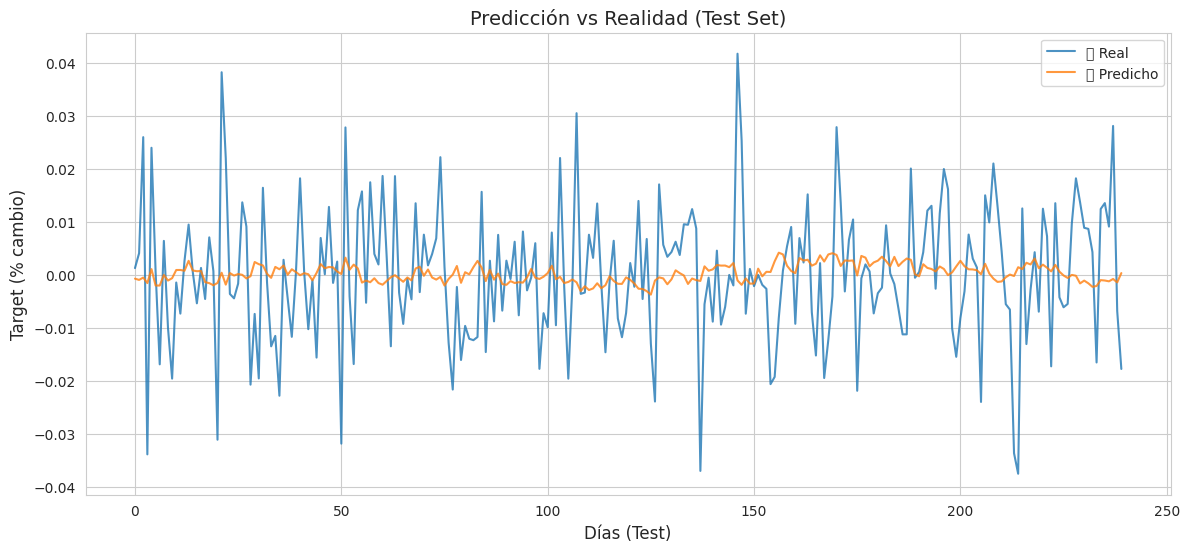

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.plot(y_test.values, label="📈 Real", alpha=0.8)
plt.plot(y_pred, label="🤖 Predicho", alpha=0.8)

plt.title("Predicción vs Realidad (Test Set)", fontsize=14)
plt.xlabel("Días (Test)", fontsize=12)
plt.ylabel("Target (% cambio)", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


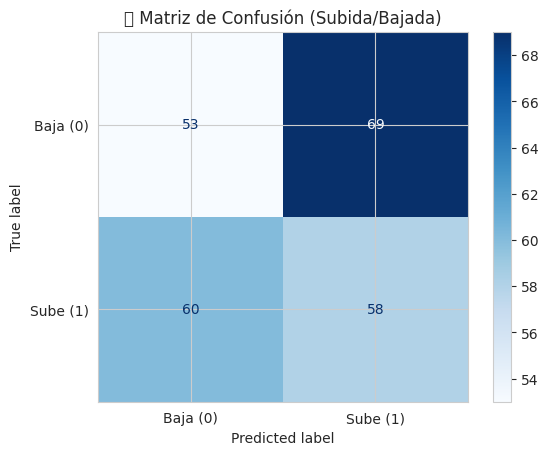

Matriz de confusión:
[[53 69]
 [60 58]]


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# ==========================
# 1️⃣ Convertimos a clasificación binaria (sube = 1, baja = 0)
# ==========================
y_test_class = (y_test > 0).astype(int)
y_pred_class = (y_pred > 0).astype(int)

# ==========================
# 2️⃣ Matriz de confusión
# ==========================
cm = confusion_matrix(y_test_class, y_pred_class)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Baja (0)", "Sube (1)"])
disp.plot(cmap="Blues")
plt.title("📊 Matriz de Confusión (Subida/Bajada)")
plt.show()

# También imprimimos para verlo en texto
print("Matriz de confusión:")
print(cm)


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

umbral = 0.02  # 2%

mask_pred = np.abs(y_pred) >= umbral
y_test_pred_th = y_test[mask_pred]
y_pred_pred_th = y_pred[mask_pred]

print(f"📊 Señales emitidas (modelo predice ≥{umbral*100:.0f}%): {len(y_pred_pred_th)} de {len(y_test)} días")

if len(y_pred_pred_th) > 0:
    y_test_pred_th_class = (y_test_pred_th > 0).astype(int)
    y_pred_pred_th_class = (y_pred_pred_th > 0).astype(int)

    # ⚡ Forzamos que siempre haya ambas clases
    cm_pred_th = confusion_matrix(y_test_pred_th_class, y_pred_pred_th_class, labels=[0, 1])

    acc_pred_th = accuracy_score(y_test_pred_th_class, y_pred_pred_th_class)

    print(f"📈 Precisión SOLO en señales del modelo (≥{umbral*100:.0f}%): {acc_pred_th:.2%}")
    print("Matriz de confusión (señales modelo):")
    print(cm_pred_th)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm_pred_th, display_labels=["Baja (0)", "Sube (1)"])
    disp.plot(cmap="Blues")
    plt.title(f"📊 Matriz de Confusión (Señales ≥{umbral*100:.0f}% Predichas)")
    plt.show()
else:
    print("⚠️ El modelo no emitió ninguna señal con ese umbral.")


📊 Señales emitidas (modelo predice ≥2%): 0 de 240 días
⚠️ El modelo no emitió ninguna señal con ese umbral.


### LSTM

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Input

# ==========================
# 1️⃣ Copia y limpieza del dataset
# ==========================
df_lstm = df_reg_combined.copy().reset_index(drop=True)

# Asegurar tipos y limpiar
df_lstm["Date"] = pd.to_datetime(df_lstm["Date"])
df_lstm = df_lstm.replace([np.inf, -np.inf], np.nan).fillna(0)

dates_raw = df_lstm["Date"].values           # Fechas completas
X_raw = df_lstm.drop(columns=["Target", "Date"])
y_raw = df_lstm["Target"].values

# ==========================
# 2️⃣ Escalado (ajustado SOLO con train < 2023) y crear secuencias
# ==========================
# 2.1 Máscara de train para el escalado (antes de hacer secuencias)
mask_train_full = df_lstm["Date"].values < np.datetime64("2023-01-01")

scaler = StandardScaler()
scaler.fit(X_raw.loc[mask_train_full])     # <- fit SOLO con datos < 2023
X_scaled_all = scaler.transform(X_raw)     # transform en todo (train+test)

# 2.2 Crear secuencias (ventana)
def create_sequences(X, y, dates, window_size=60):
    Xs, ys, ds = [], [], []
    for i in range(len(X) - window_size):
        Xs.append(X[i:i+window_size])
        ys.append(y[i+window_size])
        ds.append(dates[i+window_size])  # fecha del objetivo (t)
    return np.array(Xs), np.array(ys), np.array(ds)

WINDOW = 60
X_seq, y_seq, dates_seq = create_sequences(X_scaled_all, y_raw, dates_raw, WINDOW)
print(f"📊 Secuencias creadas: {X_seq.shape}, Targets: {y_seq.shape}")

# ==========================
# 3️⃣ Train/Test split temporal (hasta 2023 / solo 2023)
# ==========================
# Split por la fecha del objetivo (dates_seq)
dates_seq_dt = pd.to_datetime(dates_seq)
mask_train_seq = dates_seq_dt <  np.datetime64("2023-01-01")
mask_test_seq  = dates_seq_dt >= np.datetime64("2023-01-01")

X_train, X_test = X_seq[mask_train_seq], X_seq[mask_test_seq]
y_train, y_test = y_seq[mask_train_seq], y_seq[mask_test_seq]
dates_test = dates_seq[mask_test_seq]   # lo usas al guardar predicciones

print(f"📊 Train: {X_train.shape}, Test: {X_test.shape}")

# ==========================
# 4️⃣ Modelo LSTM (regresión)
# ==========================
model_lstm = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(50, return_sequences=True),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1, activation="linear")  # salida continua (retorno)
])

model_lstm.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="mse"
)

# ==========================
# 5️⃣ Entrenamiento
# ==========================
history_lstm = model_lstm.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    verbose=1
)

# ==========================
# 6️⃣ Predicciones y evaluación
# ==========================
y_prob_lstm = model_lstm.predict(X_test).flatten()   # predicción continua (retorno)
y_pred_bin_lstm = (y_prob_lstm > 0).astype(int)      # binaria (sube/no sube)

# MSE (regresión)
mse_lstm = mean_squared_error(y_test, y_prob_lstm)

# Precisión subida/bajada
acc_lstm = accuracy_score((y_test > 0).astype(int), y_pred_bin_lstm)

print(f"📉 MSE LSTM (Test): {mse_lstm:.6f}")
print(f"📈 Precisión subida/bajada LSTM: {acc_lstm:.2%}")

# ==========================
# 7️⃣ Guardar predicciones para ensemble
# ==========================
df_pred_reg_porcentual_lstm = pd.DataFrame({
    "Date": dates_test,
    "y_real": y_test,
    "pred_prob_reg_porcentual_lstm": y_prob_lstm,    # continuo
    "pred_bin_reg_porcentual_lstm": y_pred_bin_lstm  # binario
})

print(f"📂 Predicciones guardadas para ensemble: {df_pred_reg_porcentual_lstm.shape[0]} filas")
df_pred_reg_porcentual_lstm.head()




📊 Secuencias creadas: (2946, 60, 30), Targets: (2946,)
📊 Train: (2706, 60, 30), Test: (240, 60, 30)
Epoch 1/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0164 - val_loss: 6.5496e-04
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0029 - val_loss: 3.4939e-04
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0019 - val_loss: 2.7340e-04
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0013 - val_loss: 2.3528e-04
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 9.7935e-04 - val_loss: 2.5507e-04
Epoch 6/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 8.3960e-04 - val_loss: 2.0692e-04
Epoch 7/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 7.2893e-04 - val_loss: 2.0913e-04
Epoch 8/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 6.2903e-04 - val_loss: 1.9818e-04
Epoch 9/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 5.4969e-04 - val_loss: 1.9249e-04
Epoch 10/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 5.3025e-04 - val_loss: 1.8

,Date,y_real,pred_prob_reg_porcentual_lstm,pred_bin_reg_porcentual_lstm
0,2023-01-03,0.0013,-0.0017,0
1,2023-01-04,0.0041,-0.0001,0
2,2023-01-05,0.0260,0.0013,1
3,2023-01-06,-0.0338,0.0024,1
4,2023-01-09,0.0240,0.0027,1


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


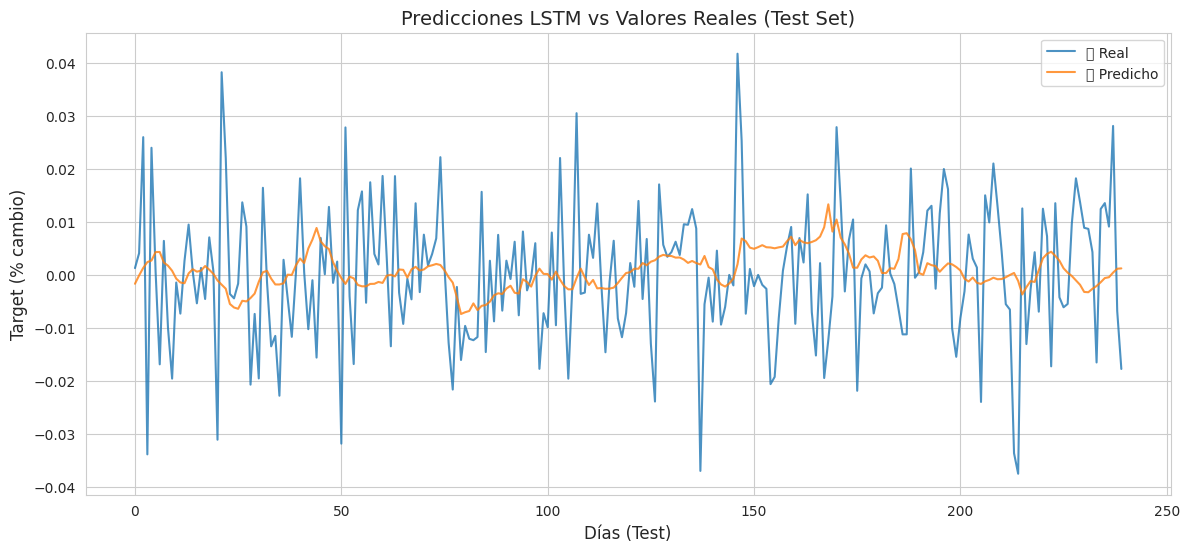

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.plot(y_test, label="📈 Real", alpha=0.8)
plt.plot(y_prob_lstm, label="🤖 Predicho", alpha=0.8)

plt.title("Predicciones LSTM vs Valores Reales (Test Set)", fontsize=14)
plt.xlabel("Días (Test)", fontsize=12)
plt.ylabel("Target (% cambio)", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# ==========================
# 1️⃣ Definir umbral (p.ej. 2% -> 0.02 si tu Target es retorno)
# ==========================
umbral = 0.025

# ==========================
# 2️⃣ Usar las variables consistentes del LSTM
#    y_prob_lstm -> predicción continua del modelo en el test
#    y_test      -> valores reales del test
# ==========================
y_pred_cont = y_prob_lstm                  # <- importante: misma longitud que y_test
y_true_cont = y_test

# Sanity check opcional
assert len(y_pred_cont) == len(y_true_cont), (len(y_pred_cont), len(y_true_cont))

# Filtrar solo los días con señal "fuerte" según el modelo
mask_pred = np.abs(y_pred_cont) >= umbral
y_true_th = y_true_cont[mask_pred]
y_pred_th = y_pred_cont[mask_pred]

print(f"📊 Señales emitidas (modelo predice ≥{umbral*100:.0f}%): {len(y_pred_th)} de {len(y_true_cont)} días")

# ==========================
# 3️⃣ Matriz de confusión y precisión en días señalados
# ==========================
if len(y_pred_th) > 0:
    y_true_class = (y_true_th > 0).astype(int)   # 1 = sube, 0 = baja
    y_pred_class = (y_pred_th > 0).astype(int)

    # Forzar ambas clases en el display
    cm = confusion_matrix(y_true_class, y_pred_class, labels=[0, 1])
    acc = accuracy_score(y_true_class, y_pred_class)

    print(f"📈 Precisión SOLO en señales del modelo (≥{umbral*100:.0f}%): {acc:.2%}")
    print("Matriz de confusión (señales modelo):")
    print(cm)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Baja (0)", "Sube (1)"])
    disp.plot(cmap="Blues")
    plt.title(f"📊 Matriz de Confusión (LSTM - Señales ≥{umbral*100:.0f}% Predichas)")
    plt.show()
else:
    print("⚠️ El modelo no emitió ninguna señal con ese umbral.")




📊 Señales emitidas (modelo predice ≥2%): 0 de 240 días
⚠️ El modelo no emitió ninguna señal con ese umbral.


### GRU

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dropout, Dense, Input

# ==========================
# 1️⃣ Copia y limpieza del dataset
# ==========================
df_gru = df_reg_combined.copy().reset_index(drop=True)

# Asegurar tipos y limpiar
df_gru["Date"] = pd.to_datetime(df_gru["Date"])
df_gru = df_gru.replace([np.inf, -np.inf], np.nan).fillna(0)

dates = df_gru["Date"].values          # guardamos las fechas completas
X = df_gru.drop(columns=["Target", "Date"])
y = df_gru["Target"].values

# ==========================
# 2️⃣ Escalar (fit SOLO con train < 2023) y crear secuencias
# ==========================
mask_train_full = df_gru["Date"].values < np.datetime64("2023-01-01")

scaler = StandardScaler()
scaler.fit(X.loc[mask_train_full])     # <-- evitar leakage
X_scaled_all = scaler.transform(X)

def create_sequences(X_arr, y_arr, dates_arr, window_size=60):
    Xs, ys, ds = [], [], []
    for i in range(len(X_arr) - window_size):
        Xs.append(X_arr[i:i+window_size])
        ys.append(y_arr[i+window_size])
        ds.append(dates_arr[i+window_size])  # fecha del objetivo (t)
    return np.array(Xs), np.array(ys), np.array(ds)

window_size = 60
X_seq, y_seq, dates_seq = create_sequences(X_scaled_all, y, dates, window_size)

print(f"📊 Secuencias creadas: {X_seq.shape}, Targets: {y_seq.shape}")

# ==========================
# 3️⃣ Train/Test split temporal (hasta 2023 / solo 2023)
# ==========================
dates_seq_dt = pd.to_datetime(dates_seq)
mask_train_seq = dates_seq_dt <  np.datetime64("2023-01-01")
mask_test_seq  = dates_seq_dt >= np.datetime64("2023-01-01")

X_train, X_test = X_seq[mask_train_seq], X_seq[mask_test_seq]
y_train, y_test = y_seq[mask_train_seq], y_seq[mask_test_seq]
dates_test = dates_seq[mask_test_seq]

print(f"📊 Train: {X_train.shape}, Test: {X_test.shape}")

# ==========================
# 4️⃣ Modelo GRU (regresión)
# ==========================
model_gru = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    GRU(50, return_sequences=True),
    Dropout(0.2),
    GRU(50),
    Dropout(0.2),
    Dense(1, activation='linear')  # salida continua
])

model_gru.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mse'
)

# ==========================
# 5️⃣ Entrenamiento
# ==========================
history_gru = model_gru.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    verbose=1
)

# ==========================
# 6️⃣ Predicciones y evaluación
# ==========================
y_prob_gru = model_gru.predict(X_test).flatten()      # continuo (retorno)
y_pred_bin_gru = (y_prob_gru > 0).astype(int)         # binarización para métricas

# MSE (regresión)
mse_gru = mean_squared_error(y_test, y_prob_gru)

# Precisión subida/bajada
y_test_class = (y_test > 0).astype(int)
acc_gru = accuracy_score(y_test_class, y_pred_bin_gru)

print(f"📉 MSE GRU (Test): {mse_gru:.6f}")
print(f"📈 Precisión subida/bajada GRU: {acc_gru:.2%}")

# ==========================
# 7️⃣ Guardar predicciones para ensemble
# ==========================
df_pred_reg_porcentual_gru = pd.DataFrame({
    'Date': dates_test,
    'y_real': y_test,
    'pred_prob_reg_porcentual_gru': y_prob_gru,   # continuo
    'pred_bin_reg_porcentual_gru': y_pred_bin_gru # binario
})

print(f"📂 Predicciones guardadas para ensemble: {df_pred_reg_porcentual_gru.shape[0]} filas")
df_pred_reg_porcentual_gru.head()


📊 Secuencias creadas: (2946, 60, 30), Targets: (2946,)
📊 Train: (2706, 60, 30), Test: (240, 60, 30)
Epoch 1/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0475 - val_loss: 0.0016
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0104 - val_loss: 3.8007e-04
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0059 - val_loss: 4.2935e-04
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0042 - val_loss: 2.6218e-04
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0027 - val_loss: 2.6021e-04
Epoch 6/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0022 - val_loss: 2.7293e-04
Epoch 7/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0018 - val_loss: 2.2313e-04
Epoch 8/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0015 - val_loss: 1.9944e-04
Epoch 9/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0014 - val_loss: 2.2685e-04
Epoch 10/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 9.7363e-04 - val_loss: 1.9938e-04
Epoch 11/50
85/

,Date,y_real,pred_prob_reg_porcentual_gru,pred_bin_reg_porcentual_gru
0,2023-01-03,0.0013,0.0043,1
1,2023-01-04,0.0041,0.0058,1
2,2023-01-05,0.0260,0.0051,1
3,2023-01-06,-0.0338,0.0044,1
4,2023-01-09,0.0240,0.0046,1


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


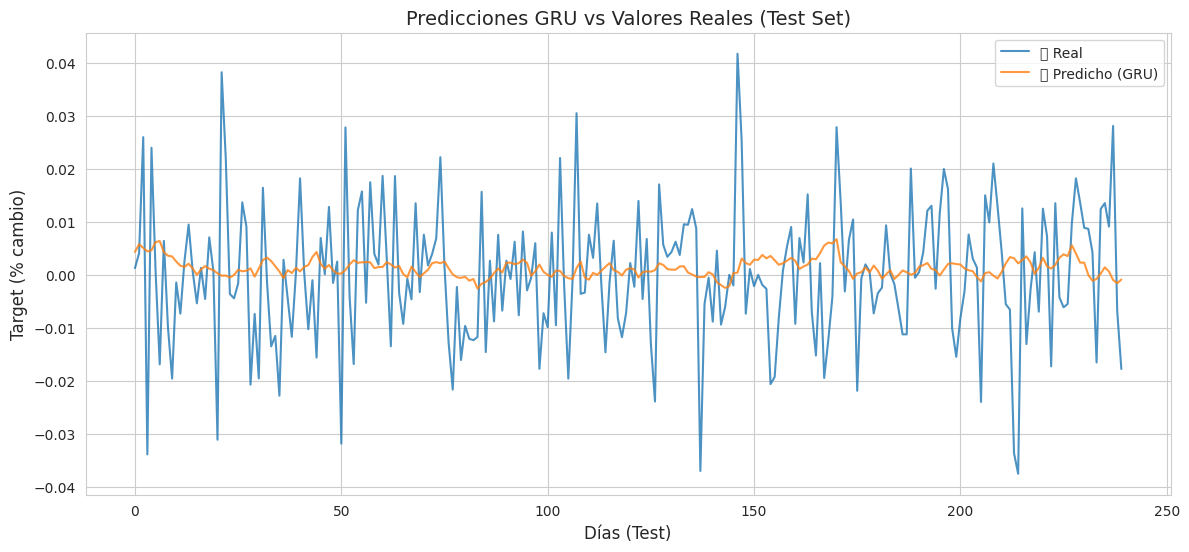

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.plot(y_test, label="📈 Real", alpha=0.8)
plt.plot(y_prob_gru, label="🤖 Predicho (GRU)", alpha=0.8)

plt.title("Predicciones GRU vs Valores Reales (Test Set)", fontsize=14)
plt.xlabel("Días (Test)", fontsize=12)
plt.ylabel("Target (% cambio)", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

umbral = 0.02  # 2%

# 1) Asegúrate de usar las predicciones del TEST
y_pred_cont = y_prob_gru   # <- predicciones continuas del GRU en el test
y_true_cont = y_test       # <- mismo y_test que usaste para evaluar el GRU

# 2) Chequeo defensivo
assert len(y_pred_cont) == len(y_true_cont), f"len(y_pred_cont)={len(y_pred_cont)} != len(y_true_cont)={len(y_true_cont)}"

# 3) Filtrado por umbral sobre las PREDICCIONES (no sobre y_true)
mask_pred = np.abs(y_pred_cont) >= umbral
y_true_th = y_true_cont[mask_pred]
y_pred_th = y_pred_cont[mask_pred]

print(f"📊 Señales emitidas (GRU predice ≥{umbral*100:.0f}%): {len(y_pred_th)} de {len(y_true_cont)} días")

if len(y_pred_th) > 0:
    y_true_class = (y_true_th > 0).astype(int)
    y_pred_class = (y_pred_th > 0).astype(int)

    cm = confusion_matrix(y_true_class, y_pred_class, labels=[0, 1])
    acc = accuracy_score(y_true_class, y_pred_class)

    print(f"📈 Precisión SOLO en señales del modelo GRU (≥{umbral*100:.0f}%): {acc:.2%}")
    print("Matriz de confusión (señales modelo GRU):")
    print(cm)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Baja (0)", "Sube (1)"])
    disp.plot(cmap="Blues")
    plt.title(f"📊 Matriz de Confusión (GRU - Señales ≥{umbral*100:.0f}% Predichas)")
    plt.show()
else:
    print("⚠️ El modelo GRU no emitió ninguna señal con ese umbral.")



📊 Señales emitidas (GRU predice ≥2%): 0 de 240 días
⚠️ El modelo GRU no emitió ninguna señal con ese umbral.


### RandomForest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, accuracy_score
import numpy as np
import pandas as pd

# ==========================
# 1️⃣ Preparar datos (train hasta 2022 / test = 2023)
# ==========================
df_rf = df_reg_combined.copy().reset_index(drop=True)
df_rf = df_rf.replace([np.inf, -np.inf], np.nan).fillna(0)

# Asegurar que Date sea datetime y ORDENAR por fecha
df_rf['Date'] = pd.to_datetime(df_rf['Date'])
df_rf = df_rf.sort_values('Date').reset_index(drop=True)

dates = df_rf['Date'].values
X = df_rf.drop(columns=['Target', 'Date'])
y = df_rf['Target'].values

# Máscaras de train/test
mask_train = df_rf['Date'] < "2023-01-01"
mask_test  = df_rf['Date'] >= "2023-01-01"

# OJO: y y dates son ndarrays -> usa .values en las máscaras para evitar errores
X_train, X_test = X.loc[mask_train], X.loc[mask_test]
y_train, y_test = y[mask_train.values], y[mask_test.values]
dates_test = dates[mask_test.values]

print(f"📊 Train: {X_train.shape}, Test: {X_test.shape}")

# ==========================
# 2️⃣ Definir el modelo base
# ==========================
rf = RandomForestRegressor(random_state=42, n_jobs=-1)

# ==========================
# 3️⃣ Espacio de búsqueda (alrededor de los mejores params)
# ==========================
param_dist = {
    'n_estimators': [200, 250, 300, 350, 400],
    'max_depth': [40, 45, 50, 55, 60],
    'min_samples_split': [2, 3, 5],
    'min_samples_leaf': [2, 3, 4, 6],
    'max_features': ['log2']
}

tscv = TimeSeriesSplit(n_splits=5)

# ==========================
# 4️⃣ RandomizedSearchCV
# ==========================
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=20,
    cv=tscv,
    verbose=2,
    n_jobs=-1,
    random_state=42,
    scoring='neg_mean_squared_error'
)

random_search.fit(X_train, y_train)

print("🔎 Mejores parámetros encontrados:")
print(random_search.best_params_)

# ==========================
# 5️⃣ Evaluación en test
# ==========================
best_rf = random_search.best_estimator_
y_prob = best_rf.predict(X_test)           # predicción continua (retorno)
y_pred = (y_prob > 0).astype(int)         # binarización para métricas de dirección

mse_rf = mean_squared_error(y_test, y_prob)
acc_rf = accuracy_score((y_test > 0).astype(int), y_pred)

print(f"📉 MSE RF (Test): {mse_rf:.6f}")
print(f"📈 Precisión subida/bajada RF: {acc_rf:.2%}")

# ==========================
# 6️⃣ Guardar predicciones para ensemble
# ==========================
df_pred_reg_porcentual_rf = pd.DataFrame({
    'Date': dates_test,
    'y_real': y_test,
    'pred_prob_reg_porcentual_rf': y_prob,
    'pred_bin_reg_porcentual_rf': y_pred
})

print(f"📂 Predicciones guardadas para ensemble: {df_pred_reg_porcentual_rf.shape[0]} filas")
df_pred_reg_porcentual_rf.head()


📊 Train: (2766, 30), Test: (240, 30)
Fitting 5 folds for each of 20 candidates, totalling 100 fits


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.plot(y_test, label="📈 Real", alpha=0.8)
plt.plot(y_prob, label="🌲 Predicho (Random Forest)", alpha=0.8)

plt.title("Predicciones Random Forest vs Valores Reales (Test Set)", fontsize=14)
plt.xlabel("Días (Test)", fontsize=12)
plt.ylabel("Target (% cambio)", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# ==========================
# 0️⃣ Asegurar que son arrays 1D y misma longitud
# ==========================
y_pred_cont = np.asarray(y_prob).ravel()
y_true_cont = np.asarray(y_test).ravel()

assert len(y_pred_cont) == len(y_true_cont), \
    f"Desajuste: len(y_pred)={len(y_pred_cont)} != len(y_test)={len(y_true_cont)}"

# ==========================
# 1️⃣ Definir umbral (en mismas unidades que Target)
# ==========================
umbral = 0.02  # 2%

# ==========================
# 2️⃣ Filtrar solo señales emitidas por el modelo (≥ umbral)
# ==========================
mask_pred = np.abs(y_pred_cont) >= umbral
y_true_th = y_true_cont[mask_pred]
y_pred_th = y_pred_cont[mask_pred]

print(f"📊 Señales emitidas (RF predice ≥{umbral*100:.0f}%): {len(y_pred_th)} de {len(y_true_cont)} días")

# ==========================
# 3️⃣ Matriz de confusión y precisión
# ==========================
if len(y_pred_th) > 0:
    y_true_class = (y_true_th > 0).astype(int)
    y_pred_class = (y_pred_th > 0).astype(int)

    cm = confusion_matrix(y_true_class, y_pred_class, labels=[0, 1])
    acc = accuracy_score(y_true_class, y_pred_class)

    print(f"📈 Precisión SOLO en señales del modelo RF (≥{umbral*100:.0f}%): {acc:.2%}")
    print("Matriz de confusión (señales modelo RF):")
    print(cm)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=["Baja (0)", "Sube (1)"])
    disp.plot(cmap="Blues")
    plt.title(f"📊 Matriz de Confusión RF (Señales ≥{umbral*100:.0f}% Predichas)")
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ El modelo RF no emitió ninguna señal con ese umbral.")


### XGBOOST

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, accuracy_score
from xgboost import XGBRegressor

# ==========================
# 1️⃣ Preparar datos (train hasta 2022 / test = 2023)
# ==========================
df_xgb = df_reg_combined.copy().reset_index(drop=True)
df_xgb = df_xgb.replace([np.inf, -np.inf], np.nan).fillna(0)

# Asegurar que Date sea datetime y ORDENAR por fecha
df_xgb['Date'] = pd.to_datetime(df_xgb['Date'])
df_xgb = df_xgb.sort_values('Date').reset_index(drop=True)

dates = df_xgb['Date'].values
X = df_xgb.drop(columns=['Target', 'Date'])
y = df_xgb['Target'].values

# Máscaras de train/test por fecha
mask_train = df_xgb['Date'] < "2023-01-01"
mask_test  = df_xgb['Date'] >= "2023-01-01"

X_train, X_test = X.loc[mask_train], X.loc[mask_test]
y_train, y_test = y[mask_train.values], y[mask_test.values]
dates_test = dates[mask_test.values]

print(f"📊 Train: {X_train.shape}, Test: {X_test.shape}")

# ==========================
# 2️⃣ Definir modelo base
# ==========================
xgb = XGBRegressor(
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1
)

# ==========================
# 3️⃣ Espacio de búsqueda hiperparámetros
# ==========================
param_dist = {
    "n_estimators": [100, 200, 300, 500],
    "max_depth": [3, 5, 7, 10],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "min_child_weight": [1, 3, 5, 7]
}

tscv = TimeSeriesSplit(n_splits=5)

# ==========================
# 4️⃣ RandomizedSearchCV
# ==========================
random_search_xgb = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=30,                 # puedes subir a 50–100 si quieres
    cv=tscv,
    verbose=2,
    random_state=42,
    n_jobs=-1,
    scoring="neg_mean_squared_error"
)

random_search_xgb.fit(X_train, y_train)

print("🔎 Mejores parámetros encontrados:")
print(random_search_xgb.best_params_)

# ==========================
# 5️⃣ Evaluación en test
# ==========================
best_xgb = random_search_xgb.best_estimator_
y_prob = best_xgb.predict(X_test)           # predicción continua
y_pred = (y_prob > 0).astype(int)           # binarización para métricas de dirección

mse_xgb = mean_squared_error(y_test, y_prob)
acc_xgb = accuracy_score((y_test > 0).astype(int), y_pred)

print(f"📉 MSE XGB (Test): {mse_xgb:.6f}")
print(f"📈 Precisión subida/bajada XGB: {acc_xgb:.2%}")

# ==========================
# 6️⃣ Guardar predicciones para ensemble
# ==========================
df_pred_reg_porcentual_xgb = pd.DataFrame({
    "Date": dates_test,
    "y_real": y_test,
    "pred_prob_reg_porcentual_xgb": y_prob,
    "pred_bin_reg_porcentual_xgb": y_pred
})

print(f"📂 Predicciones guardadas para ensemble: {df_pred_reg_porcentual_xgb.shape[0]} filas")
df_pred_reg_porcentual_xgb.head()


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.plot(y_test, label="📈 Real", alpha=0.8)
plt.plot(y_prob, label="🔥 Predicho (XGBoost)", alpha=0.8)

plt.title("Predicciones XGBoost vs Valores Reales (Test Set)", fontsize=14)
plt.xlabel("Días (Test)", fontsize=12)
plt.ylabel("Target (% cambio)", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# ==========================
# 0️⃣ Asegurar arrays 1D y misma longitud
# ==========================
y_pred_cont = np.asarray(y_prob).ravel()
y_true_cont = np.asarray(y_test).ravel()
assert len(y_pred_cont) == len(y_true_cont), \
    f"Desajuste: len(y_pred)={len(y_pred_cont)} != len(y_test)={len(y_true_cont)}"

# ==========================
# 1️⃣ Definir umbral (mismas unidades que Target)
# ==========================
umbral = 0.02  # 2%

# ==========================
# 2️⃣ Filtrar solo señales emitidas por el modelo (≥ umbral)
# ==========================
mask_pred = np.abs(y_pred_cont) >= umbral
y_true_th = y_true_cont[mask_pred]
y_pred_th = y_pred_cont[mask_pred]

print(f"📊 Señales emitidas (XGB predice ≥{umbral*100:.0f}%): {len(y_pred_th)} de {len(y_true_cont)} días")

# ==========================
# 3️⃣ Matriz de confusión y precisión
# ==========================
if len(y_pred_th) > 0:
    y_true_class = (y_true_th > 0).astype(int)
    y_pred_class = (y_pred_th > 0).astype(int)

    cm = confusion_matrix(y_true_class, y_pred_class, labels=[0, 1])
    acc = accuracy_score(y_true_class, y_pred_class)

    print(f"📈 Precisión SOLO en señales del modelo XGB (≥{umbral*100:.0f}%): {acc:.2%}")
    print("Matriz de confusión (señales modelo XGB):")
    print(cm)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Baja (0)", "Sube (1)"])
    disp.plot(cmap="Blues")
    plt.title(f"📊 Matriz de Confusión XGB (Señales ≥{umbral*100:.0f}% Predichas)")
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ El modelo XGB no emitió ninguna señal con ese umbral.")



### ADABOOST

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, accuracy_score

# ==========================
# 1️⃣ Preparar datos (train hasta 2022 / test = 2023)
# ==========================
df_ada = df_reg_combined.copy().reset_index(drop=True)
df_ada = df_ada.replace([np.inf, -np.inf], np.nan).fillna(0)

# Asegurar que Date sea datetime y ORDENAR por fecha
df_ada['Date'] = pd.to_datetime(df_ada['Date'])
df_ada = df_ada.sort_values('Date').reset_index(drop=True)

dates = df_ada['Date'].values
X = df_ada.drop(columns=['Target', 'Date'])
y = df_ada['Target'].values

# Máscaras de train/test por fecha
mask_train = df_ada['Date'] < "2023-01-01"
mask_test  = df_ada['Date'] >= "2023-01-01"

X_train, X_test = X.loc[mask_train], X.loc[mask_test]
y_train, y_test = y[mask_train.values], y[mask_test.values]
dates_test = dates[mask_test.values]

print(f"📊 Train: {X_train.shape}, Test: {X_test.shape}")

# ==========================
# 2️⃣ Modelo base
# ==========================
ada = AdaBoostRegressor(
    estimator=DecisionTreeRegressor(random_state=42),
    random_state=42
)

# ==========================
# 3️⃣ Espacio de hiperparámetros
# ==========================
param_dist = {
    "n_estimators": [50, 100, 200, 300],
    "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.5, 1.0],
    "estimator__max_depth": [2, 3, 5, 7, 10],
    "estimator__min_samples_split": [2, 5, 10],
    "estimator__min_samples_leaf": [1, 2, 4]
}

tscv = TimeSeriesSplit(n_splits=5)

# ==========================
# 4️⃣ RandomizedSearchCV
# ==========================
random_search_ada = RandomizedSearchCV(
    estimator=ada,
    param_distributions=param_dist,
    n_iter=30,                 # puedes subir a 50–100 si quieres
    cv=tscv,
    verbose=2,
    random_state=42,
    n_jobs=-1,
    scoring="neg_mean_squared_error"
)

random_search_ada.fit(X_train, y_train)

print("🔎 Mejores parámetros encontrados:")
print(random_search_ada.best_params_)

# ==========================
# 5️⃣ Evaluación en test
# ==========================
best_ada = random_search_ada.best_estimator_
y_prob = best_ada.predict(X_test)            # continuo (retorno)
y_pred = (y_prob > 0).astype(int)            # binarización para métricas

mse_ada = mean_squared_error(y_test, y_prob)
acc_ada = accuracy_score((y_test > 0).astype(int), y_pred)

print(f"📉 MSE AdaBoost (Test): {mse_ada:.6f}")
print(f"📈 Precisión subida/bajada AdaBoost: {acc_ada:.2%}")

# ==========================
# 6️⃣ Guardar predicciones para ensemble
# ==========================
df_pred_reg_porcentual_ada = pd.DataFrame({
    "Date": dates_test,
    "y_real": y_test,
    "pred_prob_reg_porcentual_ada": y_prob,
    "pred_bin_reg_porcentual_ada": y_pred
})

print(f"📂 Predicciones guardadas para ensemble: {df_pred_reg_porcentual_ada.shape[0]} filas")
df_pred_reg_porcentual_ada.head()


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.plot(y_test, label="📈 Real", alpha=0.8)
plt.plot(y_prob, label="⚡ Predicho (AdaBoost)", alpha=0.8)

plt.title("Predicciones AdaBoost vs Valores Reales (Test Set)", fontsize=14)
plt.xlabel("Días (Test)", fontsize=12)
plt.ylabel("Target (% cambio)", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# ==========================
# 0️⃣ Asegurar arrays 1D y misma longitud
# ==========================
y_pred_cont = np.asarray(y_prob).ravel()
y_true_cont = np.asarray(y_test).ravel()
assert len(y_pred_cont) == len(y_true_cont), \
    f"Desajuste: len(y_pred)={len(y_pred_cont)} != len(y_test)={len(y_true_cont)}"

# ==========================
# 1️⃣ Definir umbral (mismas unidades que Target)
# ==========================
umbral = 0.02  # 2%

# ==========================
# 2️⃣ Filtrar solo señales emitidas por el modelo (≥ umbral)
# ==========================
mask_pred = np.abs(y_pred_cont) >= umbral
y_true_th = y_true_cont[mask_pred]
y_pred_th = y_pred_cont[mask_pred]

print(f"📊 Señales emitidas (AdaBoost predice ≥{umbral*100:.0f}%): {len(y_pred_th)} de {len(y_true_cont)} días")

# ==========================
# 3️⃣ Matriz de confusión y precisión
# ==========================
if len(y_pred_th) > 0:
    y_true_class = (y_true_th > 0).astype(int)
    y_pred_class = (y_pred_th > 0).astype(int)

    cm = confusion_matrix(y_true_class, y_pred_class, labels=[0, 1])
    acc = accuracy_score(y_true_class, y_pred_class)

    print(f"📈 Precisión SOLO en señales del modelo AdaBoost (≥{umbral*100:.0f}%): {acc:.2%}")
    print("Matriz de confusión (señales modelo AdaBoost):")
    print(cm)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Baja (0)", "Sube (1)"])
    disp.plot(cmap="Blues")
    plt.title(f"📊 Matriz de Confusión AdaBoost (Señales ≥{umbral*100:.0f}% Predichas)")
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ El modelo AdaBoost no emitió ninguna señal con ese umbral.")


### LSTM + GRU

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dropout, Dense, Input

# ==========================
# 1️⃣ Preparar datos
# ==========================
df_hybrid = df_reg_combined.copy().reset_index(drop=True)
df_hybrid = df_hybrid.replace([np.inf, -np.inf], np.nan).fillna(0)

# Fechas a datetime y ordenar
df_hybrid["Date"] = pd.to_datetime(df_hybrid["Date"])
df_hybrid = df_hybrid.sort_values("Date").reset_index(drop=True)

dates = df_hybrid["Date"].values
X = df_hybrid.drop(columns=["Target", "Date"])
y = df_hybrid["Target"].values

# ==========================
# 2️⃣ Escalar (fit SOLO con train < 2023) + crear secuencias (ventana 60)
# ==========================
mask_train_full = df_hybrid["Date"].values < np.datetime64("2023-01-01")

scaler = StandardScaler()
scaler.fit(X.loc[mask_train_full])      # ← sin fuga de info
X_scaled = scaler.transform(X)

def create_sequences(X_arr, y_arr, dates_arr, window_size=60):
    Xs, ys, ds = [], [], []
    for i in range(len(X_arr) - window_size):
        Xs.append(X_arr[i:i+window_size])
        ys.append(y_arr[i+window_size])
        ds.append(dates_arr[i+window_size])   # fecha del objetivo
    return np.array(Xs), np.array(ys), np.array(ds)

window_size = 60
X_seq, y_seq, dates_seq = create_sequences(X_scaled, y, dates, window_size)

# ==========================
# 3️⃣ Train/Test split temporal (hasta 2022 / test = 2023)
# ==========================
dates_seq = pd.to_datetime(dates_seq)
mask_train = dates_seq <  np.datetime64("2023-01-01")
mask_test  = dates_seq >= np.datetime64("2023-01-01")

X_train, X_test = X_seq[mask_train], X_seq[mask_test]
y_train, y_test = y_seq[mask_train], y_seq[mask_test]
dates_test = dates_seq[mask_test]

print(f"📊 Train: {X_train.shape}, Test: {X_test.shape}")

# ==========================
# 4️⃣ Modelo híbrido LSTM + GRU (regresión)
# ==========================
model_hybrid = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    GRU(64, return_sequences=True),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(1, activation="linear")
])

model_hybrid.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="mse"
)

# ==========================
# 5️⃣ Entrenamiento
# ==========================
history_hybrid = model_hybrid.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,            # sube a 50–100 si lo ves bien
    batch_size=32,
    verbose=1
)

# ==========================
# 6️⃣ Predicciones y evaluación
# ==========================
y_prob = model_hybrid.predict(X_test).flatten()    # continuo (retorno)
y_pred = (y_prob > 0).astype(int)                  # binario para métricas

mse_hybrid = mean_squared_error(y_test, y_prob)
acc_hybrid = accuracy_score((y_test > 0).astype(int), y_pred)

print(f"📉 MSE Hybrid (Test): {mse_hybrid:.6f}")
print(f"📈 Precisión subida/bajada Hybrid: {acc_hybrid:.2%}")

# ==========================
# 7️⃣ Guardar predicciones para ensemble
# ==========================
df_pred_reg_porcentual_hybrid = pd.DataFrame({
    "Date": dates_test,
    "y_real": y_test,
    "pred_prob_reg_porcentual_hybrid": y_prob,
    "pred_bin_reg_porcentual_hybrid": y_pred
})

print(f"📂 Predicciones guardadas para ensemble: {df_pred_reg_porcentual_hybrid.shape[0]} filas")
df_pred_reg_porcentual_hybrid.head()



In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.plot(y_test, label="📈 Real", alpha=0.8)
plt.plot(y_prob, label="🔀 Predicho (Hybrid LSTM+GRU)", alpha=0.8)

plt.title("Predicciones Hybrid LSTM+GRU vs Valores Reales (Test Set)", fontsize=14)
plt.xlabel("Días (Test)", fontsize=12)
plt.ylabel("Target (% cambio)", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# ==========================
# 0️⃣ Asegurar arrays 1D y misma longitud
# ==========================
y_pred_cont = np.asarray(y_prob).ravel()
y_true_cont = np.asarray(y_test).ravel()
assert len(y_pred_cont) == len(y_true_cont), \
    f"Desajuste: len(y_pred)={len(y_pred_cont)} != len(y_test)={len(y_true_cont)}"

# ==========================
# 1️⃣ Definir umbral (mismas unidades que Target)
# ==========================
umbral = 0.02  # 2%

# ==========================
# 2️⃣ Filtrar solo señales emitidas por el modelo (≥ umbral)
# ==========================
mask_pred = np.abs(y_pred_cont) >= umbral
y_true_th = y_true_cont[mask_pred]
y_pred_th = y_pred_cont[mask_pred]

print(f"📊 Señales emitidas (Hybrid predice ≥{umbral*100:.0f}%): {len(y_pred_th)} de {len(y_true_cont)} días")

# ==========================
# 3️⃣ Matriz de confusión y precisión
# ==========================
if len(y_pred_th) > 0:
    y_true_class = (y_true_th > 0).astype(int)
    y_pred_class = (y_pred_th > 0).astype(int)

    cm = confusion_matrix(y_true_class, y_pred_class, labels=[0, 1])
    acc = accuracy_score(y_true_class, y_pred_class)

    print(f"📈 Precisión SOLO en señales del modelo Hybrid (≥{umbral*100:.0f}%): {acc:.2%}")
    print("Matriz de confusión (señales modelo Hybrid):")
    print(cm)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Baja (0)", "Sube (1)"])
    disp.plot(cmap="Blues")
    plt.title(f"📊 Matriz de Confusión Hybrid LSTM+GRU (Señales ≥{umbral*100:.0f}% Predichas)")
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ El modelo Hybrid no emitió ninguna señal con ese umbral.")


### Modelo ENSEMBLE

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix
)

# ==============================
# 0) ENTRADA: tus dataframes
# ==============================
model_dfs = {
    "LSTM":        df_pred_reg_porcentual_lstm,
    "GRU":         df_pred_reg_porcentual_gru,
    "RF":          df_pred_reg_porcentual_rf,
    "XGBoost":     df_pred_reg_porcentual_xgb,
    "AdaBoost":    df_pred_reg_porcentual_ada,
    "LSTM+GRU":    df_pred_reg_porcentual_hybrid}

# ==============================
# 1) Helpers robustos de columnas
# ==============================
def find_col(cols, *substrs):
    """Devuelve la primera columna que contenga TODAS las substrings dadas (case-insensitive)."""
    cl = [c for c in cols]
    for c in cl:
        name = c.lower()
        if all(s in name for s in substrs):
            return c
    return None

def get_binary_signal(df):
    """
    Intenta obtener una señal binaria 0/1 de compra:
    1) pred_bin*
    2) pred_prob* (>=0.5 -> 1)
    3) pred_reg*/porcent*/pct* (signo >0 -> 1)
    """
    cols = df.columns
    # 1) binaria directa
    col_bin = None
    for s in ["pred_bin", "signal_bin", "bin"]:
        col_bin = find_col(cols, s)
        if col_bin is not None:
            sig = df[col_bin].astype(int).clip(0,1).values
            return sig

    # 2) desde prob
    col_prob = None
    for s in ["pred_prob", "prob"]:
        col_prob = find_col(cols, s)
        if col_prob is not None:
            sig = (df[col_prob].astype(float).values >= 0.5).astype(int)
            return sig

    # 3) desde retorno porcentual
    col_ret = None
    # intenta varias combinaciones habituales
    for patt in [
        ("pred","reg","porcent"), ("pred","reg","pct"), ("pred","porcent"),
        ("pred","pct"), ("ret","pred"), ("pred","return"), ("pred","reg")
    ]:
        col_ret = find_col(cols, *patt)
        if col_ret is not None:
            sig = (df[col_ret].astype(float).values > 0).astype(int)
            return sig

    raise ValueError("No encuentro columna para construir señal binaria (pred_bin/prob/retorno).")

def get_predicted_return(df):
    """
    Devuelve un retorno porcentual predicho (float), usado para el filtro ±2%.
    Busca columnas tipo pred_reg_porcentual / pred_pct / pred_return...
    """
    cols = df.columns
    for patt in [
        ("pred","reg","porcent"), ("pred","reg","pct"), ("pred","porcent"),
        ("pred","pct"), ("ret","pred"), ("pred","return"), ("pred","reg")
    ]:
        col = find_col(cols, *patt)
        if col is not None:
            return df[col].astype(float).values
    # Si no hay retorno, devolvemos NaN (ese modelo no aporta magnitud)
    return np.full(len(df), np.nan)

# ==============================
# 2) Construir matriz de votos y retornos por fecha
# ==============================
per_model = []
for name, df in model_dfs.items():
    df_ = df.copy()

    # Normaliza fecha
    if "Date" not in df_.columns:
        raise ValueError(f"{name}: falta columna 'Date'.")
    # Asegura y_true común
    if "y_real" not in df_.columns:
        raise ValueError(f"{name}: falta columna 'y_real'.")

    # Señal binaria por modelo
    sig = get_binary_signal(df_)
    # Retorno porcentual predicho por modelo (para el umbral)
    ret = get_predicted_return(df_)

    tmp = pd.DataFrame({
        "Date": df_["Date"].values,
        f"vote_{name}": sig,
        f"ret_{name}": ret
    })
    per_model.append(tmp)

# Une por intersección de fechas (inner join sucesivo)
from functools import reduce
def join_inner_on_date(a, b):
    return a.merge(b, on="Date", how="inner")

panel = reduce(join_inner_on_date, per_model).sort_values("Date").reset_index(drop=True)

# y_true común (de cualquiera de los DF originales; usamos el primero)
# Mejor: si tienes un df maestro con y_real por Date, úsalo. Aquí lo derivamos:
any_df = next(iter(model_dfs.values()))
y_master = any_df[["Date","y_real"]].copy()
y_master["y_true"] = (y_master["y_real"].astype(float) > 0).astype(int)
panel = panel.merge(y_master[["Date","y_true"]].drop_duplicates("Date"), on="Date", how="inner")

# ==============================
# 3) Votación mayoritaria estricta
# ==============================
vote_cols = [c for c in panel.columns if c.startswith("vote_")]
ret_cols  = [c for c in panel.columns if c.startswith("ret_")]

panel["n_models"] = panel[vote_cols].notna().sum(axis=1)
panel["n_buys"]   = panel[vote_cols].sum(axis=1)
# Estricto: compra si hay MÁS de la mitad votando compra; empate => 0 (no compra)
panel["y_pred_ensemble"] = (panel["n_buys"] > panel["n_models"]/2).astype(int)

# Para medir la magnitud del movimiento esperado a nivel ENSEMBLE,
# tomamos el promedio de los retornos disponibles (ignorando NaN).
panel["ret_ensemble"] = panel[ret_cols].astype(float).mean(axis=1, skipna=True)

# ==============================
# 4) Métricas globales
# ==============================
y_true = panel["y_true"].astype(int).values
y_pred = panel["y_pred_ensemble"].astype(int).values

print("\n=== Ensemble por VOTACIÓN (global) ===")
print(f"Fechas evaluadas: {len(panel)} | Modelos por fecha (media): {panel['n_models'].mean():.2f}")
print(f"Accuracy:  {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred, zero_division=0):.4f}")
print(f"Recall:    {recall_score(y_true, y_pred, zero_division=0):.4f}")
print(f"F1-Score:  {f1_score(y_true, y_pred, zero_division=0):.4f}")
print("Matriz de confusión:")
print(confusion_matrix(y_true, y_pred))

# ==============================
# 5) Métricas con UMBRAL estilo trading (±2%)
# ==============================
UMBRAL = 0.005  # 2%
# Filtramos SOLO las fechas en las que la magnitud del retorno ENSEMBLE
# (promedio de los modelos) supera el umbral (alejadas de la indecisión)
mask = panel["ret_ensemble"].abs() >= UMBRAL

y_true_th = panel.loc[mask, "y_true"].astype(int).values
y_pred_th = panel.loc[mask, "y_pred_ensemble"].astype(int).values

print(f"\n=== Ensemble con UMBRAL (|ret_ensemble| ≥ {UMBRAL*100:.0f}%) ===")
print(f"Fechas señaladas: {mask.sum()} de {len(panel)}")

if mask.sum() > 0:
    print(f"Accuracy:  {accuracy_score(y_true_th, y_pred_th):.4f}")
    print(f"Precision: {precision_score(y_true_th, y_pred_th, zero_division=0):.4f}")
    print(f"Recall:    {recall_score(y_true_th, y_pred_th, zero_division=0):.4f}")
    print(f"F1-Score:  {f1_score(y_true_th, y_pred_th, zero_division=0):.4f}")
    print("Matriz de confusión (umbral):")
    print(confusion_matrix(y_true_th, y_pred_th))
else:
    print("No hay fechas que superen el umbral. Revisa columnas de retornos o el valor del umbral.")



In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# =====================================================
# 1) MODELOS DISPONIBLES (pon solo los que existan)
#    clave = nombre exacto en df_summary["Modelo"]
#    valor = variable del DataFrame con las predicciones
#    Requisitos por DF: columna 'Date' y (y_prob | y_pred_bin | y_pred)
#    Opcional: y_real_bin (para métricas)
# =====================================================
model_dfs = {
    "Reg Sentiment RF":   df_pred_reg_sentiment_rf,
    "Reg Combined RF":    df_pred_reg_combined_rf,
    "Reg Combined GRU":   df_pred_reg_combined_gru,
    "Reg Sentiment LSTM": df_pred_reg_sentiment_lstm,
    "Sentiment RF":       df_pred_sentiment_rf,
    "Reg Combined LSTM":  df_pred_reg_combined_lstm,
    "Combined GRU":       df_pred_combined_gru,
    "Combined LSTM":      df_pred_combined_lstm,
    "Sentiment LSTM":     df_pred_sentiment_lstm,
    "Reg Sentiment GRU":  df_pred_reg_sentiment_gru,
    "Combined RF":        df_pred_combined_rf,
    "Sentiment GRU":      df_pred_sentiment_gru,
}

# =====================================================
# 2) Hiperparámetros del ensemble
# =====================================================
THRESH = 0.5   # umbral final de compra
ALPHA  = 5.0   # temperatura del softmax de pesos (↑ => favorece más a los top)

# =====================================================
# 3) Construir pesos desde df_summary (Accuracy %)
# =====================================================
# df_summary debe tener: ["Modelo","Accuracy (%)"]
present_names = [name for name in model_dfs.keys() if name in getattr(pd, 'Series')(model_dfs).index]  # por si editas arriba

# Filtrar df_summary a los modelos presentes y en el mismo orden
df_acc = df_summary[df_summary["Modelo"].isin(present_names)].set_index("Modelo").reindex(present_names)

if df_acc["Accuracy (%)"].isna().all():
    # fallback por si no hay accuracies (o nombres no cuadran): peso igual
    acc_values = np.ones(len(present_names), dtype=float)
else:
    acc_values = (df_acc["Accuracy (%)"].fillna(df_acc["Accuracy (%)"].mean()).values) / 100.0

# Softmax sobre accuracy (centrado por la media)
exp_scores = np.exp(ALPHA * (acc_values - np.mean(acc_values)))
weights = exp_scores / exp_scores.sum()
w_map = {name: w for name, w in zip(present_names, weights)}

print("Pesos del ensemble (softmax por accuracy):")
for n in present_names:
    print(f"  {n}: {w_map[n]:.4f}")

# =====================================================
# 4) Pasar cada modelo a formato largo: [Date, model, prob] (+ y_true si hay)
# =====================================================
long_parts = []
y_true_pool = []  # para recoger truth por fecha

def _ensure_date_index(df):
    if "Date" not in df.columns:
        # si viene con índice fecha
        if isinstance(df.index, pd.DatetimeIndex):
            df = df.reset_index().rename(columns={"index":"Date"})
        else:
            raise ValueError("El DF no tiene columna 'Date' ni índice DateTimeIndex.")
    return df

for name, df in model_dfs.items():
    if name not in present_names:
        continue
    df_ = _ensure_date_index(df.copy())
    # intenta sacar probas
    prob_col = None
    for c in ["y_prob", "y_pred_prob"]:
        if c in df_.columns:
            prob_col = c
            break
    if prob_col is None:
        # usar binaria como proba
        for c in ["y_pred_bin", "y_pred", "pred"]:
            if c in df_.columns:
                # si es 0/1 la tratamos como proba
                vals = df_[c].dropna().unique()
                if len(vals) == 0 or set(pd.Series(vals).astype(int)).issubset({0,1}):
                    prob_col = c
                    break
    if prob_col is None:
        print(f"⚠️  {name}: no encuentro columnas de probas ni binarias (y_prob / y_pred_bin / y_pred). Lo salto.")
        continue

    tmp = df_[["Date", prob_col]].rename(columns={prob_col: "prob"}).dropna()
    tmp["Modelo"] = name
    long_parts.append(tmp)

    # trata de recoger y_true si existe
    for yt in ["y_real_bin", "y_real", "Target"]:
        if yt in df_.columns:
            y_true_pool.append(df_[["Date", yt]].dropna().rename(columns={yt:"y_true"}))
            break

if not long_parts:
    raise ValueError("No hay ninguna predicción válida para el ensemble.")

long_df = pd.concat(long_parts, ignore_index=True)
# Acota probas a [0,1] por si algún modelo suelta algo raro
long_df["prob"] = long_df["prob"].clip(0,1)

# y_true por fecha (si hay)
if y_true_pool:
    y_true_df = pd.concat(y_true_pool, ignore_index=True).drop_duplicates(subset=["Date"])
else:
    y_true_df = pd.DataFrame(columns=["Date","y_true"])

# =====================================================
# 5) Score ponderado por fecha con solo modelos disponibles en esa fecha
# =====================================================
# Añade pesos por modelo
long_df["weight"] = long_df["Modelo"].map(w_map).astype(float)

# Agregación por fecha: sum(weight*prob)/sum(weight) usando SOLO los presentes en esa fecha
agg = long_df.groupby("Date").apply(
    lambda g: pd.Series({
        "sum_w": g["weight"].sum(),
        "score": (g["weight"] * g["prob"]).sum() / (g["weight"].sum() if g["weight"].sum() > 0 else np.nan),
        "n_models": g.shape[0],
        "models_used": ", ".join(g["Modelo"].tolist())
    })
).reset_index()

# Pred binaria
agg["y_pred_ensemble"] = (agg["score"] >= THRESH).astype(int)

# Merge con y_true (si existe)
df_pred_ensemble = agg.merge(y_true_df, on="Date", how="left")

# =====================================================
# 6) Métricas (solo en fechas con y_true)
# =====================================================
mask_eval = df_pred_ensemble["y_true"].notna()
if mask_eval.any():
    y_true = df_pred_ensemble.loc[mask_eval, "y_true"].astype(int).values
    y_pred = df_pred_ensemble.loc[mask_eval, "y_pred_ensemble"].astype(int).values

    print("\n=== Ensemble (fechas con ground truth) ===")
    print(f"Fechas evaluadas: {mask_eval.sum()} (de {len(df_pred_ensemble)})")
    print(f"Accuracy:  {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred, zero_division=0):.4f}")
    print(f"Recall:    {recall_score(y_true, y_pred, zero_division=0):.4f}")
    print(f"F1-Score:  {f1_score(y_true, y_pred, zero_division=0):.4f}")
    print("\nMatriz de confusión:")
    print(confusion_matrix(y_true, y_pred))
    print("\nReporte de clasificación:")
    print(classification_report(y_true, y_pred, target_names=["No Comprar","Comprar"], digits=4))
else:
    print("\n(No hay y_true para evaluar; te dejo solo las predicciones por fecha.)")

# =====================================================
# 6.bis) (AÑADIDO) Métricas por MODELO + Peso asignado
#        Se evalúa cada modelo individualmente en las fechas donde tiene predicción
#        y exista y_true. La predicción binaria del modelo es (prob >= THRESH).
# =====================================================
model_metrics = []
if not y_true_df.empty:
    # Prepara truth indexado por fecha para joins rápidos
    y_truth = y_true_df.drop_duplicates("Date").set_index("Date")["y_true"].astype(int)

    for name in present_names:
        g = long_df[long_df["Modelo"] == name].copy()
        if g.empty:
            continue
        g = g.set_index("Date").join(y_truth, how="inner")  # solo fechas con verdad
        if g.empty:
            continue

        y_t = g["y_true"].astype(int).values
        y_p = (g["prob"].values >= THRESH).astype(int)

        acc = accuracy_score(y_t, y_p)
        prec = precision_score(y_t, y_p, zero_division=0)
        rec  = recall_score(y_t, y_p, zero_division=0)
        f1   = f1_score(y_t, y_p, zero_division=0)
        cm   = confusion_matrix(y_t, y_p)

        model_metrics.append({
            "Modelo": name,
            "Fechas_evaluadas": int(len(y_t)),
            "Accuracy": acc,
            "Precision": prec,
            "Recall": rec,
            "F1-Score": f1,
            "TN": int(cm[0,0]), "FP": int(cm[0,1]),
            "FN": int(cm[1,0]), "TP": int(cm[1,1]),
            "Peso_Softmax_Acc": float(w_map.get(name, np.nan)),
        })

    if model_metrics:
        df_metrics_modelo = pd.DataFrame(model_metrics).sort_values(
            ["F1-Score", "Accuracy"], ascending=False
        ).reset_index(drop=True)

        print("\n=== Métricas por modelo (con peso asignado) ===")
        print(df_metrics_modelo[[
            "Modelo","Fechas_evaluadas","Accuracy","Precision","Recall","F1-Score","Peso_Softmax_Acc",
            "TN","FP","FN","TP"
        ]])
    else:
        print("\n(No se pudieron calcular métricas por modelo: no hubo intersección con y_true.)")
else:
    print("\n(No hay y_true disponible para calcular métricas por modelo.)")

# =====================================================
# 7) Resultado final
#    df_pred_ensemble: una fila por fecha con score y pred, nº modelos usados, etc.
# =====================================================
print(f"\n✅ Ensemble listo: {df_pred_ensemble.shape[0]} fechas, media de modelos usados = {df_pred_ensemble['n_models'].mean():.2f}")
df_pred_ensemble.head()


Ensemble con Accuracy

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# =====================================================
# 1) MODELOS DISPONIBLES (pon solo los que existan)
#    Requisitos por DF: 'Date' y alguna de:
#      - prob:  y_prob | y_pred_prob
#      - bin:   y_pred_bin | y_pred | pred (0/1)
#      - retorno (regresión): columnas tipo pred_reg_porcentual / pred_pct / pred_return ...
#    Opcional: y_real_bin | y_real | Target  (ground truth)
# =====================================================
model_dfs = {
    "Reg Sentiment RF":   df_pred_reg_sentiment_rf,
    "Reg Combined RF":    df_pred_reg_combined_rf,
    "Reg Combined GRU":   df_pred_reg_combined_gru,
    "Reg Sentiment LSTM": df_pred_reg_sentiment_lstm,
    "Sentiment RF":       df_pred_sentiment_rf,
    "Reg Combined LSTM":  df_pred_reg_combined_lstm,
    "Combined GRU":       df_pred_combined_gru,
    "Combined LSTM":      df_pred_combined_lstm,
    "Sentiment LSTM":     df_pred_sentiment_lstm,
    "Reg Sentiment GRU":  df_pred_reg_sentiment_gru,
    "Combined RF":        df_pred_combined_rf,
    "Sentiment GRU":      df_pred_sentiment_gru,
}

# =====================================================
# 2) Hiperparámetros del ensemble
# =====================================================
THRESH = 0.5        # umbral binario para probas (cuando existan)
ALPHA  = 5.0        # temperatura del softmax de pesos (más alto => prioriza top)
RETURN_UMBRAL = 0.02  # 2% para el bloque "trading"
MIN_MODELS_FOR_TRADE = 2  # al menos 2 modelos deben participar (|ret| >= umbral)
MIN_AGREE_FOR_TRADE  = 2  # al menos 2 modelos coinciden en la misma dirección para emitir señal

# =====================================================
# 3) Pesos desde df_summary (Accuracy %)
#     df_summary debe tener: ["Modelo","Accuracy (%)"]
# =====================================================
present_names = [name for name in model_dfs.keys() if name in getattr(pd, 'Series')(model_dfs).index]

df_acc = (
    df_summary[df_summary["Modelo"].isin(present_names)]
    .set_index("Modelo")
    .reindex(present_names)
)

if "Accuracy (%)" not in df_acc.columns or df_acc["Accuracy (%)"].isna().all():
    acc_values = np.ones(len(present_names), dtype=float)
else:
    acc_values = (df_acc["Accuracy (%)"].fillna(df_acc["Accuracy (%)"].mean()).values) / 100.0

# Softmax centrado
exp_scores = np.exp(ALPHA * (acc_values - np.nanmean(acc_values)))
weights = exp_scores / np.nansum(exp_scores)
w_map = {name: w for name, w in zip(present_names, weights)}

print("Pesos del ensemble (softmax por Accuracy):")
for n in present_names:
    print(f"  {n}: {w_map[n]:.4f}")

# =====================================================
# 4) Helpers para detectar columnas y construir largo
# =====================================================
def _ensure_date_index(df):
    if "Date" not in df.columns:
        if isinstance(df.index, pd.DatetimeIndex):
            df = df.reset_index().rename(columns={"index":"Date"})
        else:
            raise ValueError("El DF no tiene columna 'Date' ni índice DateTimeIndex.")
    return df

def _find_col(cols, *substrs):
    cl = list(cols)
    for c in cl:
        name = c.lower()
        if all(s in name for s in substrs):
            return c
    return None

def _get_prob_or_bin_or_ret(df):
    """
    Devuelve un dict con:
      - 'kind': 'prob' | 'bin' | 'ret'
      - 'col': nombre de la columna
    Prioridad: prob > bin > retorno (si hay varias, toma la primera que encaje).
    """
    cols = df.columns

    # 1) probabilidades
    for patt in [("y_prob",), ("y_pred_prob",), ("prob",)]:
        c = _find_col(cols, *patt)
        if c is not None:
            return {"kind": "prob", "col": c}

    # 2) binaria
    for patt in [("y_pred_bin",), ("y_pred",), ("pred",)]:
        c = _find_col(cols, *patt)
        if c is not None:
            # verificar que sea 0/1 (o convertible)
            vals = pd.Series(df[c].dropna().unique())
            if len(vals) == 0 or set(vals.astype(int)).issubset({0,1}):
                return {"kind": "bin", "col": c}

    # 3) retorno (regresión) — varios patrones habituales
    ret_patterns = [
        ("pred","reg","porcent"), ("pred","reg","pct"), ("pred","porcent"),
        ("pred","pct"), ("ret","pred"), ("pred","return"), ("pred","reg")
    ]
    for patt in ret_patterns:
        c = _find_col(cols, *patt)
        if c is not None:
            return {"kind": "ret", "col": c}

    return {"kind": None, "col": None}

# Construimos formato largo
long_parts = []
y_true_pool = []

for name, df in model_dfs.items():
    if name not in present_names:
        continue

    df_ = _ensure_date_index(df.copy())
    meta = _get_prob_or_bin_or_ret(df_)

    if meta["kind"] is None:
        print(f"⚠️  {name}: no encuentro columnas prob/bin/retorno. Lo salto.")
        continue

    col = meta["col"]
    tmp = df_[["Date", col]].rename(columns={col: "raw"}).dropna()
    tmp["Modelo"] = name
    tmp["kind"] = meta["kind"]
    long_parts.append(tmp)

    # y_true si existe
    for yt in ["y_real_bin", "y_real", "Target"]:
        if yt in df_.columns:
            y_true_pool.append(df_[["Date", yt]].dropna().rename(columns={yt:"y_true"}))
            break

if not long_parts:
    raise ValueError("No hay ninguna predicción válida para el ensemble.")

long_df = pd.concat(long_parts, ignore_index=True)

# Normalizaciones:
#  - si prob: clip a [0,1]
#  - si bin:  asegurar 0/1
#  - si ret:  cast a float (puede ser % o proporción; lo tratamos como proporción)
long_df.loc[long_df["kind"]=="prob", "raw"] = long_df.loc[long_df["kind"]=="prob", "raw"].astype(float).clip(0,1)
long_df.loc[long_df["kind"]=="bin",  "raw"] = long_df.loc[long_df["kind"]=="bin",  "raw"].astype(int).clip(0,1)
long_df.loc[long_df["kind"]=="ret",  "raw"] = long_df.loc[long_df["kind"]=="ret",  "raw"].astype(float)

# y_true por fecha (si hay)
if y_true_pool:
    y_true_df = pd.concat(y_true_pool, ignore_index=True).drop_duplicates(subset=["Date"])
else:
    y_true_df = pd.DataFrame(columns=["Date","y_true"])

# =====================================================
# 5) ENSEMBLE BASE: Voto duro ponderado (no usa probas continuas)
#      - si kind=prob: voto = (prob >= THRESH)
#      - si kind=bin:  voto = bin
#      - si kind=ret:  voto = (ret > 0)
# =====================================================
def _row_vote(row):
    if row["kind"] == "prob":
        return int(float(row["raw"]) >= THRESH)
    elif row["kind"] == "bin":
        return int(row["raw"])
    elif row["kind"] == "ret":
        return int(float(row["raw"]) > 0.0)
    return np.nan

long_df["vote"] = long_df.apply(_row_vote, axis=1).astype(float)  # puede quedar NaN si raro
long_df["weight"] = long_df["Modelo"].map(w_map).astype(float)

agg = long_df.groupby("Date").apply(
    lambda g: pd.Series({
        "sum_w": g["weight"].sum(),
        "score": (g["weight"] * g["vote"]).sum() / (g["weight"].sum() if g["weight"].sum() > 0 else np.nan),
        "n_models": g.shape[0],
        "models_used": ", ".join(g["Modelo"].tolist())
    })
).reset_index()

agg["y_pred_ensemble"] = (agg["score"] >= 0.5).astype(int)

df_pred_ensemble = agg.merge(y_true_df, on="Date", how="left")

# Métricas base
mask_eval = df_pred_ensemble["y_true"].notna()
if mask_eval.any():
    y_true = df_pred_ensemble.loc[mask_eval, "y_true"].astype(int).values
    y_pred = df_pred_ensemble.loc[mask_eval, "y_pred_ensemble"].astype(int).values

    print("\n=== Ensemble (voto ponderado, fechas con ground truth) ===")
    print(f"Fechas evaluadas: {mask_eval.sum()} (de {len(df_pred_ensemble)})")
    print(f"Accuracy:  {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred, zero_division=0):.4f}")
    print(f"Recall:    {recall_score(y_true, y_pred, zero_division=0):.4f}")
    print(f"F1-Score:  {f1_score(y_true, y_pred, zero_division=0):.4f}")
    print("Matriz de confusión:")
    print(confusion_matrix(y_true, y_pred))
    print("\nReporte de clasificación:")
    print(classification_report(y_true, y_pred, target_names=["No Comprar","Comprar"], digits=4))
else:
    print("\n(No hay y_true para evaluar el ensemble base.)")

# =====================================================
# 6) BLOQUE TRADING (±2%)
#    - Contar señales por modelo:
#         UP:   ret >= +2%
#         DOWN: ret <= -2%
#    - Ensemble ponderado usando SOLO modelos con |ret| >= 2% en esa fecha.
#    - Reglas: al menos 2 modelos deben participar y al menos 2 coincidir.
#    - Métricas sólo en fechas con señal y y_true.
# =====================================================

# 6.1) Subset con modelos que tienen retorno (para poder medir ±2%)
ret_mask = long_df["kind"] == "ret"
ret_df = long_df.loc[ret_mask, ["Date","Modelo","raw","weight"]].rename(columns={"raw":"ret"})

if ret_df.empty:
    print("\n(⚠️ No hay modelos de regresión con retorno para el bloque trading ±2%.)")
else:
    # 6.2) Conteo de señales por modelo (UP/DOWN) y total con |ret|>=umbral
    counts = ret_df.assign(
        up = (ret_df["ret"] >=  RETURN_UMBRAL).astype(int),
        dn = (ret_df["ret"] <= -RETURN_UMBRAL).astype(int),
        hit= (ret_df["ret"].abs() >= RETURN_UMBRAL).astype(int),
    ).groupby("Modelo").agg(
        ups=("up","sum"),
        downs=("dn","sum"),
        hits=("hit","sum")
    ).reset_index().sort_values("hits", ascending=False)

    print("\n=== Conteo de señales por modelo (|ret| >= 2%) ===")
    print(counts)

    # 6.3) Ensemble por fecha usando SOLO |ret|>=umbral
    #      - voto_trade = 1 si ret>=+umbral, 0 si ret<=-umbral, NaN en otro caso (no participa)
    trade_df = ret_df.copy()
    trade_df["vote_trade"] = np.where(trade_df["ret"] >=  RETURN_UMBRAL, 1,
                               np.where(trade_df["ret"] <= -RETURN_UMBRAL, 0, np.nan))

    def _agg_trade(g):
        g_valid = g.dropna(subset=["vote_trade"])
        n_part = g_valid.shape[0]
        if n_part < MIN_MODELS_FOR_TRADE:
            return pd.Series({
                "n_part": n_part,
                "sum_w": np.nan,
                "w_up":  np.nan,
                "w_dn":  np.nan,
                "score": np.nan,
                "y_pred_trade": np.nan
            })
        # pesos por lado
        w_up = g_valid.loc[g_valid["vote_trade"]==1, "weight"].sum()
        w_dn = g_valid.loc[g_valid["vote_trade"]==0, "weight"].sum()
        sum_w = w_up + w_dn

        # recuentos por lado (para la regla de "mín 2 de acuerdo")
        c_up = (g_valid["vote_trade"]==1).sum()
        c_dn = (g_valid["vote_trade"]==0).sum()

        # proporción ponderada "comprar"
        score = (w_up / sum_w) if sum_w > 0 else np.nan

        # regla de decisión:
        # - si mayoría ponderada >= 0.5 y al menos 2 modelos votan UP -> 1
        # - si mayoría ponderada <  0.5 y al menos 2 modelos votan DOWN -> 0
        # - si no, NaN (sin señal)
        if (score >= 0.5) and (c_up >= MIN_AGREE_FOR_TRADE):
            pred = 1
        elif (score < 0.5) and (c_dn >= MIN_AGREE_FOR_TRADE):
            pred = 0
        else:
            pred = np.nan

        return pd.Series({
            "n_part": n_part,
            "sum_w": sum_w,
            "w_up":  w_up,
            "w_dn":  w_dn,
            "score": score,
            "y_pred_trade": pred
        })

    agg_trade = trade_df.groupby("Date").apply(_agg_trade).reset_index()

    # Merge con y_true
    df_pred_trade = agg_trade.merge(y_true_df, on="Date", how="left")

    # Métricas sólo en fechas con señal (no NaN) y y_true
    mask_signal = df_pred_trade["y_pred_trade"].notna() & df_pred_trade["y_true"].notna()
    if mask_signal.any():
        y_true_t = df_pred_trade.loc[mask_signal, "y_true"].astype(int).values
        y_pred_t = df_pred_trade.loc[mask_signal, "y_pred_trade"].astype(int).values

        print("\n=== Ensemble TRADING (±2%, sólo fechas con señal emitida) ===")
        print(f"Fechas con señal: {mask_signal.sum()} (de {len(df_pred_trade)})")
        print(f"Accuracy:  {accuracy_score(y_true_t, y_pred_t):.4f}")
        print(f"Precision: {precision_score(y_true_t, y_pred_t, zero_division=0):.4f}")
        print(f"Recall:    {recall_score(y_true_t, y_pred_t, zero_division=0):.4f}")
        print(f"F1-Score:  {f1_score(y_true_t, y_pred_t, zero_division=0):.4f}")
        print("Matriz de confusión:")
        print(confusion_matrix(y_true_t, y_pred_t))
        print("\nReporte de clasificación:")
        print(classification_report(y_true_t, y_pred_t, target_names=["No Comprar","Comprar"], digits=4))
    else:
        print("\n(No hubo suficientes señales con |ret| >= 2% y/o y_true para evaluar el bloque trading.)")

# =====================================================
# 7) Resultado final (ensemble base)
# =====================================================
print(f"\n✅ Ensemble base listo: {df_pred_ensemble.shape[0]} fechas, media de modelos usados = {df_pred_ensemble['n_models'].mean():.2f}")
df_pred_ensemble.head()


Ensemble con Precisión

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# =====================================================
# 1) MODELOS DISPONIBLES (pon solo los que existan)
#    Requisitos por DF: 'Date' y alguna de:
#      - prob:  y_prob | y_pred_prob
#      - bin:   y_pred_bin | y_pred | pred (0/1)
#      - retorno (regresión): pred_reg_porcentual / pred_pct / pred_return / ...
#    Opcional: y_real_bin | y_real | Target
# =====================================================
model_dfs = {
    "Reg Sentiment RF":   df_pred_reg_sentiment_rf,
    "Reg Combined RF":    df_pred_reg_combined_rf,
    "Reg Combined GRU":   df_pred_reg_combined_gru,
    "Reg Sentiment LSTM": df_pred_reg_sentiment_lstm,
    "Sentiment RF":       df_pred_sentiment_rf,
    "Reg Combined LSTM":  df_pred_reg_combined_lstm,
    "Combined GRU":       df_pred_combined_gru,
    "Combined LSTM":      df_pred_combined_lstm,
    "Sentiment LSTM":     df_pred_sentiment_lstm,
    "Reg Sentiment GRU":  df_pred_reg_sentiment_gru,
    "Combined RF":        df_pred_combined_rf,
    "Sentiment GRU":      df_pred_sentiment_gru,
}

# =====================================================
# 2) Hiperparámetros del ensemble
# =====================================================
THRESH = 0.5           # umbral binario para probas (cuando existan)
ALPHA  = 5.0           # temperatura del softmax de pesos
RETURN_UMBRAL = 0.02   # 2% para el bloque trading
MIN_MODELS_FOR_TRADE = 2  # mínimo de modelos participando para emitir señal
MIN_AGREE_FOR_TRADE  = 2  # mínimo de modelos de acuerdo en la misma dirección

# =====================================================
# 3) Pesos desde df_summary (Precision %)
#     df_summary debe tener: ["Modelo","Precision (%)"]
# =====================================================
present_names = [name for name in model_dfs.keys() if name in getattr(pd, 'Series')(model_dfs).index]

df_prec = (
    df_summary[df_summary["Modelo"].isin(present_names)]
    .set_index("Modelo")
    .reindex(present_names)
)

if "Precision (%)" not in df_prec.columns or df_prec["Precision (%)"].isna().all():
    prec_values = np.ones(len(present_names), dtype=float)
else:
    prec_values = (df_prec["Precision (%)"].fillna(df_prec["Precision (%)"].mean()).values) / 100.0

# Softmax centrado en la precisión (clase 1)
exp_scores = np.exp(ALPHA * (prec_values - np.nanmean(prec_values)))
weights = exp_scores / np.nansum(exp_scores)
w_map = {name: w for name, w in zip(present_names, weights)}

print("Pesos del ensemble (softmax por Precisión clase 1):")
for n in present_names:
    print(f"  {n}: {w_map[n]:.4f}")

# =====================================================
# 4) Helpers para detectar columnas y construir largo
# =====================================================
def _ensure_date_index(df):
    if "Date" not in df.columns:
        if isinstance(df.index, pd.DatetimeIndex):
            df = df.reset_index().rename(columns={"index":"Date"})
        else:
            raise ValueError("El DF no tiene columna 'Date' ni índice DateTimeIndex.")
    return df

def _find_col(cols, *substrs):
    cl = list(cols)
    for c in cl:
        name = c.lower()
        if all(s in name for s in substrs):
            return c
    return None

def _get_prob_or_bin_or_ret(df):
    """Devuelve {'kind': 'prob'|'bin'|'ret', 'col': <nombre>}"""
    cols = df.columns
    # 1) prob
    for patt in [("y_prob",), ("y_pred_prob",), ("prob",)]:
        c = _find_col(cols, *patt)
        if c is not None:
            return {"kind":"prob","col":c}
    # 2) bin
    for patt in [("y_pred_bin",), ("y_pred",), ("pred",)]:
        c = _find_col(cols, *patt)
        if c is not None:
            vals = pd.Series(df[c].dropna().unique())
            if len(vals) == 0 or set(vals.astype(int)).issubset({0,1}):
                return {"kind":"bin","col":c}
    # 3) ret (regresión)
    for patt in [
        ("pred","reg","porcent"), ("pred","reg","pct"), ("pred","porcent"),
        ("pred","pct"), ("ret","pred"), ("pred","return"), ("pred","reg")
    ]:
        c = _find_col(cols, *patt)
        if c is not None:
            return {"kind":"ret","col":c}
    return {"kind":None,"col":None}


# Construcción formato largo
long_parts, y_true_pool = [], []
for name, df in model_dfs.items():
    if name not in present_names: continue
    df_ = _ensure_date_index(df.copy())
    meta = _get_prob_or_bin_or_ret(df_)
    if meta["kind"] is None:
        print(f"⚠️  {name}: no encuentro columnas prob/bin/retorno. Lo salto.")
        continue
    col = meta["col"]
    tmp = df_[["Date", col]].rename(columns={col:"raw"}).dropna()
    tmp["Modelo"] = name
    tmp["kind"] = meta["kind"]
    long_parts.append(tmp)

    for yt in ["y_real_bin", "y_real", "Target"]:
        if yt in df_.columns:
            y_true_pool.append(df_[["Date", yt]].dropna().rename(columns={yt:"y_true"}))
            break

if not long_parts:
    raise ValueError("No hay ninguna predicción válida para el ensemble.")

long_df = pd.concat(long_parts, ignore_index=True)
long_df.loc[long_df["kind"]=="prob", "raw"] = long_df.loc[long_df["kind"]=="prob","raw"].astype(float).clip(0,1)
long_df.loc[long_df["kind"]=="bin",  "raw"] = long_df.loc[long_df["kind"]=="bin","raw"].astype(int).clip(0,1)
long_df.loc[long_df["kind"]=="ret",  "raw"] = long_df.loc[long_df["kind"]=="ret","raw"].astype(float)

# y_true por fecha (si hay)
if y_true_pool:
    y_true_df = pd.concat(y_true_pool, ignore_index=True).drop_duplicates(subset=["Date"])
else:
    y_true_df = pd.DataFrame(columns=["Date","y_true"])

# =====================================================
# 5) ENSEMBLE BASE: Voto duro ponderado (pesos por Precisión)
#    - kind=prob -> vote = (prob >= THRESH)
#    - kind=bin  -> vote = bin
#    - kind=ret  -> vote = (ret > 0)
# =====================================================
def _row_vote(row):
    if row["kind"] == "prob":
        return int(float(row["raw"]) >= THRESH)
    elif row["kind"] == "bin":
        return int(row["raw"])
    elif row["kind"] == "ret":
        return int(float(row["raw"]) > 0.0)
    return np.nan

long_df["vote"] = long_df.apply(_row_vote, axis=1).astype(float)
long_df["weight"] = long_df["Modelo"].map(w_map).astype(float)

agg = long_df.groupby("Date").apply(
    lambda g: pd.Series({
        "sum_w": g["weight"].sum(),
        "score": (g["weight"] * g["vote"]).sum() / (g["weight"].sum() if g["weight"].sum() > 0 else np.nan),
        "n_models": g.shape[0],
        "models_used": ", ".join(g["Modelo"].tolist())
    })
).reset_index()

agg["y_pred_ensemble"] = (agg["score"] >= 0.5).astype(int)
df_pred_ensemble = agg.merge(y_true_df, on="Date", how="left")

# Métricas base
mask_eval = df_pred_ensemble["y_true"].notna()
if mask_eval.any():
    y_true = df_pred_ensemble.loc[mask_eval, "y_true"].astype(int).values
    y_pred = df_pred_ensemble.loc[mask_eval, "y_pred_ensemble"].astype(int).values

    print("\n=== Ensemble (voto ponderado, pesos por Precisión) ===")
    print(f"Fechas evaluadas: {mask_eval.sum()} (de {len(df_pred_ensemble)})")
    print(f"Accuracy:  {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred, zero_division=0):.4f}")
    print(f"Recall:    {recall_score(y_true, y_pred, zero_division=0):.4f}")
    print(f"F1-Score:  {f1_score(y_true, y_pred, zero_division=0):.4f}")
    print("Matriz de confusión:")
    print(confusion_matrix(y_true, y_pred))
    print("\nReporte de clasificación:")
    print(classification_report(y_true, y_pred, target_names=["No Comprar","Comprar"], digits=4))
else:
    print("\n(No hay y_true para evaluar el ensemble base.)")

# =====================================================
# 6) BLOQUE TRADING (±2%)
#    - Sólo modelos con retorno (kind='ret') y |ret| >= 2% ese día.
#    - Conteo por modelo (UP/DOWN/hits).
#    - Ensemble ponderado por pesos de Precisión.
#    - Reglas: al menos 2 modelos participan y al menos 2 coinciden en la dirección.
# =====================================================
ret_mask = long_df["kind"] == "ret"
ret_df = long_df.loc[ret_mask, ["Date","Modelo","raw","weight"]].rename(columns={"raw":"ret"})

if ret_df.empty:
    print("\n(⚠️ No hay modelos de regresión con retorno para el bloque trading ±2%.)")
else:
    # Conteo de señales por modelo
    counts = ret_df.assign(
        up  = (ret_df["ret"] >=  RETURN_UMBRAL).astype(int),
        dn  = (ret_df["ret"] <= -RETURN_UMBRAL).astype(int),
        hit = (ret_df["ret"].abs() >= RETURN_UMBRAL).astype(int),
    ).groupby("Modelo").agg(
        ups=("up","sum"),
        downs=("dn","sum"),
        hits=("hit","sum")
    ).reset_index().sort_values("hits", ascending=False)

    print("\n=== Conteo de señales por modelo (|ret| >= 2%) ===")
    print(counts)

    # Ensemble trading por fecha
    trade_df = ret_df.copy()
    trade_df["vote_trade"] = np.where(trade_df["ret"] >=  RETURN_UMBRAL, 1,
                               np.where(trade_df["ret"] <= -RETURN_UMBRAL, 0, np.nan))

    def _agg_trade(g):
        g_valid = g.dropna(subset=["vote_trade"])
        n_part = g_valid.shape[0]
        if n_part < MIN_MODELS_FOR_TRADE:
            return pd.Series({"n_part": n_part, "sum_w": np.nan, "w_up": np.nan, "w_dn": np.nan,
                              "score": np.nan, "y_pred_trade": np.nan})
        w_up = g_valid.loc[g_valid["vote_trade"]==1, "weight"].sum()
        w_dn = g_valid.loc[g_valid["vote_trade"]==0, "weight"].sum()
        sum_w = w_up + w_dn
        c_up = (g_valid["vote_trade"]==1).sum()
        c_dn = (g_valid["vote_trade"]==0).sum()
        score = (w_up / sum_w) if sum_w > 0 else np.nan

        if (score >= 0.5) and (c_up >= MIN_AGREE_FOR_TRADE):
            pred = 1
        elif (score < 0.5) and (c_dn >= MIN_AGREE_FOR_TRADE):
            pred = 0
        else:
            pred = np.nan

        return pd.Series({"n_part": n_part, "sum_w": sum_w, "w_up": w_up, "w_dn": w_dn,
                          "score": score, "y_pred_trade": pred})

    agg_trade = trade_df.groupby("Date").apply(_agg_trade).reset_index()
    df_pred_trade = agg_trade.merge(y_true_df, on="Date", how="left")

    mask_signal = df_pred_trade["y_pred_trade"].notna() & df_pred_trade["y_true"].notna()
    if mask_signal.any():
        y_true_t = df_pred_trade.loc[mask_signal, "y_true"].astype(int).values
        y_pred_t = df_pred_trade.loc[mask_signal, "y_pred_trade"].astype(int).values

        print("\n=== Ensemble TRADING (±2%, pesos por Precisión, sólo fechas con señal) ===")
        print(f"Fechas con señal: {mask_signal.sum()} (de {len(df_pred_trade)})")
        print(f"Accuracy:  {accuracy_score(y_true_t, y_pred_t):.4f}")
        print(f"Precision: {precision_score(y_true_t, y_pred_t, zero_division=0):.4f}")
        print(f"Recall:    {recall_score(y_true_t, y_pred_t, zero_division=0):.4f}")
        print(f"F1-Score:  {f1_score(y_true_t, y_pred_t, zero_division=0):.4f}")
        print("Matriz de confusión:")
        print(confusion_matrix(y_true_t, y_pred_t))
        print("\nReporte de clasificación:")
        print(classification_report(y_true_t, y_pred_t, target_names=["No Comprar","Comprar"], digits=4))
    else:
        print("\n(No hubo suficientes señales ±2% y/o y_true para evaluar el bloque trading.)")

# =====================================================
# 7) Resultado final
# =====================================================
print(f"\n✅ Ensemble base listo: {df_pred_ensemble.shape[0]} fechas, media de modelos usados = {df_pred_ensemble['n_models'].mean():.2f}")
df_pred_ensemble.head()
